# **The impact of molecular profiling of gliomas on treatment and prognosis**

## **Abstract**
Gliomas are a diverse group of primary brain tumors originating from glial cells (astrocytes, oligodendrocytes, and ependymal cells) in the central nervous system. Starting from 2016 WHO classification of CNS tumors and its revisions shifted the focus from purely histopathological analysis to an integrated diagnosis incorporating molecular markers. By integrating molecular markers into the diagnostic framework, clinicians can better stratify patients, tailor treatment plans, and predict clinical outcomes. This shift towards personalized medicine, based on well-established molecular data, is improving the management and treatment of gliomas, particularly in identifying patients who may benefit from specific therapies or have better prognoses.
In my project I will use genomic data from more than 900 glioma patients from the study published in Clinical Cancer Research journal in 2019 and apply supervised and unsupervised machine learning algorithms to identify relationships between genomic alterations and diagnostics, as well as disease progression.

## **Load libraries and data**


I am using genomic data from more than 900 glioma patients from the study published in Clinical Cancer Research in 2019. The chromosomal rearrangements, methylation and somatic mutations data are anonymized and publicly available from cBioportal.org (www.cbioportal.org/study?id ¼ glioma_mskcc_2019).

In [380]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip --version

pip 25.1.1 from /Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/pip (python 3.10)


In [381]:
# Installation of necessary libraries
import sys

# Install required libraries
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install statsmodels
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install lifelines
!{sys.executable} -m pip install gseapy
!{sys.executable} -m pip install scikit-learn==1.5.2
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install umap-learn
!{sys.executable} -m pip install scikit-survival

  Using cached scikit_learn-1.5.2-cp310-cp310-macosx_12_0_arm64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp310-cp310-macosx_12_0_arm64.whl (11.0 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-survival 0.24.1 requires scikit-learn<1.7,>=1.6.1, but you have scikit-learn 1.5.2 which is incompatible.
  Using cached scikit_learn-1.6.1-cp310-cp310-macosx_12_0_arm64.whl.metadata (31 kB)
Using cached scikit_learn-1.6.1-cp310-cp310-macosx_12_0_arm64.whl (11.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2


In [382]:
# import libraries to use
# Data handling & stats
import math
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import zscore

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Classical stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from scipy.stats import fisher_exact
from scipy.stats import norm


# Preprocessing & feature engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import umap

# Clustering
from sklearn.cluster import KMeans, DBSCAN

# Supervised learning
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture

# Survival analysis
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored


# Model selection & evaluation
from sklearn.model_selection import (
    StratifiedKFold,
    train_test_split,
    cross_val_score,
    cross_val_predict,
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
    RocCurveDisplay,
    silhouette_score,
    davies_bouldin_score,
)
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from sklearn.utils.class_weight import compute_sample_weight
from statsmodels.stats.outliers_influence import variance_inflation_factor



### **Data formatting and processing**

We have 3 tables with data: clinical data, sequencing results for glioma patients and table with some genes clustered into molecultar pathways. We will start with primary description of the patiens cohort from the clinical data, then look at the sequencing results (only keeping missence or nonsence mutations for simplicity), and assign genes to pathways.

In [501]:
# Read the data into dataframes
data_mutations_short = pd.read_csv('data_mutations_short.csv', sep=",")
clinical_data = pd.read_csv('lgggbm_tcga_pub_clinical_data_short.csv', sep=",")
pathways = pd.read_csv('pathways.csv', sep=",")

In [502]:
# show df
data_mutations_short

,Hugo_Symbol,Variant_Classification,Tumor_Sample_Barcode
0,AKAP6,Missense_Mutation,TCGA-02-0003
1,ANAPC4,Missense_Mutation,TCGA-02-0003
2,AUTS2,Missense_Mutation,TCGA-02-0003
3,ABTB3,Missense_Mutation,TCGA-02-0003
4,CLEC3B,Silent,TCGA-02-0003
...,...,...,...
30724,FLNC,Frame_Shift_Del,TCGA-WY-A85E
30725,MT-ND5,Silent,TCGA-CS-4943
30726,MT-CO1,Silent,TCGA-DH-5141
30727,MT-CO1,Missense_Mutation,TCGA-CS-4943


In [503]:
# show df
pathways

,"Pathway,Genes"
0,"Astrocytic drivers,""ATRX, TP53, IDH1, IDH2"""
1,"Cell-cycle control,""CCND2, CDK4, CDK6, CDKN1A,..."
2,"Chromatin remodeling,""ARID1A, ARID1B, ARID2, A..."
3,"Histone methylation,""KMT2A, KMT2C, KMT2D, SETD..."
4,"MYC/MAX signaling,""FBXW7, MAX, MYC, MYCN, MLX,..."
5,"NOTCH pathway,""NOTCH1, NOTCH2, DLL1, DLL3, JAG..."
6,"Oligodendroglial drivers,""CIC, FUBP1, IDH1"""
7,"p53 signaling,""MDM2, MDM4, TP53, ATM, CHEK2, BAX"""
8,"PI3K/AKT,""AKT1, AKT2, AKT3, MTOR, PIK3CA, PIK3..."
9,"RTK-RAS,""BRAF, EGFR, HRAS, KDR, KRAS, MET, NF1..."


In [504]:
# show df
clinical_data

,Patient ID,Sample ID,Absolute Extract Ploidy,Diagnosis Age,ATRX status,BCR Status,BRAF-KIAA1549 fusion,BRAF V600E status,Cancer Type,Cancer Type Detailed,...,Percent aneuploidy,Sex,Study,Telomere length estimate in blood normal (Kb),Telomere length estimate in tumor (Kb),Telomere Maintenance,TERT expression (log2),TERT expression status,TERT promoter status,TMB (nonsynonymous)
0,TCGA-02-0001,TCGA-02-0001-01,3.47,44,NaN,IGC,NaN,NaN,Glioma,Diffuse Glioma,...,0.424900,Female,Glioblastoma multiforme,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TCGA-02-0003,TCGA-02-0003-01,1.96,50,WT,IGC,NaN,WT,Glioma,Diffuse Glioma,...,0.147988,Male,Glioblastoma multiforme,NaN,NaN,NaN,NaN,NaN,NaN,1.366667
2,TCGA-02-0004,TCGA-02-0004-01,NaN,59,NaN,IGC,NaN,NaN,Glioma,Diffuse Glioma,...,0.117881,Male,Glioblastoma multiforme,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TCGA-02-0006,TCGA-02-0006-01,1.93,56,NaN,IGC,NaN,NaN,Glioma,Diffuse Glioma,...,0.239055,Female,Glioblastoma multiforme,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TCGA-02-0007,TCGA-02-0007-01,1.89,40,NaN,IGC,NaN,NaN,Glioma,Diffuse Glioma,...,0.257454,Female,Glioblastoma multiforme,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,TCGA-VW-A7QS,TCGA-VW-A7QS-01,1.95,35,WT,NCH,WT,WT,Glioma,Diffuse Glioma,...,0.086236,Female,Brain Lower Grade Glioma,NaN,NaN,NaN,4.754888,Expressed,NaN,0.933333
1043,TCGA-VW-A8FI,TCGA-VW-A8FI-01,NaN,66,WT,NCH,WT,WT,Glioma,Diffuse Glioma,...,0.107533,Male,Brain Lower Grade Glioma,NaN,NaN,NaN,6.643856,Expressed,NaN,1.233333
1044,TCGA-W9-A837,TCGA-W9-A837-01,NaN,47,WT,NCH,WT,WT,Glioma,Diffuse Glioma,...,0.062593,Male,Brain Lower Grade Glioma,NaN,NaN,NaN,3.169925,Expressed,NaN,0.600000
1045,TCGA-WH-A86K,TCGA-WH-A86K-01,NaN,65,WT,NCH,WT,WT,Glioma,Diffuse Glioma,...,0.161448,Male,Brain Lower Grade Glioma,NaN,NaN,NaN,0.000000,Not expressed,NaN,0.933333


In [505]:
# Step 1: Split the 'Pathway,Genes' column into 'Pathway' and 'Genes' based on the first comma
pathways[['Pathway', 'Genes']] = pathways['Pathway,Genes'].str.split(',', n=1, expand=True)

# Step 2: Remove the original 'Pathway,Genes' column (not needed anymore)
pathways.drop(columns=['Pathway,Genes'], inplace=True)

# Step 3: Remove quotes and split the 'Genes' into individual gene names
pathways['Genes'] = pathways['Genes'].str.replace('"', '').str.split(', ')

# Step 4: Explode the 'Genes' column so that each gene gets its own row
pathways_exploded = pathways.explode('Genes').reset_index(drop=True)

# Step 5: Clean up any leading/trailing spaces and convert gene names to uppercase
pathways_exploded['Genes'] = pathways_exploded['Genes'].str.strip().str.upper()

# Step 6: Show the cleaned and exploded pathways DataFrame
pathways_exploded

,Pathway,Genes
0,Astrocytic drivers,ATRX
1,Astrocytic drivers,TP53
2,Astrocytic drivers,IDH1
3,Astrocytic drivers,IDH2
4,Cell-cycle control,CCND2
...,...,...
90,Telomere maintenance,POT1
91,Telomere maintenance,DKC
92,Telomere maintenance,ACD
93,Telomere maintenance,TINF2


In [506]:
# Standardize formatting by stripping whitespace and converting to uppercase
data_mutations_short['Tumor_Sample_Barcode'] = data_mutations_short['Tumor_Sample_Barcode'].str.strip().str.upper()
clinical_data['Sample ID'] = clinical_data['Sample ID'].str.strip().str.upper()
clinical_data['Patient ID'] = clinical_data['Patient ID'].str.strip().str.upper()

## **Primary description of the dataset**

Total Patient Count: 1047

Sex Distribution:
Sex
Male      618
Female    429
Name: count, dtype: int64


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/3328182810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sex_distribution.index, y=sex_distribution.values, palette='pastel')


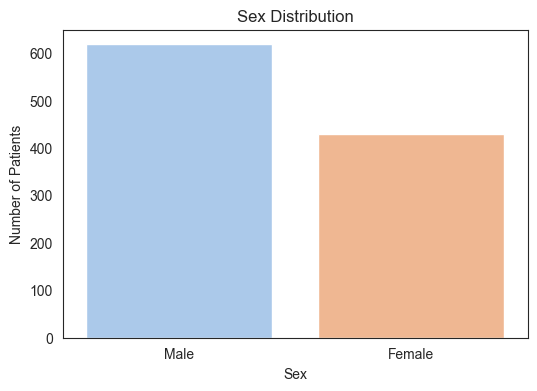

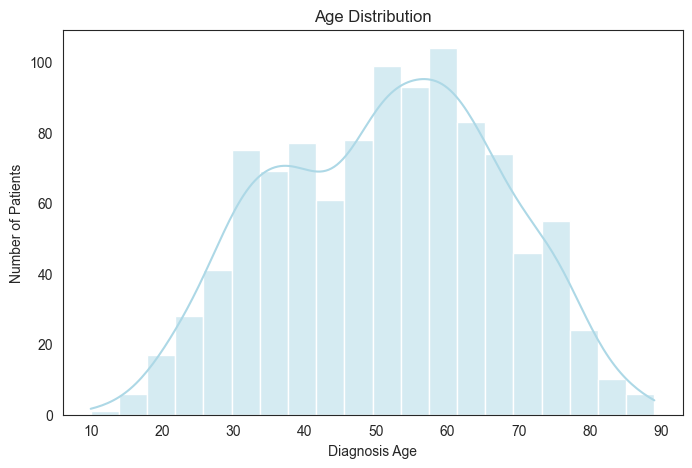


Neoplasm Histologic Type Distribution:
Neoplasm Histologic Type Name
glioblastoma         590
oligodendroglioma    174
astrocytoma          169
oligoastrocytoma     114
Name: count, dtype: int64


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/3328182810.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=histologic_type_distribution.index, y=histologic_type_distribution.values, palette='muted')


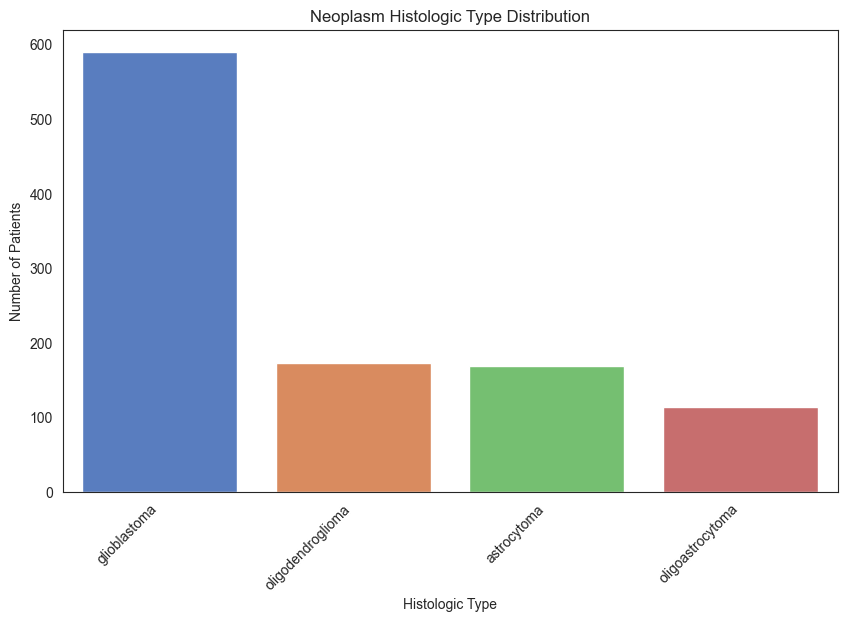

/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/3328182810.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=histologic_grade_distribution.index, y=histologic_grade_distribution.values, palette='deep')



Neoplasm Histologic Grade Distribution:
Neoplasm Histologic Grade
G4    590
G3    241
G2    216
Name: count, dtype: int64


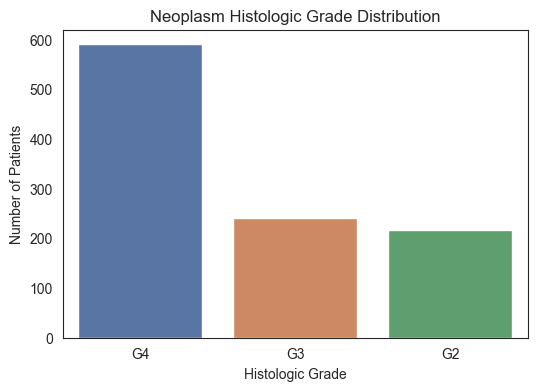

In [507]:
# Display total patient count
total_patients = clinical_data['Patient ID'].nunique()
print(f"Total Patient Count: {total_patients}")

# Plot and display Sex distribution
sex_distribution = clinical_data['Sex'].value_counts()
print("\nSex Distribution:")
print(sex_distribution)

plt.figure(figsize=(6, 4))
sns.barplot(x=sex_distribution.index, y=sex_distribution.values, palette='pastel')
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Number of Patients')
plt.show()

# Plot and display Age distribution
plt.figure(figsize=(8, 5))
sns.histplot(clinical_data['Diagnosis Age'], bins=20, kde=True, color='lightblue')
plt.title('Age Distribution')
plt.xlabel('Diagnosis Age')
plt.ylabel('Number of Patients')
plt.show()

# Display Neoplasm Histologic Type distribution
histologic_type_distribution = clinical_data['Neoplasm Histologic Type Name'].value_counts()
print("\nNeoplasm Histologic Type Distribution:")
print(histologic_type_distribution)

plt.figure(figsize=(10, 6))
sns.barplot(x=histologic_type_distribution.index, y=histologic_type_distribution.values, palette='muted')
plt.xticks(rotation=45, ha='right')
plt.title('Neoplasm Histologic Type Distribution')
plt.xlabel('Histologic Type')
plt.ylabel('Number of Patients')
plt.show()

# Display Neoplasm Histologic Grade distribution
histologic_grade_distribution = clinical_data['Neoplasm Histologic Grade'].value_counts()
print("\nNeoplasm Histologic Grade Distribution:")
print(histologic_grade_distribution)

plt.figure(figsize=(6, 4))
sns.barplot(x=histologic_grade_distribution.index, y=histologic_grade_distribution.values, palette='deep')
plt.title('Neoplasm Histologic Grade Distribution')
plt.xlabel('Histologic Grade')
plt.ylabel('Number of Patients')
plt.show()

### **Merging clinical data table with mutated genes table**

Creating mutations_merged_df

In [508]:
# Step 1: Perform the merging steps to create the intermediate columns
merged_df = pd.merge(data_mutations_short, clinical_data[['Patient ID', 'Sample ID']],
                     left_on='Tumor_Sample_Barcode', right_on='Sample ID', how='left')

merged_df = pd.merge(merged_df, clinical_data[['Patient ID', 'Sample ID']],
                     left_on='Tumor_Sample_Barcode', right_on='Patient ID', how='left',
                     suffixes=('_from_sample', '_from_patient'))

# Step 2: Place this code here to finalize columns, rename, and calculate row counts

# Save the initial row count before dropping NaN values
initial_row_count = merged_df.shape[0]

# Finalize Patient ID and Sample ID columns based on available matches
merged_df['Patient ID'] = merged_df['Patient ID_from_sample'].combine_first(merged_df['Patient ID_from_patient'])
merged_df['Sample ID'] = merged_df['Sample ID_from_sample'].combine_first(merged_df['Sample ID_from_patient'])

# Drop rows with NaN values in the final Patient ID and Sample ID columns
merged_df = merged_df.dropna(subset=['Patient ID', 'Sample ID'])

# Save the row count after dropping NaN values
final_row_count = merged_df.shape[0]

# Drop intermediate columns used for matching
mutations_merged_df = merged_df.drop(columns=['Patient ID_from_sample', 'Patient ID_from_patient',
                                    'Sample ID_from_sample', 'Sample ID_from_patient'])

# Display the result for verification
print(f"Initial row count before dropping NaN: {initial_row_count}")
print(f"Final row count after dropping NaN: {final_row_count}")

print("Columns in the merged DataFrame:")
print(mutations_merged_df.columns)
print("First few rows of the merged DataFrame:")
print(mutations_merged_df.head())


Initial row count before dropping NaN: 30729
Final row count after dropping NaN: 28613
Columns in the merged DataFrame:
Index(['Hugo_Symbol', 'Variant_Classification', 'Tumor_Sample_Barcode',
       'Patient ID', 'Sample ID'],
      dtype='object')
First few rows of the merged DataFrame:
  Hugo_Symbol Variant_Classification Tumor_Sample_Barcode    Patient ID  \
0       AKAP6      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
1      ANAPC4      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
2       AUTS2      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
3       ABTB3      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
4      CLEC3B                 Silent         TCGA-02-0003  TCGA-02-0003   

         Sample ID  
0  TCGA-02-0003-01  
1  TCGA-02-0003-01  
2  TCGA-02-0003-01  
3  TCGA-02-0003-01  
4  TCGA-02-0003-01  


In [509]:
# Total number of patients after merge
# Step 1: Get unique Patient IDs
id_patients = mutations_merged_df ['Patient ID'].unique()

# Step 2: Count the number of unique Patient IDs
patient_count = len(id_patients)

# Step 5: Print the results
print(f"Total number of patients: {patient_count}")

Total number of patients: 746


In [511]:
# Row count before filtering
initial_row_count = mutations_merged_df.shape[0]

# Filter out rows where Variant_Classification is 'Silent'
mutations_merged_df = mutations_merged_df[mutations_merged_df['Variant_Classification'] != 'Silent']

# Row count after filtering
final_row_count = mutations_merged_df.shape[0]

# Calculate the number of rows removed (those with 'Silent' in Variant_Classification)
silent_count = initial_row_count - final_row_count

# Display the results
print(f"Initial row count: {initial_row_count}")
print(f"Number of rows with 'Silent' in Variant_Classification removed: {silent_count}")
print(f"Row count after dropping 'Silent' rows: {final_row_count}")

# Display the updated DataFrame for verification
print("Updated mutations_merged_df:")
print(mutations_merged_df.head())


Initial row count: 21729
Number of rows with 'Silent' in Variant_Classification removed: 0
Row count after dropping 'Silent' rows: 21729
Updated mutations_merged_df:
  Hugo_Symbol Variant_Classification Tumor_Sample_Barcode    Patient ID  \
0       AKAP6      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
1      ANAPC4      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
2       AUTS2      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
3       ABTB3      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
7      DZIP1L      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   

         Sample ID  
0  TCGA-02-0003-01  
1  TCGA-02-0003-01  
2  TCGA-02-0003-01  
3  TCGA-02-0003-01  
7  TCGA-02-0003-01  


In [512]:
# Assuming the 'mutations_merged_df' and 'pathways_exploded' DataFrames are already loaded

# Step 1: Clean and standardize 'Hugo_Symbol' in the 'mutations_merged_df' DataFrame
mutations_merged_df['Hugo_Symbol'] = mutations_merged_df['Hugo_Symbol'].str.strip().str.upper()

# Step 2: Clean and standardize the 'Genes' in the 'pathways_exploded' DataFrame
pathways_exploded['Genes'] = pathways_exploded['Genes'].str.strip().str.upper()

# Step 4: Merge the 'mutations' and 'pathways_exploded' DataFrames
mutations_with_pathways = pd.merge(
    mutations_merged_df,              # The mutations DataFrame
    pathways_exploded,       # The exploded pathways DataFrame
    left_on='Hugo_Symbol',   # Column in mutations that contains gene names
    right_on='Genes',        # Column in pathways that contains gene names
    how='left'               # Use 'left' join to keep all mutations, even if no pathway is found
)

# Step 5: Fill missing pathways with 'none'
mutations_with_pathways['Pathway'].fillna('none', inplace=True)

# Step 6: Drop the 'Genes' column from the resulting DataFrame since it's redundant
mutations_with_pathways.drop(columns=['Genes'], inplace=True)
mutations_with_pathways

/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/3656647328.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mutations_with_pathways['Pathway'].fillna('none', inplace=True)


,Hugo_Symbol,Variant_Classification,Tumor_Sample_Barcode,Patient ID,Sample ID,Pathway
0,AKAP6,Missense_Mutation,TCGA-02-0003,TCGA-02-0003,TCGA-02-0003-01,none
1,ANAPC4,Missense_Mutation,TCGA-02-0003,TCGA-02-0003,TCGA-02-0003-01,none
2,AUTS2,Missense_Mutation,TCGA-02-0003,TCGA-02-0003,TCGA-02-0003-01,none
3,ABTB3,Missense_Mutation,TCGA-02-0003,TCGA-02-0003,TCGA-02-0003-01,none
4,DZIP1L,Missense_Mutation,TCGA-02-0003,TCGA-02-0003,TCGA-02-0003-01,none
...,...,...,...,...,...,...
22632,SMARCA4,In_Frame_Del,TCGA-WY-A858,TCGA-WY-A858,TCGA-WY-A858-01,Chromatin remodeling
22633,ATRX,Frame_Shift_Del,TCGA-WY-A858,TCGA-WY-A858,TCGA-WY-A858-01,Astrocytic drivers
22634,ATRX,Frame_Shift_Del,TCGA-WY-A858,TCGA-WY-A858,TCGA-WY-A858-01,Telomere maintenance
22635,MT-CO1,Missense_Mutation,TCGA-CS-4943,TCGA-CS-4943,TCGA-CS-4943-01,none


In [513]:
print(f"Total samples in mutations_with_pathways: {len(mutations_with_pathways)}")

Total samples in mutations_with_pathways: 22637


In [514]:
# Total number of patients after merge
# Step 1: Get unique Patient IDs
id_patients = mutations_with_pathways ['Patient ID'].unique()

# Step 2: Count the number of unique Patient IDs
patient_count = len(id_patients)

# Step 5: Print the results
print(f"Total number of patients: {patient_count}")

Total number of patients: 745


In [515]:
# Save the cleaned DataFrame
mutations_with_pathways.to_csv('mutations_with_pathways.csv', index=False)

Merge clinical data with mutated genes table on patient ID, keeping only relevant columns.


In [516]:
# Select relevant columns from clinical_data
clinical_columns = ['Patient ID', 'Diagnosis Age', 'Sex', 'TMB (nonsynonymous)', 'Pan-Glioma DNA Methylation Cluster', 'Neoplasm Histologic Type Name', 'Neoplasm Histologic Grade', 'Overall Survival (Months)',	'Overall Survival Status', 'IDH status']
clinical_selected = clinical_data[clinical_columns]

# Merge the selected clinical columns with mutations_with_pathways on 'Patient ID'
clinical_mutations_pathways = pd.merge(mutations_with_pathways, clinical_selected, on='Patient ID', how='left')

# Display the resulting DataFrame for verification
print("Merged DataFrame with selected clinical data:")
print(clinical_mutations_pathways.head())

Merged DataFrame with selected clinical data:
  Hugo_Symbol Variant_Classification Tumor_Sample_Barcode    Patient ID  \
0       AKAP6      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
1      ANAPC4      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
2       AUTS2      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
3       ABTB3      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   
4      DZIP1L      Missense_Mutation         TCGA-02-0003  TCGA-02-0003   

         Sample ID Pathway  Diagnosis Age   Sex  TMB (nonsynonymous)  \
0  TCGA-02-0003-01    none             50  Male             1.366667   
1  TCGA-02-0003-01    none             50  Male             1.366667   
2  TCGA-02-0003-01    none             50  Male             1.366667   
3  TCGA-02-0003-01    none             50  Male             1.366667   
4  TCGA-02-0003-01    none             50  Male             1.366667   

  Pan-Glioma DNA Methylation Cluster Neoplasm Histologic Type Name  \


In [517]:
# Check for NaNs
print("NaN counts per column:")
print(clinical_mutations_pathways.isna().sum())

# Check for empty strings
print("\nEmpty string counts per column:")
print((clinical_mutations_pathways == '').sum())

NaN counts per column:
Hugo_Symbol                              0
Variant_Classification                   0
Tumor_Sample_Barcode                     0
Patient ID                               0
Sample ID                                0
Pathway                                  0
Diagnosis Age                            0
Sex                                      0
TMB (nonsynonymous)                      0
Pan-Glioma DNA Methylation Cluster    1977
Neoplasm Histologic Type Name            0
Neoplasm Histologic Grade                0
Overall Survival (Months)                0
Overall Survival Status                 42
IDH status                               0
dtype: int64

Empty string counts per column:
Hugo_Symbol                           0
Variant_Classification                0
Tumor_Sample_Barcode                  0
Patient ID                            0
Sample ID                             0
Pathway                               0
Diagnosis Age                         0
Sex   

In [518]:
# Save the cleaned DataFrame
clinical_mutations_pathways.to_csv('clinical_mutations_pathways.csv', index=False)

In [519]:
print(clinical_mutations_pathways.columns.tolist())

['Hugo_Symbol', 'Variant_Classification', 'Tumor_Sample_Barcode', 'Patient ID', 'Sample ID', 'Pathway', 'Diagnosis Age', 'Sex', 'TMB (nonsynonymous)', 'Pan-Glioma DNA Methylation Cluster', 'Neoplasm Histologic Type Name', 'Neoplasm Histologic Grade', 'Overall Survival (Months)', 'Overall Survival Status', 'IDH status']


## **Description of the population after filtering the data**

Total Patient Count: 745

Sex Distribution:
Sex
Male      440
Female    305
Name: count, dtype: int64


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/1494220146.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sex_counts.index, y=sex_counts.values, palette='pastel')


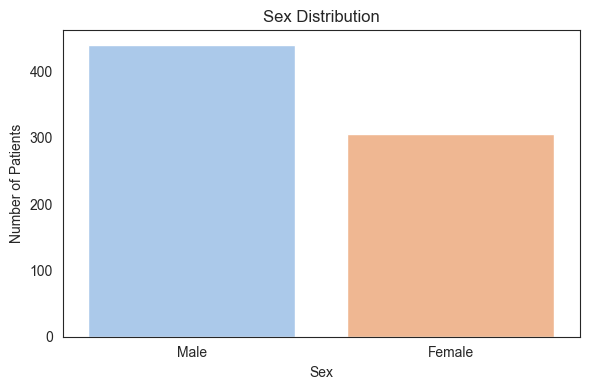

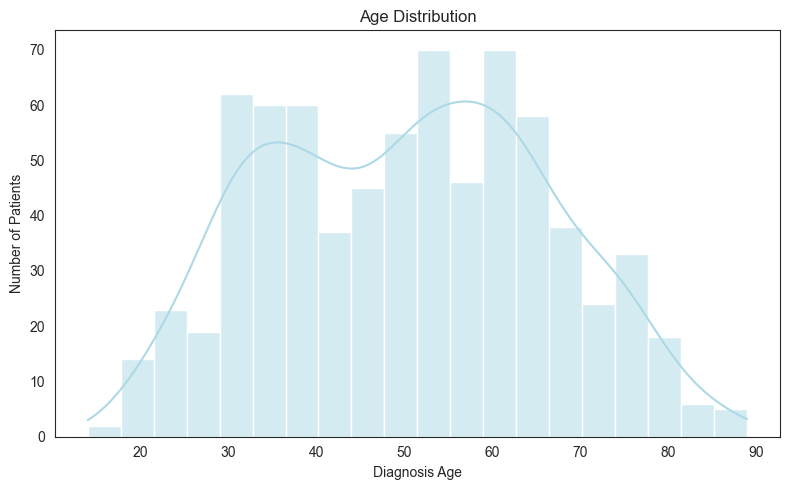


Neoplasm Histologic Type Distribution:
Neoplasm Histologic Type Name
glioblastoma         295
oligodendroglioma    170
astrocytoma          167
oligoastrocytoma     113
Name: count, dtype: int64


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/1494220146.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=type_counts.index, y=type_counts.values, palette='muted')


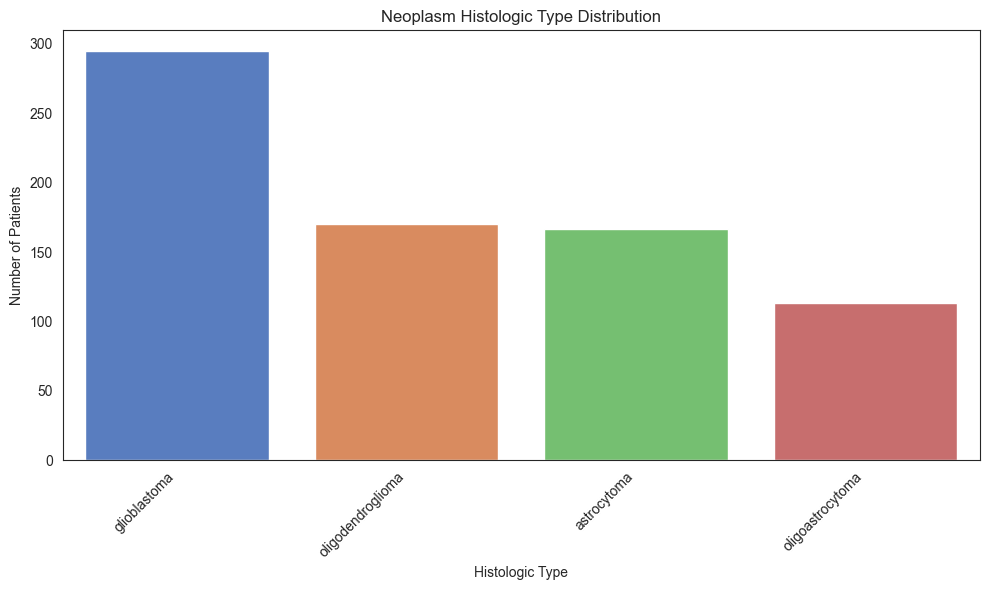


Neoplasm Histologic Grade Distribution:
Neoplasm Histologic Grade
G4    295
G3    239
G2    211
Name: count, dtype: int64


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/1494220146.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grade_counts.index, y=grade_counts.values, palette='deep')


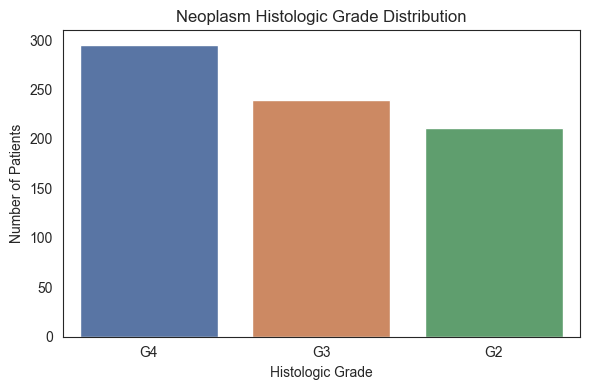

In [520]:
# 1) Deduplicate so one row per patient
df_unique = clinical_mutations_pathways.drop_duplicates(subset='Patient ID')

# 2) Total patient count
total_patients = df_unique['Patient ID'].nunique()
print(f"Total Patient Count: {total_patients}")

# 3) Sex distribution
sex_counts = df_unique['Sex'].value_counts()
print("\nSex Distribution:")
print(sex_counts)
plt.figure(figsize=(6, 4))
sns.barplot(x=sex_counts.index, y=sex_counts.values, palette='pastel')
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.show()

# 4) Age distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_unique['Diagnosis Age'], bins=20, kde=True, color='lightblue')
plt.title('Age Distribution')
plt.xlabel('Diagnosis Age')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.show()

# 5) Neoplasm Histologic Type distribution
type_counts = df_unique['Neoplasm Histologic Type Name'].value_counts()
print("\nNeoplasm Histologic Type Distribution:")
print(type_counts)
plt.figure(figsize=(10, 6))
sns.barplot(x=type_counts.index, y=type_counts.values, palette='muted')
plt.xticks(rotation=45, ha='right')
plt.title('Neoplasm Histologic Type Distribution')
plt.xlabel('Histologic Type')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.show()

# 6) Neoplasm Histologic Grade distribution
grade_counts = df_unique['Neoplasm Histologic Grade'].value_counts()
print("\nNeoplasm Histologic Grade Distribution:")
print(grade_counts)
plt.figure(figsize=(6, 4))
sns.barplot(x=grade_counts.index, y=grade_counts.values, palette='deep')
plt.title('Neoplasm Histologic Grade Distribution')
plt.xlabel('Histologic Grade')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.show()


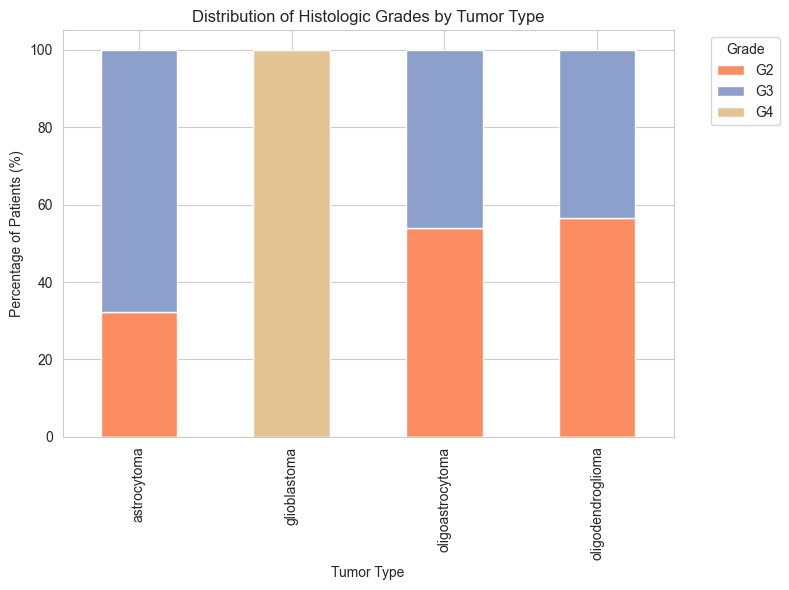

In [521]:
# 1. One row per patient
df = (
    clinical_mutations_pathways
    [['Patient ID','Neoplasm Histologic Type Name','Neoplasm Histologic Grade']]
    .drop_duplicates('Patient ID')
)

# 2. Compute grade distribution per tumor type (as %)
dist = (
    pd.crosstab(df['Neoplasm Histologic Type Name'],
                df['Neoplasm Histologic Grade'],
                normalize='index')
    * 100
)

# 3. Pick the Set2 colors for orange, blue, pink
full = sns.color_palette("Set2", 8)
# index 1 → orange, 2 → blue, 3 → pink
colors = [full[i] for i in (1, 2, 6)]

# 4. Plot with exactly those three colors
sns.set_style("whitegrid")
ax = dist.plot(
    kind='bar',
    stacked=True,
    color=colors,
    figsize=(8, 6)
)

plt.ylabel('Percentage of Patients (%)')
plt.xlabel('Tumor Type')
plt.title('Distribution of Histologic Grades by Tumor Type')
plt.legend(title='Grade', bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()


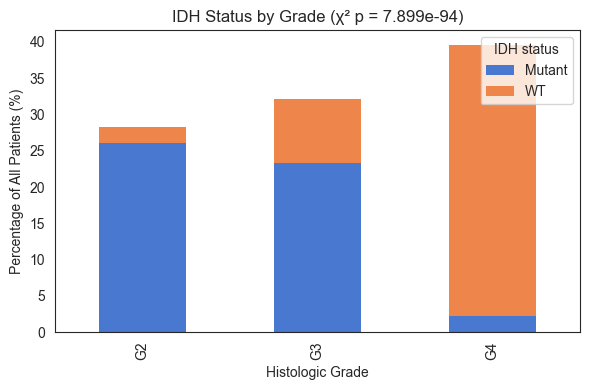

In [408]:
# 1. Prepare data (unchanged)
cols = ['Patient ID', 'Neoplasm Histologic Grade', 'IDH status']
clinical_info = (
    clinical_mutations_pathways[cols]
    .drop_duplicates('Patient ID')
)
clinical_info['Grade_Group'] = pd.Categorical(
    clinical_info['Neoplasm Histologic Grade'],
    categories=['G2','G3','G4'],
    ordered=True
)

# 2. Contingency table
table = pd.crosstab(clinical_info['Grade_Group'], clinical_info['IDH status'])

# 2a. Convert to percentage of all patients
total_patients = table.values.sum()
table_pct = table.divide(total_patients).multiply(100)

# 2b. χ² test (on counts, as before)
chi2, p, _, _ = chi2_contingency(table)

# 3. Plot percentages
sns.set_style("white")
palette = sns.color_palette("muted", n_colors=2)

ax = table_pct.plot(
    kind='bar',
    stacked=True,
    color=palette,
    figsize=(6, 4),
    edgecolor='none'
)
ax.grid(False)
ax.set_title(f"IDH Status by Grade (χ² p = {p:.3e})")
ax.set_xlabel('Histologic Grade')
ax.set_ylabel('Percentage of All Patients (%)')
ax.legend(title='IDH status', loc='upper right')
plt.tight_layout()
plt.show()


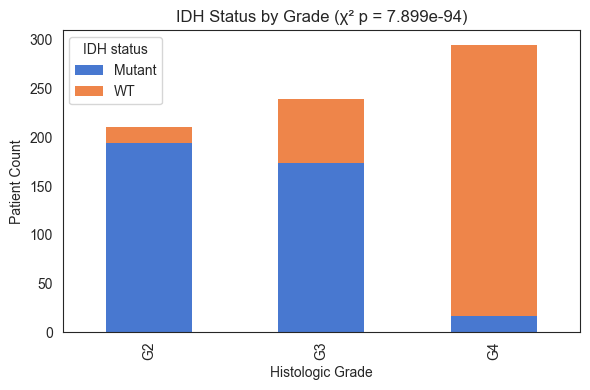

In [522]:
# 1. Prepare data
cols = ['Patient ID', 'Neoplasm Histologic Grade', 'IDH status']
clinical_info = (
    clinical_mutations_pathways[cols]
    .drop_duplicates('Patient ID')
)
clinical_info['Grade_Group'] = pd.Categorical(
    clinical_info['Neoplasm Histologic Grade'],
    categories=['G2','G3','G4'],
    ordered=True
)

# 2. Contingency table and χ² test
table = pd.crosstab(clinical_info['Grade_Group'], clinical_info['IDH status'])
chi2, p, _, _ = chi2_contingency(table)

# 3. Plot with muted blue & orange, no grid
sns.set_style("white")
palette = sns.color_palette("muted", n_colors=2)  # muted blue, muted orange

ax = table.plot(
    kind='bar',
    stacked=True,
    color=palette,
    figsize=(6,4),
    edgecolor='none'
)
ax.grid(False)
ax.set_title(f"IDH Status by Grade (χ² p = {p:.3e})")
ax.set_xlabel('Histologic Grade')
ax.set_ylabel('Patient Count')
ax.legend(title='IDH status')
plt.tight_layout()
plt.show()



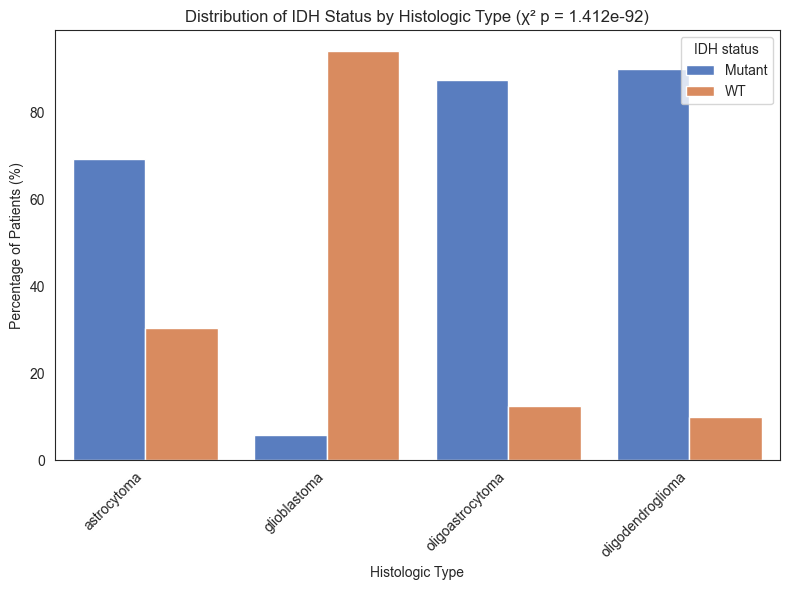

In [523]:
# 1. One row per patient
df = (
    clinical_mutations_pathways
    [['Patient ID', 'IDH status', 'Neoplasm Histologic Type Name']]
    .drop_duplicates('Patient ID')
)

# 2. Build contingency table and χ² test
table = pd.crosstab(df['Neoplasm Histologic Type Name'], df['IDH status'])
chi2, p, _, _ = chi2_contingency(table)

# 3. Compute percentages
counts = table.reset_index().melt(id_vars='Neoplasm Histologic Type Name',
                                  var_name='IDH status', value_name='count')
counts['percent'] = (
    counts['count'] /
    counts.groupby('Neoplasm Histologic Type Name')['count'].transform('sum')
    * 100
)

# 4. Plot
sns.set_style("white")
palette = sns.color_palette("muted", 2)  # muted blue & orange

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=counts,
    x='Neoplasm Histologic Type Name',
    y='percent',
    hue='IDH status',
    palette=palette
)
ax.set_ylabel('Percentage of Patients (%)')
ax.set_xlabel('Histologic Type')
ax.set_title(f'Distribution of IDH Status by Histologic Type (χ² p = {p:.3e})')
ax.legend(title='IDH status', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/1394551471.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


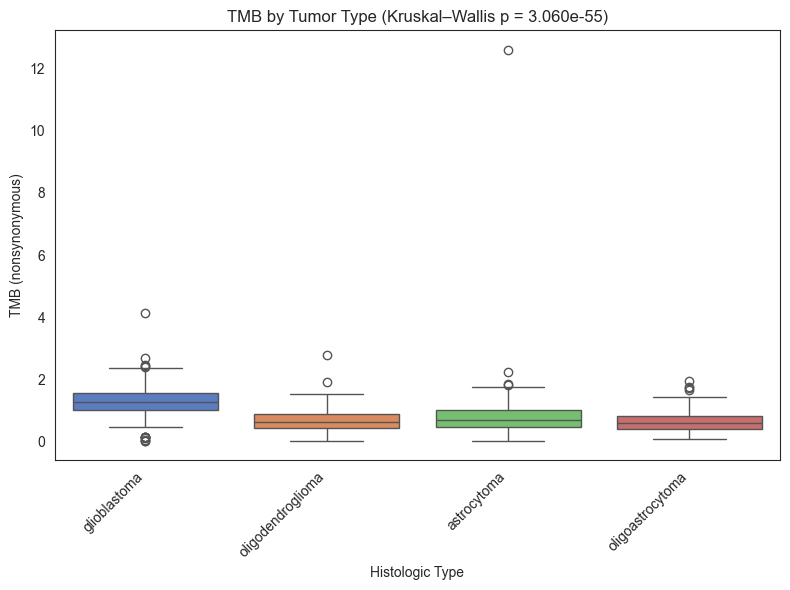

In [524]:
# 1. One row per patient with TMB and histologic type
cols = ['Patient ID', 'Neoplasm Histologic Type Name', 'TMB (nonsynonymous)']
df_tmb = clinical_mutations_pathways[cols].drop_duplicates('Patient ID')
df_tmb = df_tmb.dropna(subset=['TMB (nonsynonymous)'])

# 2. Prepare data for Kruskal–Wallis test
types = ['glioblastoma', 'oligodendroglioma', 'astrocytoma', 'oligoastrocytoma']
groups = [df_tmb[df_tmb['Neoplasm Histologic Type Name'] == t]['TMB (nonsynonymous)'] for t in types]
h_stat, p_value = kruskal(*groups)

# 3. Plot
sns.set_style("white")
plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    data=df_tmb,
    x='Neoplasm Histologic Type Name',
    y='TMB (nonsynonymous)',
    order=types,
    palette="muted"
)
ax.set_title(f"TMB by Tumor Type (Kruskal–Wallis p = {p_value:.3e})")
ax.set_xlabel('Histologic Type')
ax.set_ylabel('TMB (nonsynonymous)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/4204861222.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


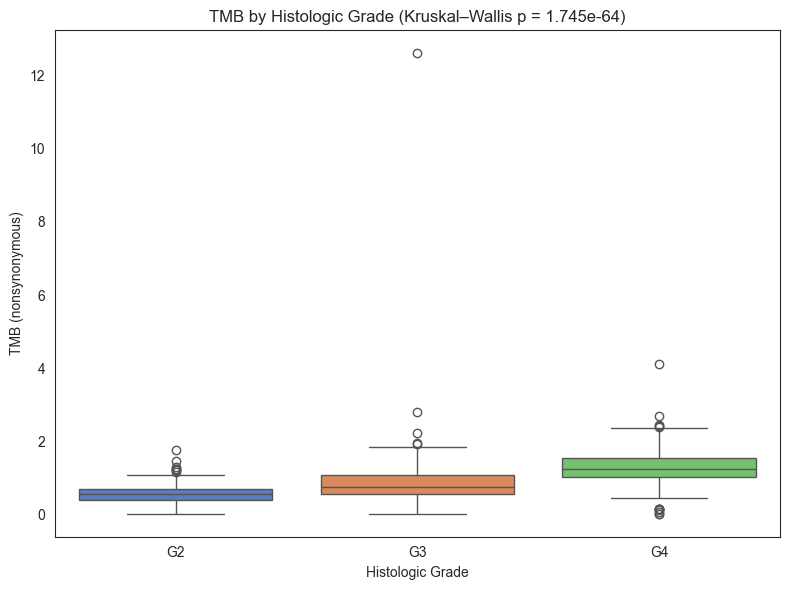

In [525]:
# 1. One row per patient with TMB and grade
cols = ['Patient ID', 'Neoplasm Histologic Grade', 'TMB (nonsynonymous)']
df_tmb = clinical_mutations_pathways[cols].drop_duplicates('Patient ID')
df_tmb = df_tmb.dropna(subset=['TMB (nonsynonymous)'])

# 2. Prepare grade-ordered categories
grade_order = ['G2', 'G3', 'G4']
df_tmb['Grade'] = pd.Categorical(
    df_tmb['Neoplasm Histologic Grade'],
    categories=grade_order,
    ordered=True
)

# 3. Kruskal–Wallis test across grades
groups = [df_tmb[df_tmb['Grade'] == g]['TMB (nonsynonymous)'] for g in grade_order]
h_stat, p_value = kruskal(*groups)

# 4. Plot
sns.set_style("white")
plt.figure(figsize=(8,6))
ax = sns.boxplot(
    data=df_tmb,
    x='Grade',
    y='TMB (nonsynonymous)',
    order=grade_order,
    palette="muted"
)
ax.set_title(f"TMB by Histologic Grade (Kruskal–Wallis p = {p_value:.3e})")
ax.set_xlabel('Histologic Grade')
ax.set_ylabel('TMB (nonsynonymous)')
ax.grid(False)
plt.tight_layout()
plt.show()


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/2780936720.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


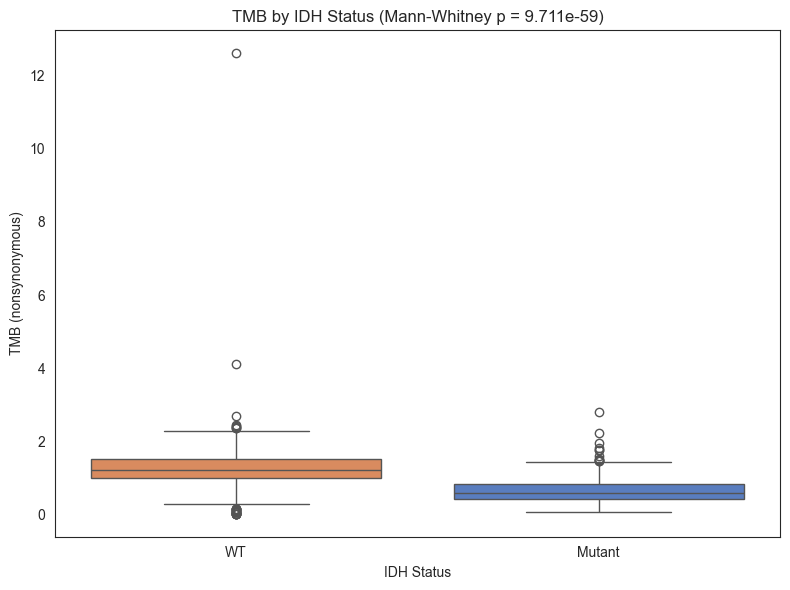

In [526]:
# 1. Prepare style and muted palette, then reverse it
sns.set_style("white")
base_palette = sns.color_palette("muted", 2)  # [blue, orange]
palette = [base_palette[1], base_palette[0]]  # now [orange, blue]

# 2. Get one row per patient with necessary columns
cols_needed = ['Patient ID', 'IDH status', 'TMB (nonsynonymous)']
clinical_info = clinical_mutations_pathways[cols_needed].drop_duplicates('Patient ID')

# 3. Drop NaNs in TMB
clinical_info = clinical_info.dropna(subset=['TMB (nonsynonymous)'])

# 4. Mann-Whitney U test
mutant = clinical_info.loc[clinical_info['IDH status'] == 'Mutant', 'TMB (nonsynonymous)']
wt     = clinical_info.loc[clinical_info['IDH status'] == 'WT',     'TMB (nonsynonymous)']
_, p_value = mannwhitneyu(mutant, wt, alternative='two-sided')

# 5. Plot with reversed colors
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=clinical_info,
    x='IDH status',
    y='TMB (nonsynonymous)',
    palette=palette
)
plt.title(f"TMB by IDH Status (Mann-Whitney p = {p_value:.3e})")
plt.xlabel('IDH Status')
plt.ylabel('TMB (nonsynonymous)')
plt.tight_layout()
plt.show()


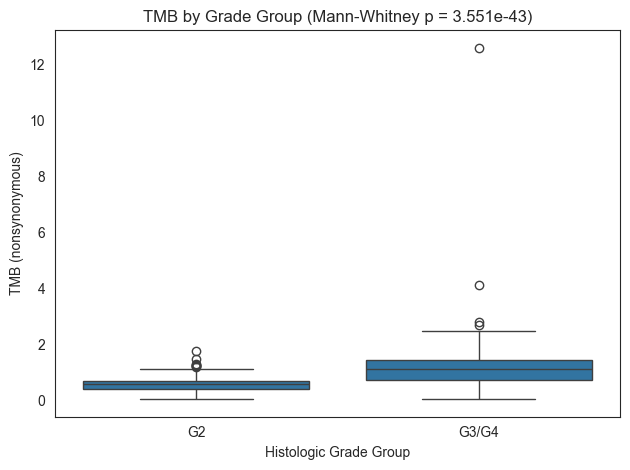

In [527]:
# Select relevant columns and deduplicate
cols = ['Patient ID', 'Neoplasm Histologic Grade', 'TMB (nonsynonymous)']
df = clinical_mutations_pathways[cols].drop_duplicates('Patient ID')

# Group grades
df['Grade_Group'] = df['Neoplasm Histologic Grade'].replace({'G2': 'G2', 'G3': 'G3/G4', 'G4': 'G3/G4'})
df['Grade_Group'] = pd.Categorical(df['Grade_Group'], categories=['G2', 'G3/G4'], ordered=True)

# Drop NaNs
df = df.dropna(subset=['TMB (nonsynonymous)'])

# Split groups
g2 = df[df['Grade_Group'] == 'G2']['TMB (nonsynonymous)']
g34 = df[df['Grade_Group'] == 'G3/G4']['TMB (nonsynonymous)']

# Mann-Whitney U test
_, p = mannwhitneyu(g2, g34, alternative='two-sided')

# Plot
sns.boxplot(data=df, x='Grade_Group', y='TMB (nonsynonymous)')
plt.title(f"TMB by Grade Group (Mann-Whitney p = {p:.3e})")
plt.xlabel('Histologic Grade Group')
plt.ylabel('TMB (nonsynonymous)')
plt.tight_layout()
plt.show()


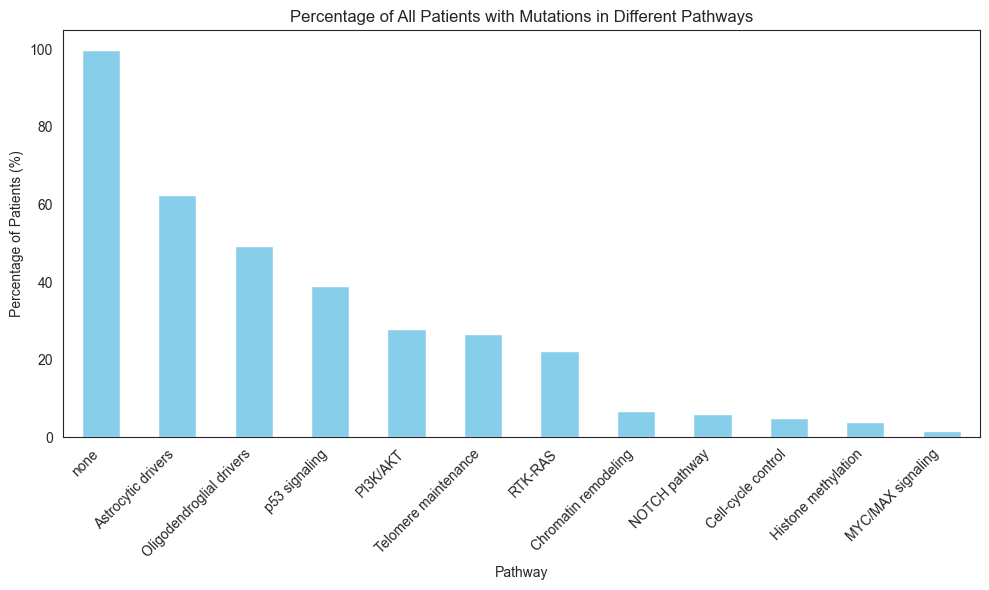

In [528]:
# — Step 1: Re-use the total patient count from before —
# (You already computed this as: total_patients = table.values.sum())
total_samples = total_patients

# — Step 2: Count unique samples per pathway —
# (using the original clinical_mutations_pathways DataFrame)
pathway_counts = (
    clinical_mutations_pathways
    .groupby('Pathway')['Tumor_Sample_Barcode']
    .nunique()
)

# — Step 3: Convert to % of all patients —
pathway_percentages = (pathway_counts / total_samples) * 100

# — Step 4 (optional): sort for plotting —
pathway_percentages = pathway_percentages.sort_values(ascending=False)

# — Step 5: Plot —
plt.figure(figsize=(10, 6))
pathway_percentages.plot(kind='bar', color='skyblue')
plt.title('Percentage of All Patients with Mutations in Different Pathways')
plt.xlabel('Pathway')
plt.ylabel('Percentage of Patients (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/3917705960.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Pathway', 'Grade'])['Patient ID']
/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/3917705960.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_per_grade = df.groupby('Grade')['Patient ID'].nunique()


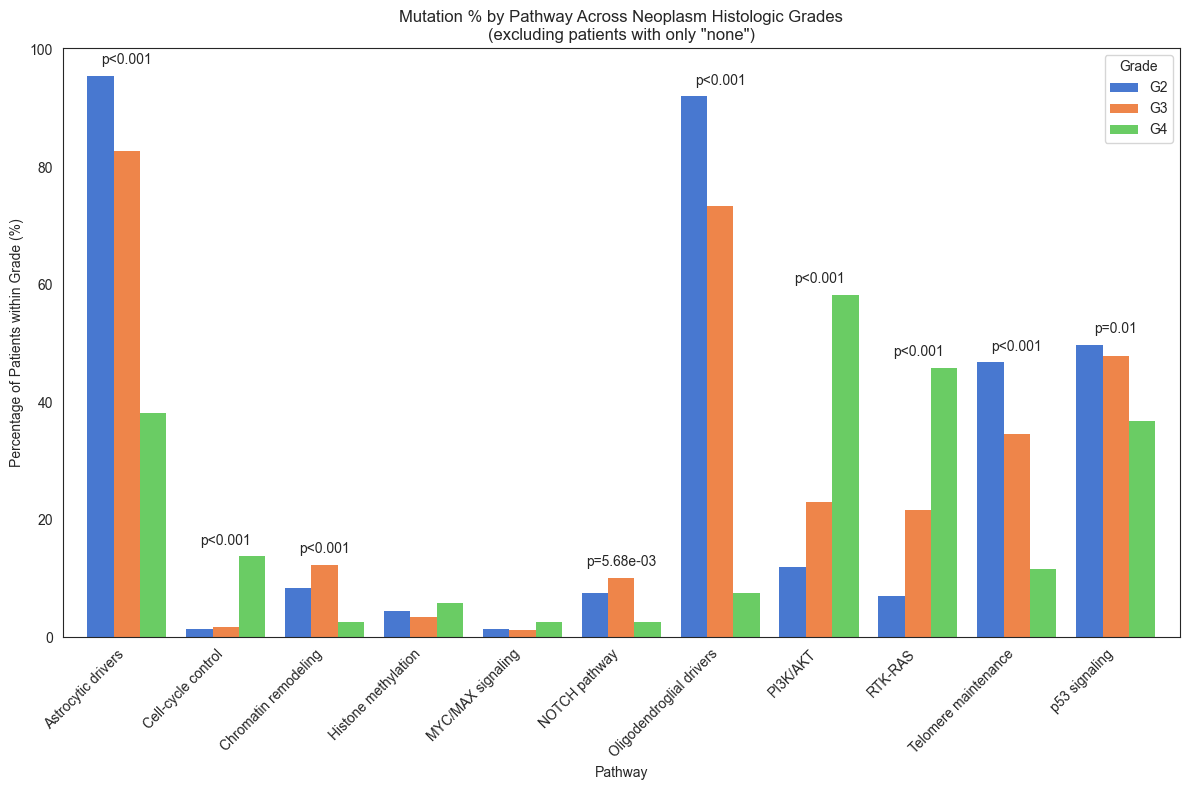

In [612]:
# 0) Copy original DF and filter out "none"
df = clinical_mutations_pathways.copy()
valid_patients = (
    df
    .groupby('Patient ID')['Pathway']
    .apply(lambda paths: not paths.eq('none').all())
)
df = df[df['Patient ID'].isin(valid_patients[valid_patients].index)]
df = df[df['Pathway'] != 'none']

# 1) Define Grade as categorical (G2, G3, G4)
df['Grade'] = pd.Categorical(
    df['Neoplasm Histologic Grade'],
    categories=['G2','G3','G4'],
    ordered=True
)

# 2) Count unique patients per (Pathway × Grade)
pathway_counts = (
    df
    .groupby(['Pathway', 'Grade'])['Patient ID']
    .nunique()
    .unstack(fill_value=0)
)

# 3) Total patients in each Grade
total_per_grade = df.groupby('Grade')['Patient ID'].nunique()

# 4) Compute % of patients per pathway within each Grade
pathway_pct = pathway_counts.div(total_per_grade, axis=1) * 100

# 5) χ² test across G2/G3/G4 for each pathway
p_values = {}
for pw in pathway_counts.index:
    counts = pathway_counts.loc[pw].values
    non_counts = (total_per_grade.values - counts)
    contingency = [counts.tolist(), non_counts.tolist()]
    _, p, _, _ = chi2_contingency(contingency)
    p_values[pw] = p

# 6) Plot with muted palette
sns.set_style("white")
palette = sns.color_palette("muted", n_colors=3)

ax = pathway_pct.plot(
    kind='bar',
    figsize=(12, 8),
    width=0.8,
    color=palette,
    edgecolor='none'
)
ax.set_xlabel('Pathway')
ax.set_ylabel('Percentage of Patients within Grade (%)')
ax.set_title('Mutation % by Pathway Across Neoplasm Histologic Grades\n(excluding patients with only "none")')
plt.xticks(rotation=45, ha='right')
ax.legend(title='Grade')

# 7) Annotate each cluster with its p-value
for i, pw in enumerate(pathway_pct.index):
    p = p_values[pw]
    y_max = pathway_pct.loc[pw].max()
    if p < 0.001:
        sig = 'p<0.001'
    elif p < 0.01:
        sig = f'p={p:.2e}'
    elif p < 0.05:
        sig = f'p={p:.2f}'
    else:
        sig = None
    if sig:
        ax.text(i, y_max + 1.5, sig, ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


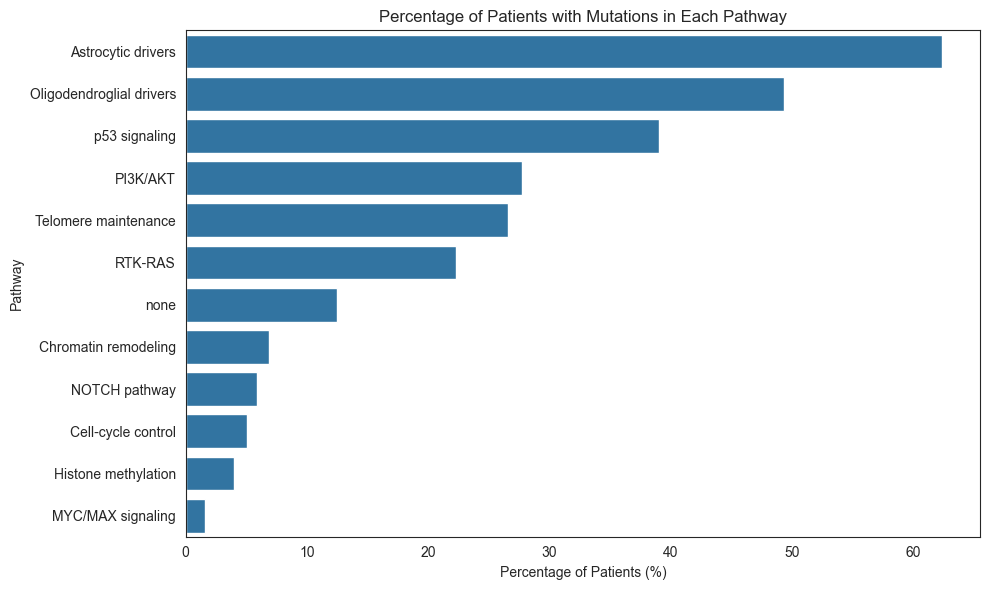

In [531]:
# 1. Unique Patient–Pathway pairs
df_pp = clinical_mutations_pathways[['Patient ID','Pathway']].drop_duplicates()

# 2. Figure out patients whose only pathway is 'none'
all_pats       = set(df_pp['Patient ID'])
p_with_real    = set(df_pp.loc[df_pp['Pathway']!='none','Patient ID'])
only_none      = all_pats - p_with_real

# 3. Count patients per non-none pathway
counts = (
    df_pp[df_pp['Pathway']!='none']
      .groupby('Pathway')['Patient ID']
      .nunique()
)

# 4. Add the true 'none' count
counts['none'] = len(only_none)

# 5. Compute percentages
total = len(all_pats)
percent = (counts / total * 100).sort_values(ascending=False)

# 6. Plot
plt.figure(figsize=(10,6))
sns.barplot(x=percent.values, y=percent.index)
plt.xlabel('Percentage of Patients (%)')
plt.ylabel('Pathway')
plt.title('Percentage of Patients with Mutations in Each Pathway')
plt.tight_layout()
plt.show()


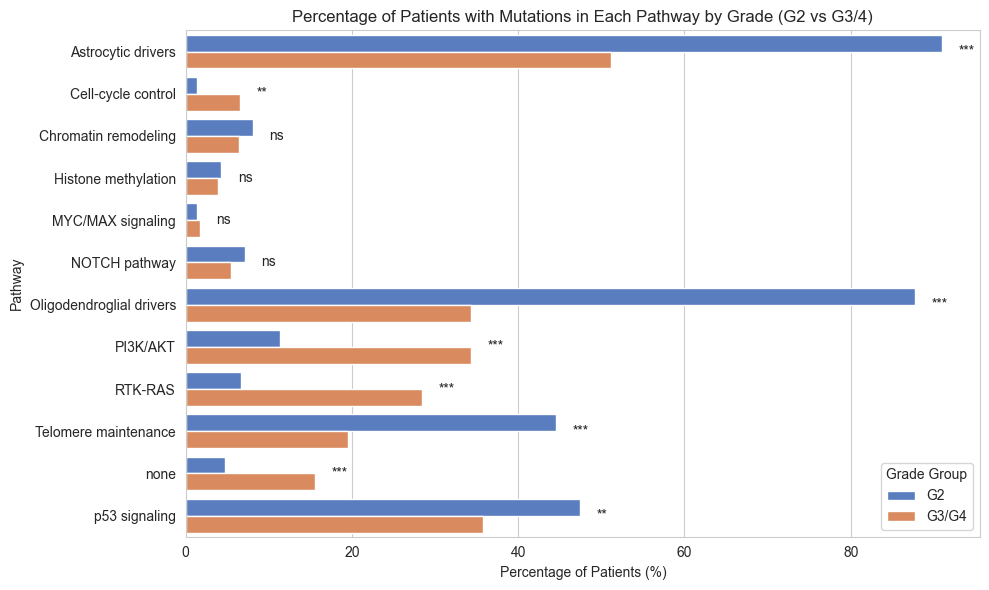

In [532]:
# 1. Unique Patient–Pathway pairs
df_pp = clinical_mutations_pathways[['Patient ID','Pathway']].drop_duplicates()

# 2. Add Grade_Group
patient_grade = clinical_mutations_pathways[['Patient ID','Neoplasm Histologic Grade']].drop_duplicates()
patient_grade['Grade_Group'] = patient_grade['Neoplasm Histologic Grade'].replace({
    'G2':'G2','G3':'G3/G4','G4':'G3/G4'
})
df_pp = df_pp.merge(patient_grade[['Patient ID','Grade_Group']], on='Patient ID')

# 3. Total patients per grade
grade_totals = (
    df_pp.drop_duplicates(['Patient ID','Grade_Group'])
         .groupby('Grade_Group')['Patient ID']
         .nunique()
)

# 4. Counts per pathway × grade
counts = (
    df_pp.groupby(['Pathway','Grade_Group'])['Patient ID']
         .nunique()
         .unstack(fill_value=0)
)

# 5. Fix 'none' to count only those with no real-pathway mutations
all_pats    = set(df_pp['Patient ID'])
p_with_real = set(df_pp[df_pp['Pathway']!='none']['Patient ID'])
only_none   = all_pats - p_with_real

# map each patient to its grade
grade_map = dict(zip(patient_grade['Patient ID'], patient_grade['Grade_Group']))
none_counts = {'G2':0, 'G3/G4':0}
for p in only_none:
    gr = grade_map[p]
    none_counts[gr] += 1

counts.loc['none','G2']    = none_counts['G2']
counts.loc['none','G3/G4'] = none_counts['G3/G4']

# 6. Compute percentages
percent = counts.div(grade_totals, axis=1) * 100

# 7. Fisher's exact p-values
p_values = {}
for pw in counts.index:
    a = counts.loc[pw,'G2']
    b = grade_totals['G2'] - a
    c = counts.loc[pw,'G3/G4']
    d = grade_totals['G3/G4'] - c
    _, p = fisher_exact([[a,b],[c,d]])
    p_values[pw] = p

# 8. Prepare long-format DataFrame
plot_df = (
    percent
    .rename_axis('Pathway')
    .reset_index()
    .melt(id_vars='Pathway', var_name='Grade', value_name='Percentage')
)

# 9. Plot
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
ax = sns.barplot(data=plot_df, x='Percentage', y='Pathway', hue='Grade', palette='muted')

# annotate significance
for i, pw in enumerate(percent.index):
    x = percent.loc[pw].max() + 2
    p = p_values[pw]
    star = '***' if p<0.001 else '**' if p<0.01 else '*' if p<0.05 else 'ns'
    ax.text(x, i, star, va='center')

ax.set_title('Percentage of Patients with Mutations in Each Pathway by Grade (G2 vs G3/4)')
ax.set_xlabel('Percentage of Patients (%)')
ax.set_ylabel('Pathway')
ax.legend(title='Grade Group')
plt.tight_layout()
plt.show()


**Is the distribution of patients with versus without that pathway mutation different across the four histologic types?**

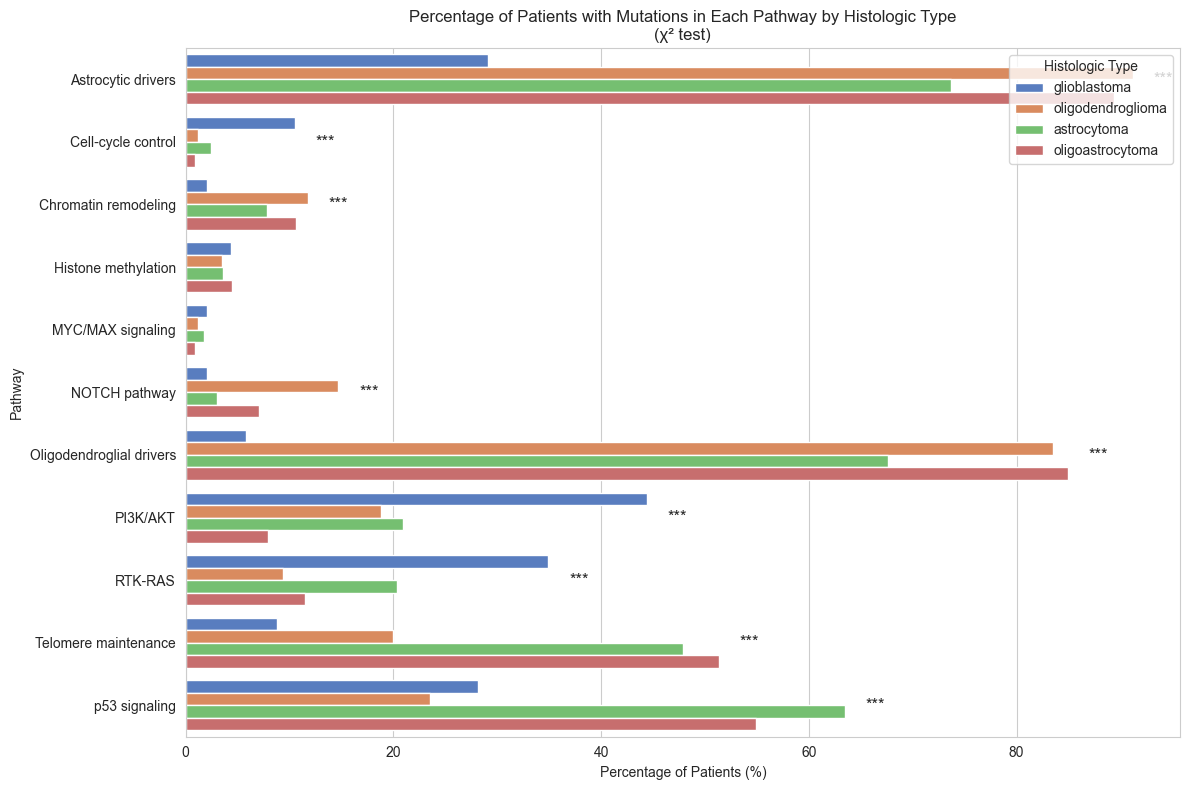

In [611]:
# 1. Unique Patient–Pathway pairs, excluding 'none'
df_pp = (
    clinical_mutations_pathways[['Patient ID','Pathway']]
    .loc[lambda d: d['Pathway'] != 'none']
    .drop_duplicates()
)

# 2. Attach histologic type
patient_type = (
    clinical_mutations_pathways[['Patient ID','Neoplasm Histologic Type Name']]
    .drop_duplicates()
)
df_pp = df_pp.merge(patient_type, on='Patient ID')

# 3. Count per pathway × type (excluding 'none')
types = ['glioblastoma','oligodendroglioma','astrocytoma','oligoastrocytoma']
counts = (
    df_pp
    .groupby(['Pathway','Neoplasm Histologic Type Name'])['Patient ID']
    .nunique()
    .unstack(fill_value=0)
    .reindex(columns=types, fill_value=0)
)

# 4. Totals and percentages
totals = patient_type['Neoplasm Histologic Type Name'].value_counts().reindex(types)
percent = counts.div(totals, axis=1) * 100

# 5. Chi-squared test per pathway
p_values = {}
for pw in counts.index:
    mutated = counts.loc[pw, types].values
    not_mut = totals.values - mutated
    _, p, _, _ = chi2_contingency([mutated, not_mut])
    p_values[pw] = p

# 6. Melt for plotting
plot_df = (
    percent
    .rename_axis('Pathway')
    .reset_index()
    .melt(id_vars='Pathway', var_name='Type', value_name='Percentage')
)

# 7. Plot with annotation
sns.set_style("whitegrid")
plt.figure(figsize=(12,8))
ax = sns.barplot(
    data=plot_df,
    x='Percentage',
    y='Pathway',
    hue='Type',
    order=percent.index,
    hue_order=types,
    palette=sns.color_palette("muted", n_colors=len(types))
)

# annotate p-values
for i, pw in enumerate(percent.index):
    p = p_values[pw]
    star = '***' if p<0.001 else '**' if p<0.01 else '*' if p<0.05 else ''
    x = percent.loc[pw].max() + 2
    ax.text(x, i, star, va='center', fontsize=12)

ax.set_xlabel('Percentage of Patients (%)')
ax.set_ylabel('Pathway')
ax.set_title('Percentage of Patients with Mutations in Each Pathway by Histologic Type\n(χ² test)')
ax.legend(title='Histologic Type', loc='upper right')
plt.tight_layout()
plt.show()


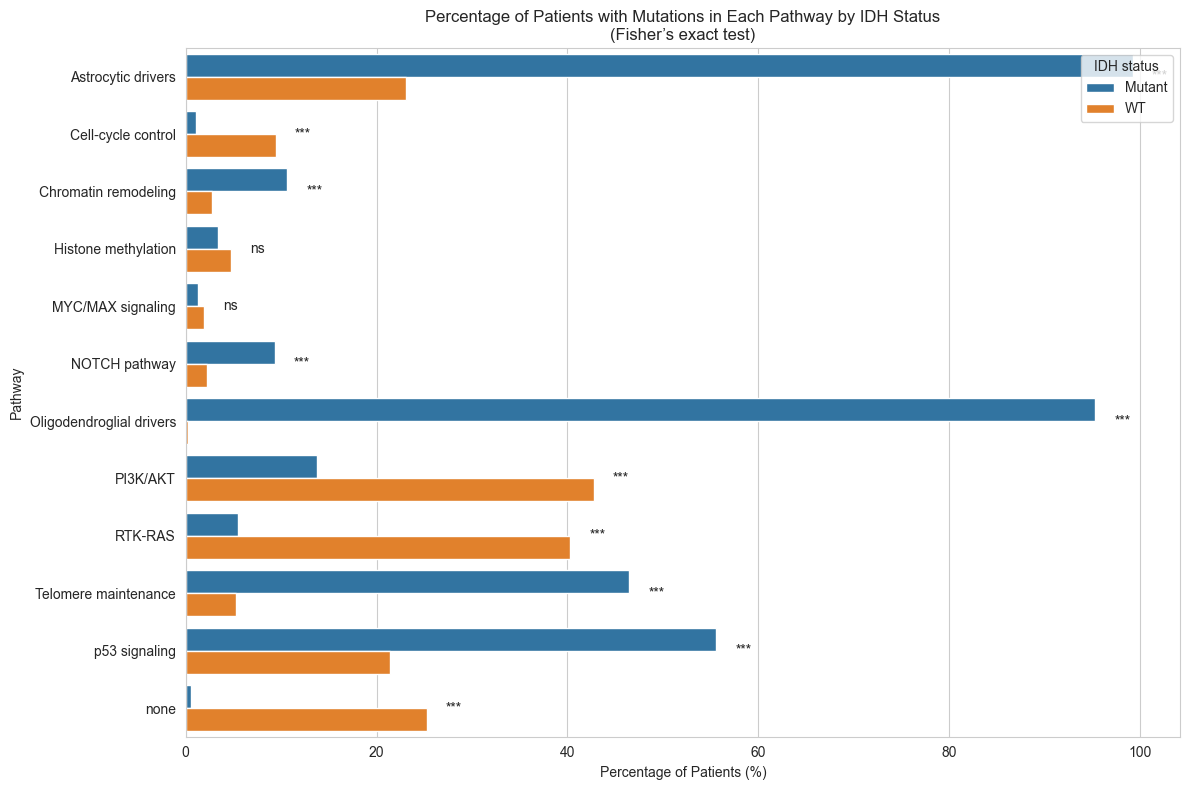

In [535]:
# 1. Unique Patient–Pathway–IDH status rows
df_pp = clinical_mutations_pathways[['Patient ID','Pathway','IDH status']].drop_duplicates()

# 2. Identify patients with only 'none'
all_pats    = set(df_pp['Patient ID'])
p_with_real = set(df_pp[df_pp['Pathway']!='none']['Patient ID'])
only_none   = all_pats - p_with_real

# 3. Count patients per pathway × IDH status (excluding 'none')
statuses = ['Mutant','WT']
counts = (
    df_pp[df_pp['Pathway']!='none']
      .groupby(['Pathway','IDH status'])['Patient ID']
      .nunique()
      .unstack(fill_value=0)
      .reindex(columns=statuses, fill_value=0)
)

# 4. Add true 'none' counts split by IDH status
none_counts = {
    s: len({
        p for p in only_none
        if df_pp.loc[df_pp['Patient ID']==p, 'IDH status'].iloc[0] == s
    })
    for s in statuses
}
counts.loc['none', statuses] = pd.Series(none_counts)

# 5. Compute percentages
totals = (
    df_pp.drop_duplicates(['Patient ID','IDH status'])
         .groupby('IDH status')['Patient ID']
         .nunique()
         .reindex(statuses)
)
percent = counts.div(totals, axis=1) * 100

# 6. Fisher’s exact test per pathway
p_values = {}
for pw in counts.index:
    a = counts.loc[pw, 'Mutant']
    b = totals['Mutant'] - a
    c = counts.loc[pw,   'WT']
    d = totals['WT'] - c
    _, p = fisher_exact([[a, b], [c, d]])
    p_values[pw] = p

# 7. Melt for plotting
plot_df = (
    percent
    .rename_axis('Pathway')
    .reset_index()
    .melt(id_vars='Pathway', var_name='IDH status', value_name='Percentage')
)

# 8. Plot
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=plot_df,
    x='Percentage',
    y='Pathway',
    hue='IDH status',
    order=percent.index
)

# annotate significance
for i, pw in enumerate(percent.index):
    p = p_values[pw]
    star = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
    x = percent.loc[pw].max() + 2
    ax.text(x, i, star, va='center')

ax.set_xlabel('Percentage of Patients (%)')
ax.set_ylabel('Pathway')
ax.set_title('Percentage of Patients with Mutations in Each Pathway by IDH Status\n(Fisher’s exact test)')
ax.legend(title='IDH status', loc='upper right')
plt.tight_layout()
plt.show()


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/2980766626.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Pathway','Grade_Group'])['Patient ID']
/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/2980766626.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('Grade_Group')['Patient ID'] \


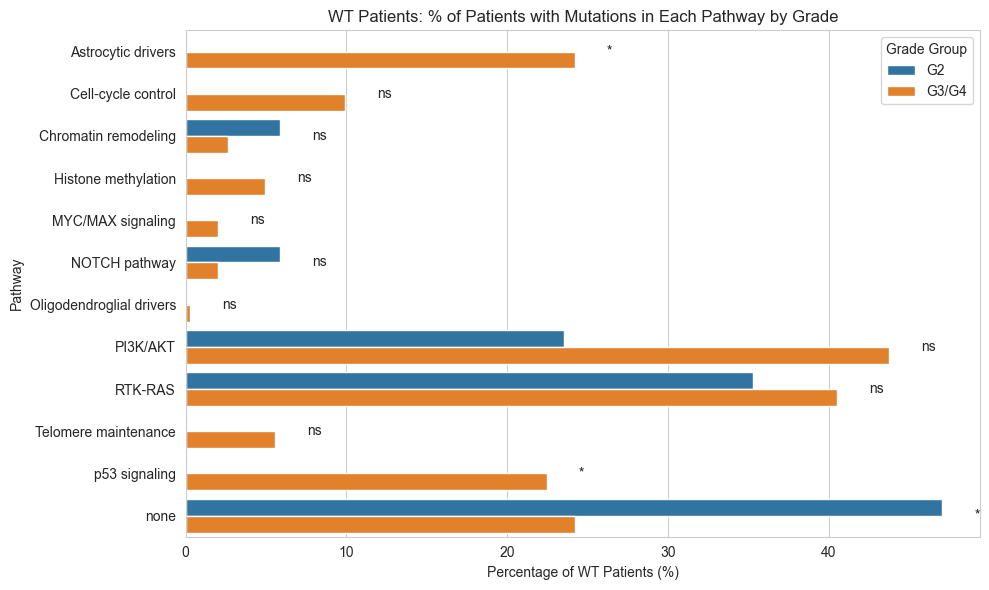

In [536]:
# 1. Subset to IDH WT patients
wt_df = clinical_mutations_pathways[clinical_mutations_pathways['IDH status'] == 'WT']

# 2. Unique Patient–Pathway–Grade rows
df_pp = wt_df[['Patient ID','Pathway','Neoplasm Histologic Grade']].drop_duplicates()

# 3. Map grades to G2 vs G3/G4
df_pp['Grade_Group'] = df_pp['Neoplasm Histologic Grade'] \
    .replace({'G2':'G2','G3':'G3/G4','G4':'G3/G4'})
df_pp['Grade_Group'] = pd.Categorical(df_pp['Grade_Group'],
                                      categories=['G2','G3/G4'],
                                      ordered=True)

# 4. Identify WT patients with only 'none'
all_wt = set(df_pp['Patient ID'])
with_real = set(df_pp[df_pp['Pathway']!='none']['Patient ID'])
only_none = all_wt - with_real

# 5. Count per pathway × grade (excluding 'none')
counts = (
    df_pp[df_pp['Pathway']!='none']
      .groupby(['Pathway','Grade_Group'])['Patient ID']
      .nunique()
      .unstack(fill_value=0)
)

# 6. Add true 'none' counts per grade group
none_counts = {'G2':0,'G3/G4':0}
for pid in only_none:
    g = df_pp.loc[df_pp['Patient ID']==pid,'Grade_Group'].iloc[0]
    none_counts[g] += 1

counts.loc['none','G2']    = none_counts['G2']
counts.loc['none','G3/G4'] = none_counts['G3/G4']

# 7. Compute total WT patients per grade and percentages
grade_totals = df_pp.drop_duplicates(['Patient ID','Grade_Group']) \
                   .groupby('Grade_Group')['Patient ID'] \
                   .nunique()
percent = counts.div(grade_totals, axis=1) * 100

# 8. Fisher’s exact test per pathway
p_values = {}
for pw in counts.index:
    a = counts.loc[pw,'G2']
    b = grade_totals['G2'] - a
    c = counts.loc[pw,'G3/G4']
    d = grade_totals['G3/G4'] - c
    _, p = fisher_exact([[a,b],[c,d]])
    p_values[pw] = p

# 9. Melt and plot
plot_df = (percent
           .rename_axis('Pathway')
           .reset_index()
           .melt(id_vars='Pathway', var_name='Grade', value_name='Percentage'))

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=plot_df, x='Percentage', y='Pathway', hue='Grade', order=percent.index)

# annotate significance
for i, pw in enumerate(percent.index):
    p = p_values[pw]
    star = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
    x = percent.loc[pw].max() + 2
    ax.text(x, i, star, va='center')

ax.set_title('WT Patients: % of Patients with Mutations in Each Pathway by Grade')
ax.set_xlabel('Percentage of WT Patients (%)')
ax.set_ylabel('Pathway')
ax.legend(title='Grade Group', loc='upper right')
plt.tight_layout()
plt.show()


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/1204497450.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Pathway','Grade_Group'])['Patient ID']
/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/1204497450.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('Grade_Group')['Patient ID'] \


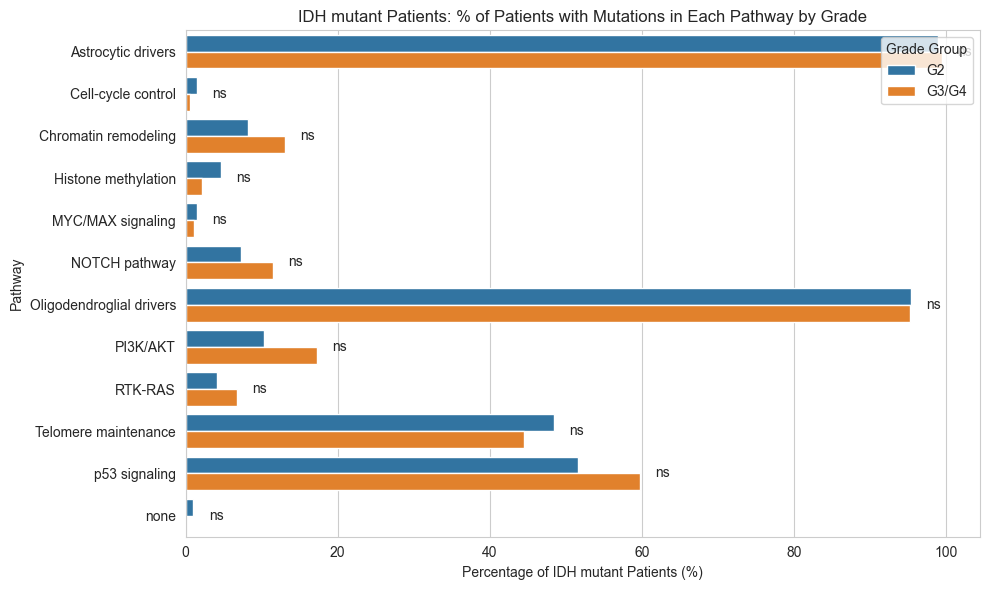

In [537]:
# 1. Subset to IDH Mutant patients
mut_df = clinical_mutations_pathways[clinical_mutations_pathways['IDH status'] == 'Mutant']

# 2. Unique Patient–Pathway–Grade rows
df_pp = mut_df[['Patient ID','Pathway','Neoplasm Histologic Grade']].drop_duplicates()

# 3. Map grades to G2 vs G3/G4
df_pp['Grade_Group'] = df_pp['Neoplasm Histologic Grade'] \
    .replace({'G2':'G2','G3':'G3/G4','G4':'G3/G4'})
df_pp['Grade_Group'] = pd.Categorical(df_pp['Grade_Group'],
                                      categories=['G2','G3/G4'],
                                      ordered=True)

# 4. Identify mutant patients with only 'none'
all_mut = set(df_pp['Patient ID'])
with_real = set(df_pp[df_pp['Pathway']!='none']['Patient ID'])
only_none = all_mut - with_real

# 5. Count per pathway × grade (excluding 'none')
counts = (
    df_pp[df_pp['Pathway']!='none']
      .groupby(['Pathway','Grade_Group'])['Patient ID']
      .nunique()
      .unstack(fill_value=0)
)

# 6. Add true 'none' counts per grade group
none_counts = {'G2':0,'G3/G4':0}
for pid in only_none:
    g = df_pp.loc[df_pp['Patient ID']==pid,'Grade_Group'].iloc[0]
    none_counts[g] += 1

counts.loc['none','G2']    = none_counts['G2']
counts.loc['none','G3/G4'] = none_counts['G3/G4']

# 7. Compute total WT patients per grade and percentages
grade_totals = df_pp.drop_duplicates(['Patient ID','Grade_Group']) \
                   .groupby('Grade_Group')['Patient ID'] \
                   .nunique()
percent = counts.div(grade_totals, axis=1) * 100

# 8. Fisher’s exact test per pathway
p_values = {}
for pw in counts.index:
    a = counts.loc[pw,'G2']
    b = grade_totals['G2'] - a
    c = counts.loc[pw,'G3/G4']
    d = grade_totals['G3/G4'] - c
    _, p = fisher_exact([[a,b],[c,d]])
    p_values[pw] = p

# 9. Melt and plot
plot_df = (percent
           .rename_axis('Pathway')
           .reset_index()
           .melt(id_vars='Pathway', var_name='Grade', value_name='Percentage'))

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=plot_df, x='Percentage', y='Pathway', hue='Grade', order=percent.index)

# annotate significance
for i, pw in enumerate(percent.index):
    p = p_values[pw]
    star = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
    x = percent.loc[pw].max() + 2
    ax.text(x, i, star, va='center')

ax.set_title('IDH mutant Patients: % of Patients with Mutations in Each Pathway by Grade')
ax.set_xlabel('Percentage of IDH mutant Patients (%)')
ax.set_ylabel('Pathway')
ax.legend(title='Grade Group', loc='upper right')
plt.tight_layout()
plt.show()


In [538]:
df = clinical_mutations_pathways.drop_duplicates(subset='Patient ID')

# Check for missing or bad values
print(df[['Patient ID','Overall Survival (Months)','Overall Survival Status','IDH status']].head(), "\n")
print("OS Months summary:\n", df['Overall Survival (Months)'].describe(), "\n")
print("Status values:", df['Overall Survival Status'].unique())
print("IDH groups:", df['IDH status'].value_counts())

       Patient ID  Overall Survival (Months) Overall Survival Status  \
0    TCGA-02-0003                        4.7              1:DECEASED   
43   TCGA-02-0033                        2.8              1:DECEASED   
65   TCGA-02-0047                       14.7              1:DECEASED   
111  TCGA-02-0055                        2.5              1:DECEASED   
154  TCGA-02-2470                       12.9              1:DECEASED   

    IDH status  
0           WT  
43          WT  
65          WT  
111         WT  
154         WT   

OS Months summary:
 count    745.000000
mean      19.102953
std       24.579807
min        0.000000
25%        5.000000
50%       11.300000
75%       21.300000
max      182.200000
Name: Overall Survival (Months), dtype: float64 

Status values: ['1:DECEASED' '0:LIVING' nan]
IDH groups: IDH status
Mutant    385
WT        360
Name: count, dtype: int64


**Exploring survival differences between patients with various mutations**

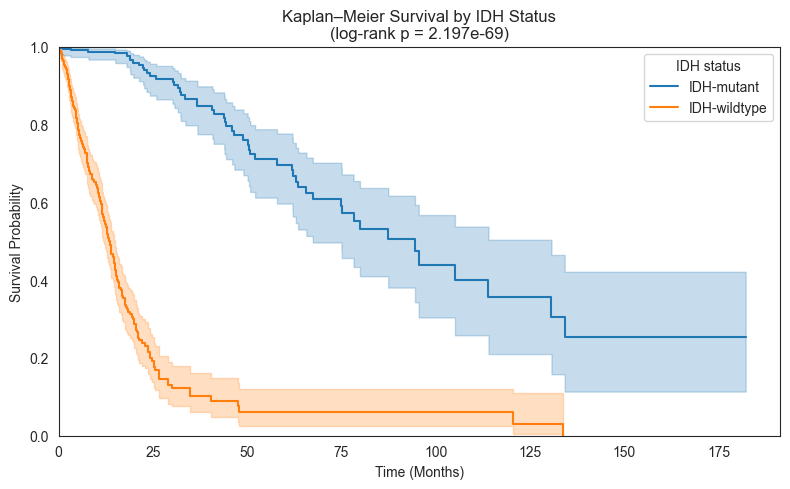

In [610]:
# — Style settings —
sns.set_style("white")    # white background, no grid
plt.rcParams['axes.grid'] = False

# — Step 1: Prepare DataFrame —
df = clinical_mutations_pathways.drop_duplicates(subset='Patient ID').copy()

# — Step 2: Drop missing survival data —
df = df[df['Overall Survival Status'].notnull() & df['Overall Survival (Months)'].notnull()]

# — Step 3: Parse event indicator (0/1) from "0:LIVING"/"1:DECEASED" —
df['event'] = (
    df['Overall Survival Status']
      .astype(str)
      .str.extract(r'^(\d+)')
      .astype(float)
      .astype(int)
)

# — Step 4: Numeric survival time in months —
df['OS_months'] = pd.to_numeric(df['Overall Survival (Months)'], errors='coerce')
df = df[df['OS_months'].notnull()]

# — Step 5: Drop missing IDH status —
df = df[df['IDH status'].notnull()]

# — Step 6: Split into IDH‐mutant vs WT groups —
mutant = df[df['IDH status']=='Mutant']
wt     = df[df['IDH status']=='WT']

# — Step 7: Perform log‐rank test —
lr_results = logrank_test(
    mutant['OS_months'], 
    wt['OS_months'], 
    event_observed_A=mutant['event'], 
    event_observed_B=wt['event']
)
p_value = lr_results.p_value

# — Step 8: Fit Kaplan–Meier curves —
kmf_mut = KaplanMeierFitter()
kmf_wt  = KaplanMeierFitter()

fig, ax = plt.subplots(figsize=(8,5))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

kmf_mut.fit(mutant['OS_months'], event_observed=mutant['event'], label='IDH-mutant')
kmf_wt.fit(   wt['OS_months'], event_observed=wt['event'],    label='IDH-wildtype')

kmf_mut.plot_survival_function(ax=ax, ci_show=True)
kmf_wt.plot_survival_function(ax=ax, ci_show=True)

# — Step 9: Labels & legend —
ax.set_xlim(left=0)
ax.set_ylim(0,1)
ax.set_xlabel('Time (Months)')
ax.set_ylabel('Survival Probability')
ax.set_title(f'Kaplan–Meier Survival by IDH Status\n(log-rank p = {p_value:.3e})')
ax.legend(title='IDH status')

plt.tight_layout()
plt.show()


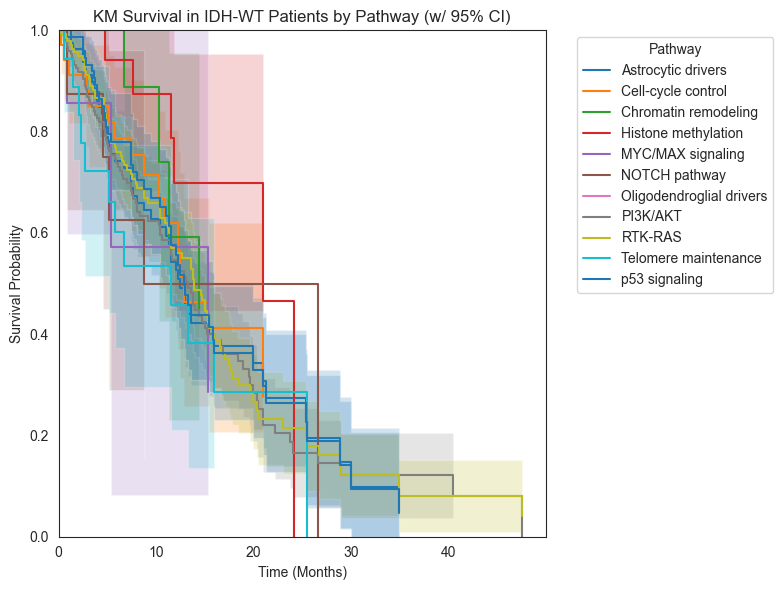

In [540]:
# 1) Load & clean as before
df = clinical_mutations_pathways.copy()
df = df[
    df['Overall Survival Status'].notnull() &
    df['Overall Survival (Months)'].notnull()
].copy()
df['event'] = (
    df['Overall Survival Status']
      .astype(str)
      .str.extract(r'^(\d+)')
      .astype(int)
)
df['OS_months'] = pd.to_numeric(df['Overall Survival (Months)'], errors='coerce')
df = df.dropna(subset=['OS_months', 'event', 'IDH status'])

# 2) Filter to IDH-WT and patients with ≥1 real pathway
df_wt = df[df['IDH status'] == 'WT'].copy()

# build patient‐level surv table
surv = (
    df_wt
    .drop_duplicates(subset='Patient ID')[['Patient ID','OS_months','event']]
    .set_index('Patient ID')
)

# gather per‐patient pathways, drop “none”
pt_paths = (
    df_wt.groupby('Patient ID')['Pathway']
         .unique()
         .apply(lambda arr: [p for p in arr if str(p).lower() != 'none'])
)
pt_paths = pt_paths[pt_paths.apply(len) > 0]
pathways = sorted({p for paths in pt_paths for p in paths})

# z‐score for 95% CI
z = norm.ppf(0.975)

plt.figure(figsize=(8,6))

for pathway in pathways:
    # subset to patients with this pathway
    pats = pt_paths[pt_paths.apply(lambda L: pathway in L)].index
    sub  = surv.loc[surv.index.isin(pats)]
    times, events = sub['OS_months'].values, sub['event'].values

    # find unique event times >0
    event_times = np.sort(np.unique(times[events == 1]))
    event_times = event_times[event_times > 0]

    # containers
    surv_t  = [0.0]
    surv_p  = [1.0]
    var_acc = []  # Greenwood incremental terms
    prev     = 1.0

    # compute step and variance terms
    for t in event_times:
        n_risk = (times >= t).sum()
        d      = ((times == t) & (events == 1)).sum()
        prev  *= (1 - d / n_risk)
        surv_t.append(t)
        surv_p.append(prev)
        var_acc.append(d / (n_risk * (n_risk - d)))

    # variance and CIs
    cumvar = np.cumsum(var_acc)
    vars_t = np.array(surv_p[1:])**2 * cumvar
    # prepend var=0 for time=0
    vars_all = np.concatenate([[0.0], vars_t])
    se_all   = np.sqrt(vars_all)
    upper    = np.minimum(1.0, np.array(surv_p) + z * se_all)
    lower    = np.maximum(0.0, np.array(surv_p) - z * se_all)

    # plot curve + CI band
    plt.step(surv_t, surv_p, where='post', label=pathway)
    plt.fill_between(surv_t, lower, upper, step='post', alpha=0.2)

# format
plt.xlim(0)
plt.ylim(0,1)
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.title('KM Survival in IDH-WT Patients by Pathway (w/ 95% CI)')
plt.legend(title='Pathway', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()



In [541]:
# 1) Copy the original DataFrame
df = clinical_mutations_pathways.copy()

# 2) Filter to IDH-WT patients
df_wt = df[df['IDH status'] == 'WT']

# 3) Aggregate one row per patient
agg = (
    df_wt
    .groupby('Patient ID')
    .agg({
        'Pathway': lambda paths: list(set(paths)),
        'Overall Survival (Months)': 'first',
        'Overall Survival Status': 'first'
    })
    .reset_index()
)

# 4) Keep only patients with ≥1 non-“none” pathway
agg['real_pathways'] = agg['Pathway'].apply(
    lambda lst: [p for p in lst if str(p).lower() != 'none']
)
agg = agg[agg['real_pathways'].apply(len) > 0]

# 5) Format the pathway lists as comma-separated strings
agg['Pathways'] = agg['real_pathways'].apply(lambda lst: ", ".join(lst))

# 6) Select the final columns
result = agg[
    ['Patient ID', 'Pathways', 'Overall Survival (Months)', 'Overall Survival Status']
]

# 7) Save to CSV for Excel
output_filename = 'WT_patients_real_pathways_survival.csv'
result.to_csv(output_filename, index=False)

print(f"Wrote {len(result)} rows to {output_filename}")


Wrote 269 rows to WT_patients_real_pathways_survival.csv


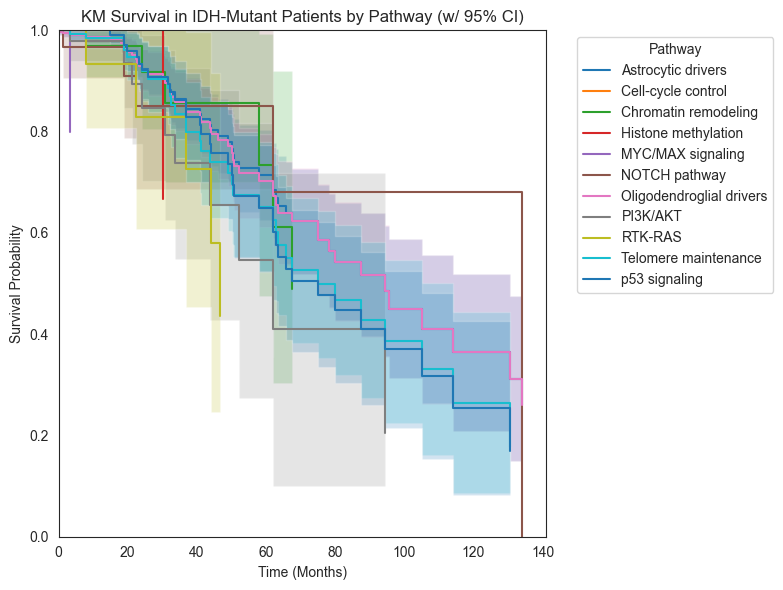

In [542]:
# — 1) Load & clean just as before
df = clinical_mutations_pathways.copy()
df = df[
    df['Overall Survival Status'].notnull() &
    df['Overall Survival (Months)'].notnull()
].copy()
df['event'] = (
    df['Overall Survival Status']
      .astype(str)
      .str.extract(r'^(\d+)')  # grab the leading number
      .astype(int)
)
df['OS_months'] = pd.to_numeric(df['Overall Survival (Months)'], errors='coerce')
df = df.dropna(subset=['OS_months', 'event', 'IDH status'])

# — 2) Filter to IDH-Mutant and keep only patients with ≥1 real pathway
df_mut = df[df['IDH status'] == 'Mutant'].copy()
pt_paths = (
    df_mut.groupby('Patient ID')['Pathway']
          .unique()
          .apply(lambda arr: [p for p in arr if str(p).lower() != 'none'])
)
pt_paths = pt_paths[pt_paths.apply(len) > 0]

# — 3) Build per-patient survival table
surv = (
    df_mut
    .drop_duplicates(subset='Patient ID')[['Patient ID','OS_months','event']]
    .set_index('Patient ID')
)

# — 4) Determine real pathways
pathways = sorted({p for paths in pt_paths for p in paths})

# z-score for 95% CI
z = norm.ppf(0.975)

plt.figure(figsize=(8,6))

for pathway in pathways:
    pats = pt_paths[pt_paths.apply(lambda L: pathway in L)].index
    sub  = surv.loc[surv.index.isin(pats)]
    times, events = sub['OS_months'].values, sub['event'].values

    # 5) Compute KM steps + Greenwood variance terms
    event_times = np.sort(np.unique(times[events == 1]))
    event_times = event_times[event_times > 0]
    surv_t  = [0.0]
    surv_p  = [1.0]
    var_acc = []
    prev    = 1.0

    for t in event_times:
        n_risk = (times >= t).sum()
        d      = ((times == t) & (events == 1)).sum()
        prev  *= (1 - d / n_risk)
        surv_t.append(t)
        surv_p.append(prev)
        var_acc.append(d / (n_risk * (n_risk - d)))

    cumvar   = np.cumsum(var_acc)
    vars_t   = np.array(surv_p[1:])**2 * cumvar
    vars_all = np.concatenate([[0.0], vars_t])
    se_all   = np.sqrt(vars_all)
    upper    = np.minimum(1.0, np.array(surv_p) + z * se_all)
    lower    = np.maximum(0.0, np.array(surv_p) - z * se_all)

    # 6) Plot curve + CI
    plt.step(surv_t, surv_p, where='post', label=pathway)
    plt.fill_between(surv_t, lower, upper, step='post', alpha=0.2)

# — 7) Final formatting
plt.xlim(0)
plt.ylim(0,1)
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.title('KM Survival in IDH-Mutant Patients by Pathway (w/ 95% CI)')
plt.legend(title='Pathway', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()



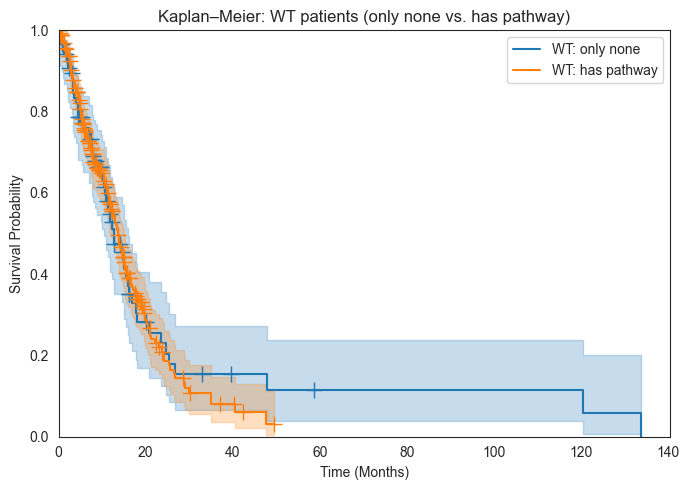

In [543]:
# 1) Prep & parse
df = clinical_mutations_pathways.copy()

# keep only rows with valid OS time & status
df = df[
    df['Overall Survival Status'].notnull() &
    df['Overall Survival (Months)'].notnull()
].copy()

# extract numeric event flag from "1:DECEASED"/"0:LIVING"
df['event'] = (
    df['Overall Survival Status']
      .astype(str)
      .str.extract(r'^(\d+)')
      .astype(int)
)

# numeric survival time
df['time'] = pd.to_numeric(df['Overall Survival (Months)'], errors='coerce')

# drop any bad rows
df = df.dropna(subset=['time', 'event', 'IDH status', 'Pathway'])

# 2) IDH-WT only
df_wt = df[df['IDH status'] == 'WT'].copy()

# 3) Determine which patients are “only none” vs “has pathway”
#    Group all pathways per patient
paths = (
    df_wt
    .groupby('Patient ID')['Pathway']
    .unique()
    .apply(lambda arr: [p.lower() for p in arr])
)

# Boolean series
only_none = paths.apply(lambda lst: all(p == 'none' for p in lst))
has_path  = paths.apply(lambda lst: any(p != 'none' for p in lst))

# 4) Build two patient‐level DataFrames
def build_surv_df(patient_ids):
    sub = df_wt[df_wt['Patient ID'].isin(patient_ids)]
    # take one row per patient (use first; time/event same for all)
    surv = (
        sub
        .drop_duplicates(subset='Patient ID')
        .set_index('Patient ID')[['time','event']]
    )
    return surv

surv_only_none = build_surv_df(only_none[only_none].index)
surv_has_path  = build_surv_df(has_path[has_path].index)

# 5) Fit & plot with lifelines
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

plt.figure(figsize=(7,5))
kmf1.fit(
    durations=surv_only_none['time'],
    event_observed=surv_only_none['event'],
    label='WT: only none'
)
kmf1.plot_survival_function(ci_show=True, show_censors=True)

kmf2.fit(
    durations=surv_has_path['time'],
    event_observed=surv_has_path['event'],
    label='WT: has pathway'
)
kmf2.plot_survival_function(ci_show=True, show_censors=True)

plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.title('Kaplan–Meier: WT patients (only none vs. has pathway)')
plt.xlim(0)
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.show()



— CoxPH Model Summary —


<lifelines.CoxPHFitter: fitted with 744 total observations, 476 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 744
number of events observed = 268
   partial log-likelihood = -1299.24
         time fit was run = 2025-07-03 13:50:06 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
Diagnosis Age                 0.05      1.05      0.01            0.03            0.06                1.03                1.06
TMB (nonsynonymous)          -0.22      0.81      0.17           -0.55            0.12                0.58                1.12
Astrocytic drivers           -0.39      0.68      0.28           -0.93            0.15                0.39                1.16
Cell-cycle control           -0.37      0.69      0.28           -0.91            0.18                0.40                1.19
Chromatin remodeling         -0.67      0.51      0.34           -1.34            0.00                0.26                1.00
Histone methylation          -0.45      0.64      0.41           -1.24            0.35                0.29                1.42
MYC/MAX signaling             0.10      1.10      0.53           -0.95            1.14                0.39                3.14
NOTCH pathway                -0.25      0.78      0.34           -0.92            0.42                0.40                1.52
Oligodendroglial drivers     -0.49      0.61      0.58           -1.62            0.64                0.20                1.90
PI3K/AKT                      0.17      1.19      0.14           -0.10            0.45                0.90                1.56
RTK-RAS                       0.09      1.09      0.15           -0.20            0.38                0.82                1.46
Telomere maintenance          0.81      2.25      0.24            0.35            1.27                1.41                3.57
p53 signaling                 0.27      1.31      0.25           -0.23            0.76                0.80                2.14
IDH status_WT                 0.96      2.60      0.62           -0.26            2.18                0.77                8.82
Sex_Male                      0.21      1.24      0.14           -0.05            0.48                0.95                1.61
Neoplasm Histologic Grade_G3  0.91      2.49      0.27            0.38            1.44                1.47                4.24
Neoplasm Histologic Grade_G4  1.26      3.53      0.31            0.66            1.86                1.93                6.45

                              cmp to     z      p  -log2(p)
covariate                                                  
Diagnosis Age                   0.00  7.19 <0.005     40.52
TMB (nonsynonymous)             0.00 -1.27   0.20      2.29
Astrocytic drivers              0.00 -1.42   0.16      2.68
Cell-cycle control              0.00 -1.33   0.18      2.44
Chromatin remodeling            0.00 -1.95   0.05      4.27
Histone methylation             0.00 -1.10   0.27      1.88
MYC/MAX signaling               0.00  0.18   0.85      0.23
NOTCH pathway                   0.00 -0.73   0.46      1.11
Oligodendroglial drivers        0.00 -0.85   0.39      1.34
PI3K/AKT                        0.00  1.23   0.22      2.18
RTK-RAS                         0.00  0.58   0.56      0.84
Telomere maintenance            0.00  3.42 <0.005     10.65
p53 signaling                   0.00  1.06   0.29      1.79
IDH status_WT                   0.00  1.54   0.12      3.01
Sex_Male                        0.00  1.56   0.12      3.08
Neoplasm Histologic Grade_G3    0.00  3.37 <0.005     10.39
Neoplasm Histologic Grade_G4    0.00  4.10 <0.005     14.58
---
Concordance = 0.84
Partial AIC = 2632.47
log-likelihood ratio test = 411.28 on 17 df


Concordance index: 0.843


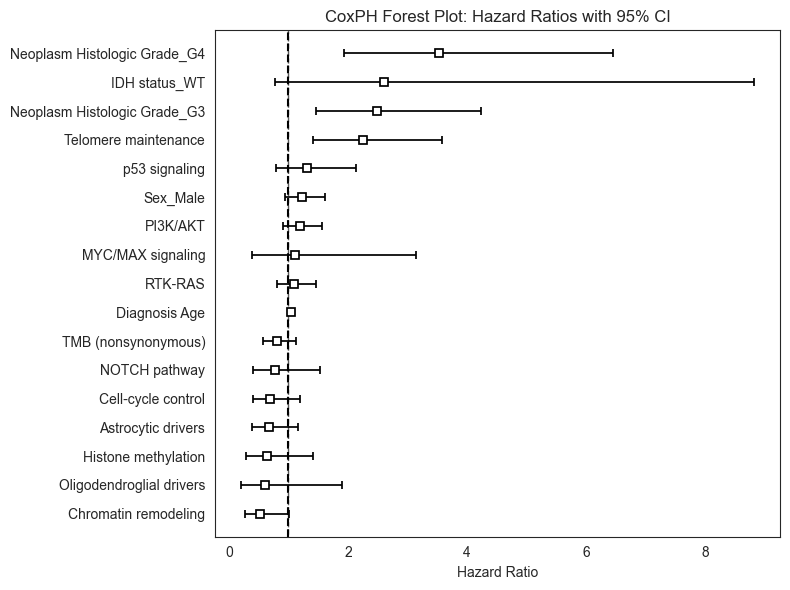

In [544]:
# 1) Load & parse survival data
df = clinical_mutations_pathways.copy()

# Keep only rows with non-null survival time & status
df = df[
    df['Overall Survival (Months)'].notnull() &
    df['Overall Survival Status'].notnull() &
    df['Neoplasm Histologic Grade'].notnull()  # ensure grade is present
].copy()

# Extract numeric event flag (1=DECEASED, 0=LIVING)
df['event'] = (
    df['Overall Survival Status']
      .astype(str)
      .str.extract(r'^(\d+)')
      .astype(int)
)

# Convert survival time to numeric and rename for convenience
df['time'] = pd.to_numeric(df['Overall Survival (Months)'], errors='coerce')
df = df.dropna(subset=['time', 'event'])

# 2) Build a patient-level clinical table
clin = (
    df
    .drop_duplicates(subset='Patient ID')
    .set_index('Patient ID')
    [[
      'time', 'event',
      'IDH status', 'Sex',
      'Diagnosis Age', 'TMB (nonsynonymous)',
      'Neoplasm Histologic Grade'
    ]]
)

# 3) Build binary pathway mutation flags per patient (excluding 'none')
pt_paths = (
    df
    .groupby('Patient ID')['Pathway']
    .unique()
    .apply(lambda arr: [p for p in arr if p.lower() != 'none'])
)

all_paths = sorted({p for paths in pt_paths for p in paths})

path_df = pd.DataFrame(index=pt_paths.index)
for p in all_paths:
    path_df[p] = pt_paths.apply(lambda lst: int(p in lst))

# 4) Merge clinical data with pathway flags
data = clin.join(path_df, how='inner').reset_index(drop=True)

# 5) One-hot encode categorical covariates: IDH status, Sex, and Histologic Grade
data = pd.get_dummies(
    data,
    columns=['IDH status', 'Sex', 'Neoplasm Histologic Grade'],
    drop_first=True
)

# 6) Ensure all model columns are numeric & drop any rows with missing
covariates = [
    'time', 'event', 'Diagnosis Age', 'TMB (nonsynonymous)'
] + all_paths + \
    [c for c in data.columns if c.startswith('IDH status_') or
                               c.startswith('Sex_') or
                               c.startswith('Neoplasm Histologic Grade_')]

for col in covariates:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data = data.dropna(subset=covariates)

# 7) Fit the Cox proportional-hazards model
cph = CoxPHFitter()
cph.fit(
    data,
    duration_col='time',
    event_col='event'
)

# 8) Print out key metrics
print("\n— CoxPH Model Summary —")
cph.print_summary()               # coefficients, CI, p-values
print(f"\nConcordance index: {cph.concordance_index_:.3f}")

# 9) Plot the forest of hazard ratios with 95% CIs
plt.figure(figsize=(8, 6))
ax = cph.plot(hazard_ratios=True)
ax.set_title("CoxPH Forest Plot: Hazard Ratios with 95% CI")
ax.set_xlabel("Hazard Ratio")
ax.axvline(1.0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


Reading the Cox hazard ratios plot feature by feature: 
- Diagnosis Age: HR = 1.05 (95% CI 1.03–1.06), p < 0.005. Each additional year of age at diagnosis increases the hazard of death by 5%. Highly significant.

- TMB (nonsynonymous): HR = 0.81 (95% CI 0.58–1.12), p = 0.20. A higher nonsynonymous tumor mutational burden trends toward a 19% lower hazard, but the CI crosses 1 and p > 0.05

- Astrocytic drivers: HR = 0.68 (95% CI 0.39–1.16), p = 0.16. Patients with mutations in astrocytic driver genes have a 32% lower hazard, but not statistically significant.

- Cell-cycle control: HR = 0.69 (95% CI 0.40–1.19), p = 0.18. Suggests a 31% reduction in hazard for cell-cycle pathway mutants, but CI overlaps 1 → not significant.

- Chromatin remodeling: HR = 0.51 (95% CI 0.26–1.00), p = 0.05. Circa 49% reduction in hazard; the upper CI edge is exactly 1 and p=0.05 → borderline significant protective effect.

- Histone methylation: HR = 0.64 (95% CI 0.29–1.42), p = 0.27. Non‐significant trend toward protection (36% lower hazard).

- MYC/MAX signaling: HR = 1.10 (95% CI 0.39–3.14), p = 0.85. Essentially no effect (HR≈1), very wide CI → not significant.

- NOTCH pathway: HR = 0.78 (95% CI 0.40–1.52), p = 0.46. A non‐significant 22% reduction in hazard.

- Oligodendroglial drivers: HR = 0.61 (95% CI 0.20–1.90), p = 0.39. Non‐significant trend toward protection, but wide CI.

- PI3K/AKT: HR = 1.19 (95% CI 0.90–1.56), p = 0.22, A 19% higher hazard, but CI includes 1 → not significant.

- RTK-RAS: HR = 1.09 (95% CI 0.82–1.46), p = 0.56, Essentially no effect, not significant.

- Telomere maintenance: HR = 2.25 (95% CI 1.41–3.57), p < 0.005. Patients with telomere‐maintenance pathway mutations have more than double the hazard. Highly significant risk factor.

- p53 signaling: HR = 1.31 (95% CI 0.80–2.14), p = 0.29. A 31% higher hazard, but CI crosses 1 → not significant.

- IDH status_WT: HR = 2.60 (95% CI 0.77–8.82), p = 0.12. Wild‐type IDH has 2.6× the hazard versus mutant, but wide CI and p > 0.05 → not statistically significant here.

- Sex_Male: HR = 1.24 (95% CI 0.95–1.61), p = 0.12, Males trend toward a 24% higher hazard, but not significant.

- Neoplasm Histologic Grade_G3: HR = 2.49 (95% CI 1.47–4.24), p < 0.005. Grade 3 tumors have ~2.5× the hazard compared to Grade II. Highly significant.

- Neoplasm Histologic Grade_G4: HR = 3.53 (95% CI 1.93–6.45), p < 0.005. Grade 4 tumors carry ~3.5× the hazard versus Grade II. Highly significant.

When two (or more) predictors are highly correlated, each “soaks up” the same signal. That inflates standard errors (se(coef)) and makes it harder for either to reach significance. I want to check VIFs (variance inflation factors) on numeric covariates and even on binary pathway flags to see if any are collinear. If any VIF > 5 or 10, cwe should drop or combine those features.


In [545]:
# Assume data is your final DataFrame used for Cox (with all numeric covariates,
# including one-hot columns, and excluding any ID columns).

# 1) Identify the predictor columns (exclude survival/time cols)
predictors = [c for c in data.columns if c not in ['time','event']]

# 2) Ensure they’re floats
X = data[predictors].astype(float)

# 3) Compute VIF for each predictor
vif_df = pd.DataFrame({
    'feature': predictors,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# 4) Sort and save
vif_df = vif_df.sort_values('VIF', ascending=False)
vif_df.to_csv('cox_model_vifs.csv', index=False)

print("VIFs saved to cox_model_vifs.csv")
print(vif_df)




VIFs saved to cox_model_vifs.csv
                         feature        VIF
0                  Diagnosis Age  18.322950
13                 IDH status_WT  13.893106
8       Oligodendroglial drivers  10.082358
2             Astrocytic drivers   9.879707
16  Neoplasm Histologic Grade_G4   5.782911
1            TMB (nonsynonymous)   4.784921
12                 p53 signaling   3.913532
14                      Sex_Male   2.450131
11          Telomere maintenance   2.418182
15  Neoplasm Histologic Grade_G3   2.319009
10                       RTK-RAS   1.635240
9                       PI3K/AKT   1.606081
7                  NOTCH pathway   1.148531
3             Cell-cycle control   1.145179
4           Chromatin remodeling   1.133556
5            Histone methylation   1.102586
6              MYC/MAX signaling   1.049816


In order to improve the model we could merge Oligodendroglial drivers (VIF ~10) and Astrocytic drivers (VIF ~9.9), into a single “glial_drivers” flag. Also we can drop TMB, Sex, or MYC/MAX, which were never close to significance.

Then refit an unpenalized Cox on the reduced set. 


— Reduced CoxPH Model Summary —


<lifelines.CoxPHFitter: fitted with 744 total observations, 476 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 744
number of events observed = 268
   partial log-likelihood = -1302.25
         time fit was run = 2025-07-03 13:50:26 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
Diagnosis Age                 0.04      1.05      0.01            0.03            0.06                1.03                1.06
Cell-cycle control           -0.31      0.73      0.27           -0.85            0.22                0.43                1.25
Chromatin remodeling         -0.68      0.51      0.34           -1.35           -0.01                0.26                0.99
Histone methylation          -0.50      0.61      0.39           -1.26            0.26                0.28                1.30
NOTCH pathway                -0.17      0.84      0.34           -0.84            0.50                0.43                1.64
PI3K/AKT                      0.12      1.13      0.14           -0.14            0.39                0.87                1.48
RTK-RAS                       0.07      1.07      0.14           -0.21            0.35                0.81                1.42
Telomere maintenance          0.76      2.13      0.23            0.30            1.21                1.35                3.36
p53 signaling                 0.28      1.32      0.25           -0.21            0.76                0.81                2.14
IDH status_WT                 1.32      3.74      0.31            0.70            1.93                2.02                6.91
Neoplasm Histologic Grade_G3  0.85      2.34      0.27            0.33            1.37                1.39                3.95
Neoplasm Histologic Grade_G4  1.17      3.22      0.30            0.57            1.76                1.77                5.83
glial_drivers                -0.43      0.65      0.27           -0.96            0.10                0.38                1.11

                              cmp to     z      p  -log2(p)
covariate                                                  
Diagnosis Age                   0.00  7.22 <0.005     40.84
Cell-cycle control              0.00 -1.15   0.25      1.99
Chromatin remodeling            0.00 -1.98   0.05      4.40
Histone methylation             0.00 -1.29   0.20      2.35
NOTCH pathway                   0.00 -0.50   0.62      0.69
PI3K/AKT                        0.00  0.91   0.37      1.45
RTK-RAS                         0.00  0.49   0.62      0.68
Telomere maintenance            0.00  3.24 <0.005      9.70
p53 signaling                   0.00  1.11   0.26      1.92
IDH status_WT                   0.00  4.20 <0.005     15.21
Neoplasm Histologic Grade_G3    0.00  3.19 <0.005      9.45
Neoplasm Histologic Grade_G4    0.00  3.85 <0.005     13.03
glial_drivers                   0.00 -1.58   0.11      3.13
---
Concordance = 0.84
Partial AIC = 2630.50
log-likelihood ratio test = 405.24 on 13 df
-log2(p) of ll-ratio test = 258.31


Concordance index: 0.842


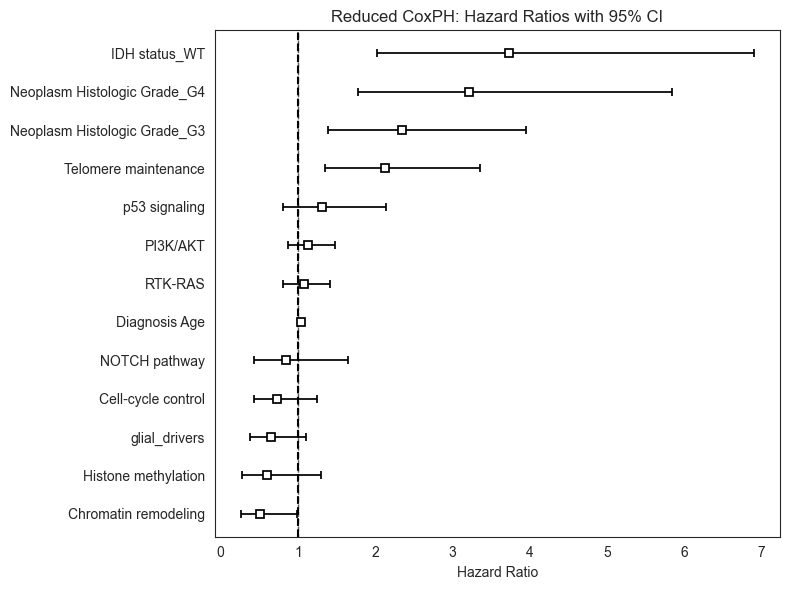

In [546]:
# 1) Load & parse survival data
df = clinical_mutations_pathways.copy()

# Keep only rows with non-null survival time & status
df = df[
    df['Overall Survival (Months)'].notnull() &
    df['Overall Survival Status'].notnull()
].copy()

# Extract numeric event flag (1=DECEASED, 0=LIVING)
df['event'] = (
    df['Overall Survival Status']
      .astype(str)
      .str.extract(r'^(\d+)')
      .astype(int)
)

# Convert survival time to numeric
df['time'] = pd.to_numeric(df['Overall Survival (Months)'], errors='coerce')
df = df.dropna(subset=['time', 'event'])

# 2) Build patient-level clinical table
clin = (
    df
    .drop_duplicates(subset='Patient ID')
    .set_index('Patient ID')
    [[
        'time', 'event',
        'IDH status', 'Sex',
        'Diagnosis Age', 'TMB (nonsynonymous)',
        'Neoplasm Histologic Grade'
    ]]
)

# 3) Build pathway flags (excluding 'none')
pt_paths = (
    df
    .groupby('Patient ID')['Pathway']
    .unique()
    .apply(lambda arr: [p for p in arr if p.lower() != 'none'])
)
all_paths = sorted({p for paths in pt_paths for p in paths})
path_df = pd.DataFrame(index=pt_paths.index)
for p in all_paths:
    path_df[p] = pt_paths.apply(lambda lst: int(p in lst))

# 4) Merge clinical & pathway flags
data = clin.join(path_df, how='inner').reset_index(drop=True)

# 5) One-hot encode categorical features
data = pd.get_dummies(
    data,
    columns=['IDH status', 'Sex', 'Neoplasm Histologic Grade'],
    drop_first=True
)

# 6) Merge astrocytic + oligodendroglial into glial_drivers
data['glial_drivers'] = (
    data.get('Astrocytic drivers', 0) |
    data.get('Oligodendroglial drivers', 0)
).astype(int)
data = data.drop(columns=['Astrocytic drivers', 'Oligodendroglial drivers'], errors='ignore')

# 7) Drop the non-significant features: TMB, Sex_Male, MYC/MAX signaling
drop_cols = ['TMB (nonsynonymous)', 'Sex_Male', 'MYC/MAX signaling']
data = data.drop(columns=[c for c in drop_cols if c in data.columns], errors='ignore')

# 8) Ensure all model columns are numeric and drop NaNs
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data = data.dropna()

# 9) Fit the reduced, unpenalized Cox model
cph = CoxPHFitter()
cph.fit(data, duration_col='time', event_col='event')

# 10) Print the model summary and concordance index
print("\n— Reduced CoxPH Model Summary —")
cph.print_summary()
print(f"\nConcordance index: {cph.concordance_index_:.3f}")

# 11) Plot hazard ratios with 95% CI
plt.figure(figsize=(8,6))
ax = cph.plot(hazard_ratios=True)
ax.set_title("Reduced CoxPH: Hazard Ratios with 95% CI")
ax.set_xlabel("Hazard Ratio")
ax.axvline(1.0, color='black', linestyle='--')
plt.grid(False)
plt.tight_layout()
plt.show()


## **Machine learning analysis**

### **Feature selection: Selecting 20 most frequently mutated genes**

Total number of unique patients: 745
Number of patients without mutations in any of the top 20 genes: 76


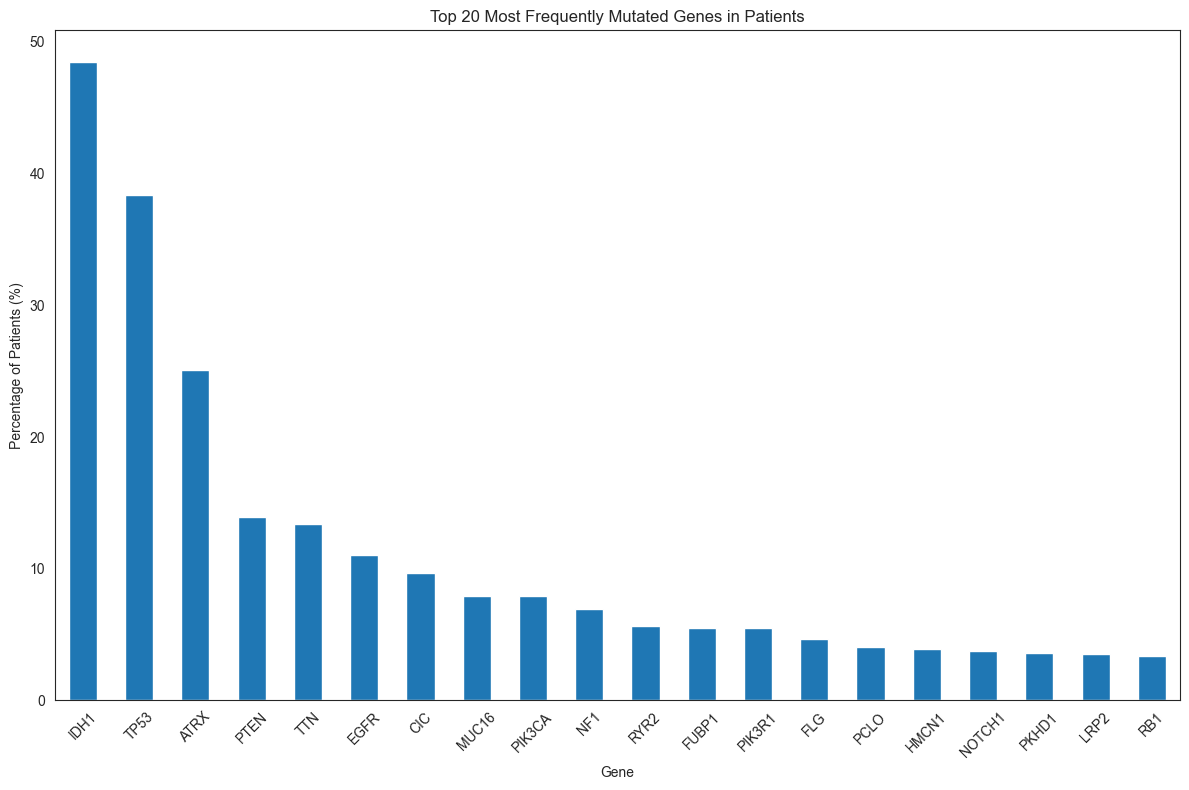

In [547]:
# Step 1: Count unique patients for each gene
gene_patient_counts = clinical_mutations_pathways.groupby('Hugo_Symbol')['Patient ID'].nunique()

# Step 2: Calculate the percentage of patients with mutations in each gene
total_unique_patients = clinical_mutations_pathways['Patient ID'].nunique()
gene_patient_percentages = (gene_patient_counts / total_unique_patients) * 100

# Step 3: Select the top 30 most frequently mutated genes
top_20_genes = gene_patient_percentages.nlargest(20).index

# Step 4: Identify unique patients who have mutations in any of the top 20 genes
patients_with_top_20_genes = clinical_mutations_pathways[clinical_mutations_pathways['Hugo_Symbol'].isin(top_20_genes)]['Patient ID'].unique()
unique_patients_with_top_20_genes = len(set(patients_with_top_20_genes))

# Step 5: Calculate the number of patients without mutations in any of the top 20 genes
patients_without_top_20_genes = total_unique_patients - unique_patients_with_top_20_genes

# Display results
print(f"Total number of unique patients: {total_unique_patients}")
print(f"Number of patients without mutations in any of the top 20 genes: {patients_without_top_20_genes}")

# Step 6: Plotting the top 20 genes by percentage of patients with mutations
top_20_percentages = gene_patient_percentages[top_20_genes]

plt.figure(figsize=(12, 8))
top_20_percentages.plot(kind='bar')
plt.xlabel("Gene")
plt.ylabel("Percentage of Patients (%)")
plt.title("Top 20 Most Frequently Mutated Genes in Patients")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We chose top 20 genes as features, now we are going to chose 'Diagnosis Age', 'Sex', 'TMB (nonsynonymous)', 'Pan-Glioma DNA Methylation Cluster', 'Neoplasm Histologic Type Name', 'Neoplasm Histologic Grade' for clustering analysis

In [548]:
# Filter clinical_mutations_pathways to include only rows with the top 20 genes, while retaining all patients
top_20_mutations_df = clinical_mutations_pathways[clinical_mutations_pathways['Hugo_Symbol'].isin(top_20_genes)]
all_patients_df = clinical_mutations_pathways[['Patient ID']].drop_duplicates()
top_20_encoded_df = all_patients_df.merge(top_20_mutations_df, on='Patient ID', how='left')

# One-hot encode the presence of each of the top 20 genes for all patients
for gene in top_20_genes:
    top_20_encoded_df[gene] = (top_20_encoded_df['Hugo_Symbol'] == gene).astype(int)

# Remove columns not needed for analysis
top_20_encoded_df = top_20_encoded_df.drop(columns=['Hugo_Symbol', 'Variant_Classification', 'Tumor_Sample_Barcode'])

# Display the resulting DataFrame for verification
print("Top 20 one-hot encoded DataFrame with all patients retained:")
print(top_20_encoded_df.head())

Top 20 one-hot encoded DataFrame with all patients retained:
     Patient ID        Sample ID             Pathway  Diagnosis Age   Sex  \
0  TCGA-02-0003  TCGA-02-0003-01             RTK-RAS           50.0  Male   
1  TCGA-02-0003  TCGA-02-0003-01            PI3K/AKT           50.0  Male   
2  TCGA-02-0003  TCGA-02-0003-01  Astrocytic drivers           50.0  Male   
3  TCGA-02-0003  TCGA-02-0003-01       p53 signaling           50.0  Male   
4  TCGA-02-0003  TCGA-02-0003-01  Astrocytic drivers           50.0  Male   

   TMB (nonsynonymous) Pan-Glioma DNA Methylation Cluster  \
0             1.366667                               LGm5   
1             1.366667                               LGm5   
2             1.366667                               LGm5   
3             1.366667                               LGm5   
4             1.366667                               LGm5   

  Neoplasm Histologic Type Name Neoplasm Histologic Grade  \
0                  glioblastoma                 

In [549]:
# Save the cleaned DataFrame
top_20_encoded_df.to_csv('top_20_encoded_df.csv', index=False)

In [550]:
# Df to go back to after clustering
merged_before_norm_df = top_20_encoded_df.copy()

Check NaN values in the dataset

In [551]:
# Group by 'Patient ID' to get unique patient entries
unique_patients_df = merged_before_norm_df.groupby('Patient ID').first()

# Count NaNs in each column
nan_counts = unique_patients_df.isnull().sum()
print("Count of NaNs in each column:")
print(nan_counts)

# Display the unique patient count after grouping
total_unique_patients = unique_patients_df.shape[0]
print(f"\nTotal Unique Patient Count: {total_unique_patients}")

# Check unique counts in 'Sex' after grouping
sex_distribution = unique_patients_df['Sex'].value_counts()
print("\nSex Distribution:")
print(sex_distribution)


Count of NaNs in each column:
Sample ID                              76
Pathway                                76
Diagnosis Age                          76
Sex                                    76
TMB (nonsynonymous)                    76
Pan-Glioma DNA Methylation Cluster    116
Neoplasm Histologic Type Name          76
Neoplasm Histologic Grade              76
Overall Survival (Months)              76
Overall Survival Status                77
IDH status                             76
IDH1                                    0
TP53                                    0
ATRX                                    0
PTEN                                    0
TTN                                     0
EGFR                                    0
CIC                                     0
MUC16                                   0
PIK3CA                                  0
NF1                                     0
RYR2                                    0
FUBP1                                   0
PIK3

### **Descriptive stats on the dataset after dropping NaN**

Total Unique Patient Count: 629

Sex Distribution:
Sex
Male      366
Female    263
Name: count, dtype: int64

Age Distribution Statistics:
count    629.000000
mean      49.128776
std       15.691115
min       14.000000
25%       36.000000
50%       49.000000
75%       61.000000
max       89.000000
Name: Diagnosis Age, dtype: float64

Neoplasm Histologic Type Distribution:
Neoplasm Histologic Type Name
glioblastoma         205
astrocytoma          159
oligodendroglioma    157
oligoastrocytoma     108
Name: count, dtype: int64

Neoplasm Histologic Grade Distribution:
Neoplasm Histologic Grade
G3    228
G4    205
G2    196
Name: count, dtype: int64


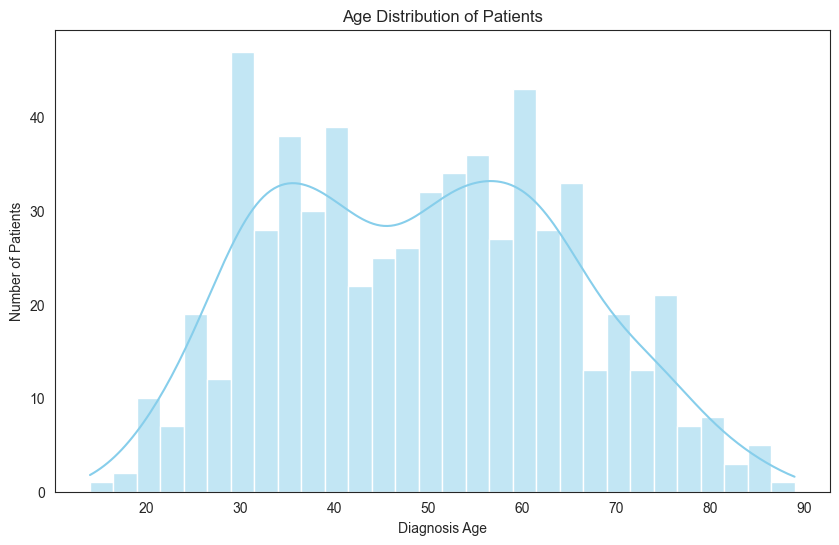

In [552]:
# Drop 'Sample ID' column and rows with NaNs in 'Pan-Glioma DNA Methylation Cluster'
cleaned_df = merged_before_norm_df.drop(columns=['Sample ID']).dropna(subset=['Pan-Glioma DNA Methylation Cluster'])

# Group by 'Patient ID' to get unique patient entries and setting Patient ID as index (use reset_index() to reverse when needed)
unique_patients_df = cleaned_df.groupby('Patient ID').first()

# Total unique patient count
total_unique_patients = unique_patients_df.shape[0]
print(f"Total Unique Patient Count: {total_unique_patients}")

# Sex distribution
sex_distribution = unique_patients_df['Sex'].value_counts()
print("\nSex Distribution:")
print(sex_distribution)

# Age distribution
print("\nAge Distribution Statistics:")
print(unique_patients_df['Diagnosis Age'].describe())

# Neoplasm Histologic Type distribution
neoplasm_type_distribution = unique_patients_df['Neoplasm Histologic Type Name'].value_counts()
print("\nNeoplasm Histologic Type Distribution:")
print(neoplasm_type_distribution)

# Neoplasm Histologic Grade distribution
neoplasm_grade_distribution = unique_patients_df['Neoplasm Histologic Grade'].value_counts()
print("\nNeoplasm Histologic Grade Distribution:")
print(neoplasm_grade_distribution)

# Plot the age distribution
plt.figure(figsize=(10, 6))
sns.histplot(unique_patients_df['Diagnosis Age'], kde=True, bins=30, color='skyblue')
plt.title('Age Distribution of Patients')
plt.xlabel('Diagnosis Age')
plt.ylabel('Number of Patients')
plt.show()

### **One-hot encoding other features**

In [553]:
# One-hot encode the Neoplasm Histologic Grade column with 0/1 encoding
encoded_grades_df = pd.get_dummies(unique_patients_df['Neoplasm Histologic Grade'], prefix='Grade').astype(int)

# Concatenate the encoded grades back to the main DataFrame
unique_patients_df = pd.concat([unique_patients_df, encoded_grades_df], axis=1)

# Drop the original Neoplasm Histologic Grade column as it is no longer needed
unique_patients_df = unique_patients_df.drop(columns=['Neoplasm Histologic Grade'])

# Encode Sex: 1 for 'Male', 0 for 'Female'
unique_patients_df['Sex'] = unique_patients_df['Sex'].map({'Male': 1, 'Female': 0}).astype(int)

# One-hot encode the Pan-Glioma DNA Methylation Cluster with 0/1 encoding
encoded_grades_df = pd.get_dummies(unique_patients_df['Pan-Glioma DNA Methylation Cluster'], prefix='Meth').astype(int)

# Concatenate the encoded grades back to the main DataFrame
unique_patients_df = pd.concat([unique_patients_df, encoded_grades_df], axis=1)

# Drop the original Pan-Glioma DNA Methylation Cluster column as it is no longer needed
unique_patients_df = unique_patients_df.drop(columns=['Pan-Glioma DNA Methylation Cluster'])

# One-hot encode the Pathway column with 0/1 encoding
encoded_pathways_df = pd.get_dummies(unique_patients_df['Pathway'], prefix='Pathway').astype(int)

# Concatenate the encoded pathways back to the main DataFrame
unique_patients_df = pd.concat([unique_patients_df, encoded_pathways_df], axis=1)

# Drop the original Pathway column as it is no longer needed
unique_patients_df = unique_patients_df.drop(columns=['Pathway'])

# Display the counts for each unique variable in the 'Neoplasm Histologic Type Name' column
type_counts = unique_patients_df['Neoplasm Histologic Type Name'].value_counts()

# Print the counts
print("Counts for each Neoplasm Histologic Type:")
print(type_counts)

# Ensure one-hot encoding columns are integers (1/0)
unique_patients_df = pd.concat([unique_patients_df, pd.get_dummies(unique_patients_df['Neoplasm Histologic Type Name'], prefix='Type').astype(int)], axis=1)

# Display the first few rows to verify
print("DataFrame with one-hot encoding:")
print(unique_patients_df.head())


Counts for each Neoplasm Histologic Type:
Neoplasm Histologic Type Name
glioblastoma         205
astrocytoma          159
oligodendroglioma    157
oligoastrocytoma     108
Name: count, dtype: int64
DataFrame with one-hot encoding:
              Diagnosis Age  Sex  TMB (nonsynonymous)  \
Patient ID                                              
TCGA-02-0003           50.0    1             1.366667   
TCGA-02-0033           54.0    1             0.700000   
TCGA-02-0047           78.0    1             1.533333   
TCGA-02-0055           62.0    0             1.400000   
TCGA-02-2470           57.0    1             1.433333   

             Neoplasm Histologic Type Name  Overall Survival (Months)  \
Patient ID                                                              
TCGA-02-0003                  glioblastoma                        4.7   
TCGA-02-0033                  glioblastoma                        2.8   
TCGA-02-0047                  glioblastoma                       14.7   
TCGA

Normalisation of numerical values

In [554]:
# Drop 'Neoplasm Histologic Type Name'
unique_patients_df = unique_patients_df.drop(columns=['Neoplasm Histologic Type Name'])

# Initialize the scaler
scaler = MinMaxScaler()

# Save the result into a new DataFrame
normalized_df = unique_patients_df.copy()

# Normalize 'Diagnosis Age' and 'TMB (nonsynonymous)' columns
normalized_df[['Diagnosis Age', 'TMB (nonsynonymous)']] = scaler.fit_transform(
    normalized_df[['Diagnosis Age', 'TMB (nonsynonymous)']]
)

# Display the resulting DataFrame for verification
print("Normalized DataFrame with Diagnosis Age and TMB (nonsynonymous):")
print(normalized_df.head())

Normalized DataFrame with Diagnosis Age and TMB (nonsynonymous):
              Diagnosis Age  Sex  TMB (nonsynonymous)  \
Patient ID                                              
TCGA-02-0003       0.480000    1             0.106101   
TCGA-02-0033       0.533333    1             0.053050   
TCGA-02-0047       0.853333    1             0.119363   
TCGA-02-0055       0.640000    0             0.108753   
TCGA-02-2470       0.573333    1             0.111406   

              Overall Survival (Months) Overall Survival Status IDH status  \
Patient ID                                                                   
TCGA-02-0003                        4.7              1:DECEASED         WT   
TCGA-02-0033                        2.8              1:DECEASED         WT   
TCGA-02-0047                       14.7              1:DECEASED         WT   
TCGA-02-0055                        2.5              1:DECEASED         WT   
TCGA-02-2470                       12.9              1:DECEASED    

###  **Clustering of Molecular Subtypes**

Goal: Discover molecular subtypes of the cancer based on mutation patterns and clinical features.
Features to Use: Hugo_Symbol,Grade, Type, Methylation (one-hot encoded for multiple mutations), Sex, Age and TMB
Approach:Use algorithms like K-Means, Hierarchical Clustering, or DBSCAN for clustering. Apply dimensionality reduction techniques like PCA or UMAP to visualize the clusters.
Evaluation:Examine how clusters correlate with clinical features such as survival outcomes, IDH status, or WHO Grade

In [555]:
clustering_df= normalized_df.copy()

In [556]:
print(clustering_df.columns.tolist())

['Diagnosis Age', 'Sex', 'TMB (nonsynonymous)', 'Overall Survival (Months)', 'Overall Survival Status', 'IDH status', 'IDH1', 'TP53', 'ATRX', 'PTEN', 'TTN', 'EGFR', 'CIC', 'MUC16', 'PIK3CA', 'NF1', 'RYR2', 'FUBP1', 'PIK3R1', 'FLG', 'PCLO', 'HMCN1', 'NOTCH1', 'PKHD1', 'LRP2', 'RB1', 'Grade_G2', 'Grade_G3', 'Grade_G4', 'Meth_LGm1', 'Meth_LGm2', 'Meth_LGm3', 'Meth_LGm4', 'Meth_LGm5', 'Meth_LGm6', 'Pathway_Astrocytic drivers', 'Pathway_Cell-cycle control', 'Pathway_NOTCH pathway', 'Pathway_Oligodendroglial drivers', 'Pathway_PI3K/AKT', 'Pathway_RTK-RAS', 'Pathway_none', 'Type_astrocytoma', 'Type_glioblastoma', 'Type_oligoastrocytoma', 'Type_oligodendroglioma']


In [557]:
# To drop the specified columns from clustering_df:
clustering_df = clustering_df.drop(columns=['Overall Survival (Months)', 'Overall Survival Status', 'IDH status'])


#### **PCA and hierarchical clustering**


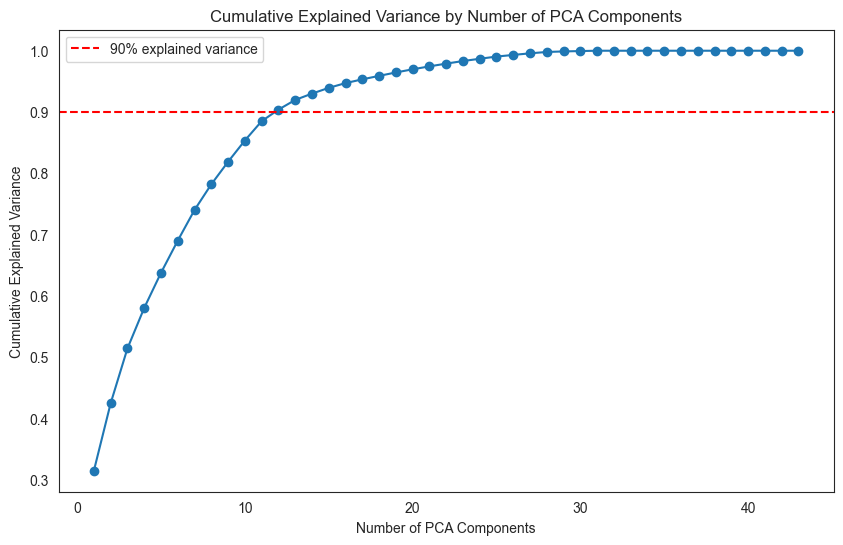

In [558]:
# Step 1: Define the features for PCA, excluding 'Patient ID' since it's now the index
features = clustering_df  # Index already set; no need to drop 'Patient ID'

# Step 2: Apply PCA without specifying n_components initially to calculate explained variance
pca = PCA()
pca.fit(features)

# Step 3: Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Step 4: Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of PCA Components')
plt.axhline(y=0.9, color='r', linestyle='--', label="90% explained variance")
plt.legend()
plt.show()

Total Variance Explained by 12 Components: 0.9253


<Figure size 640x480 with 0 Axes>

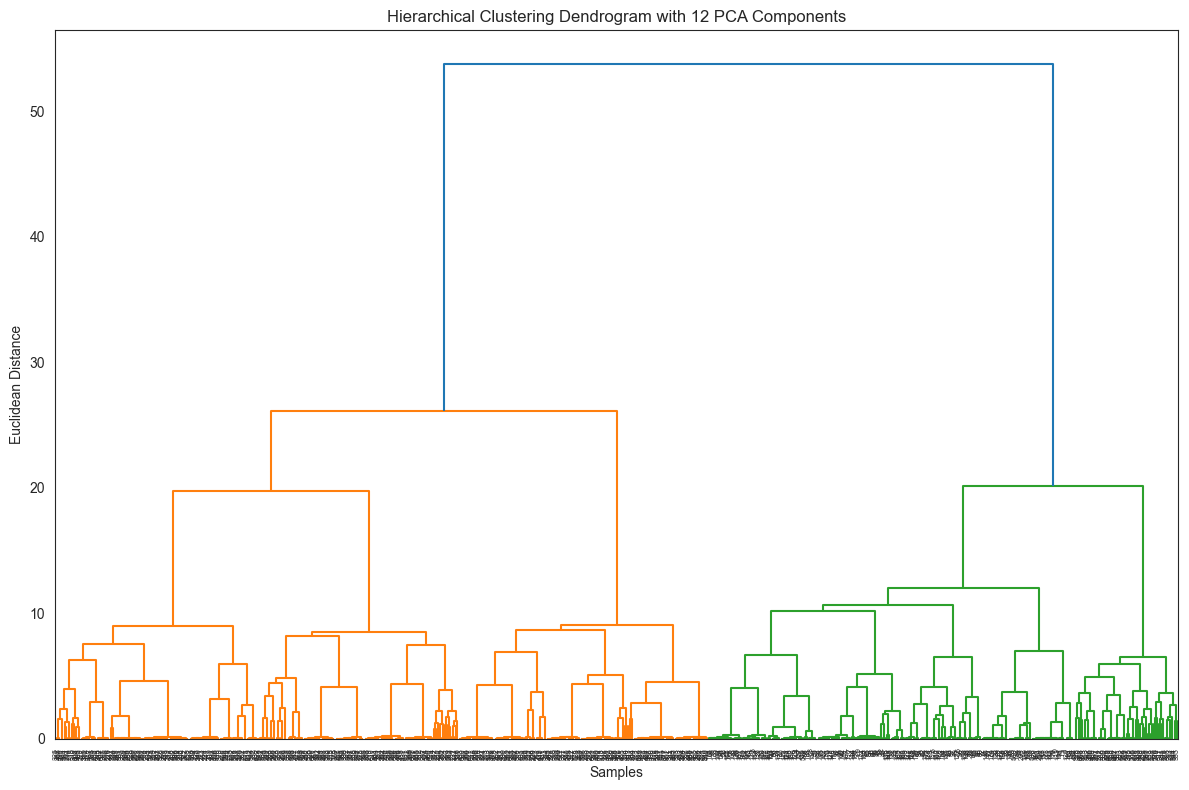


Cluster Counts:
Cluster
3    153
4    140
6    113
5    113
1     58
2     52
Name: count, dtype: int64


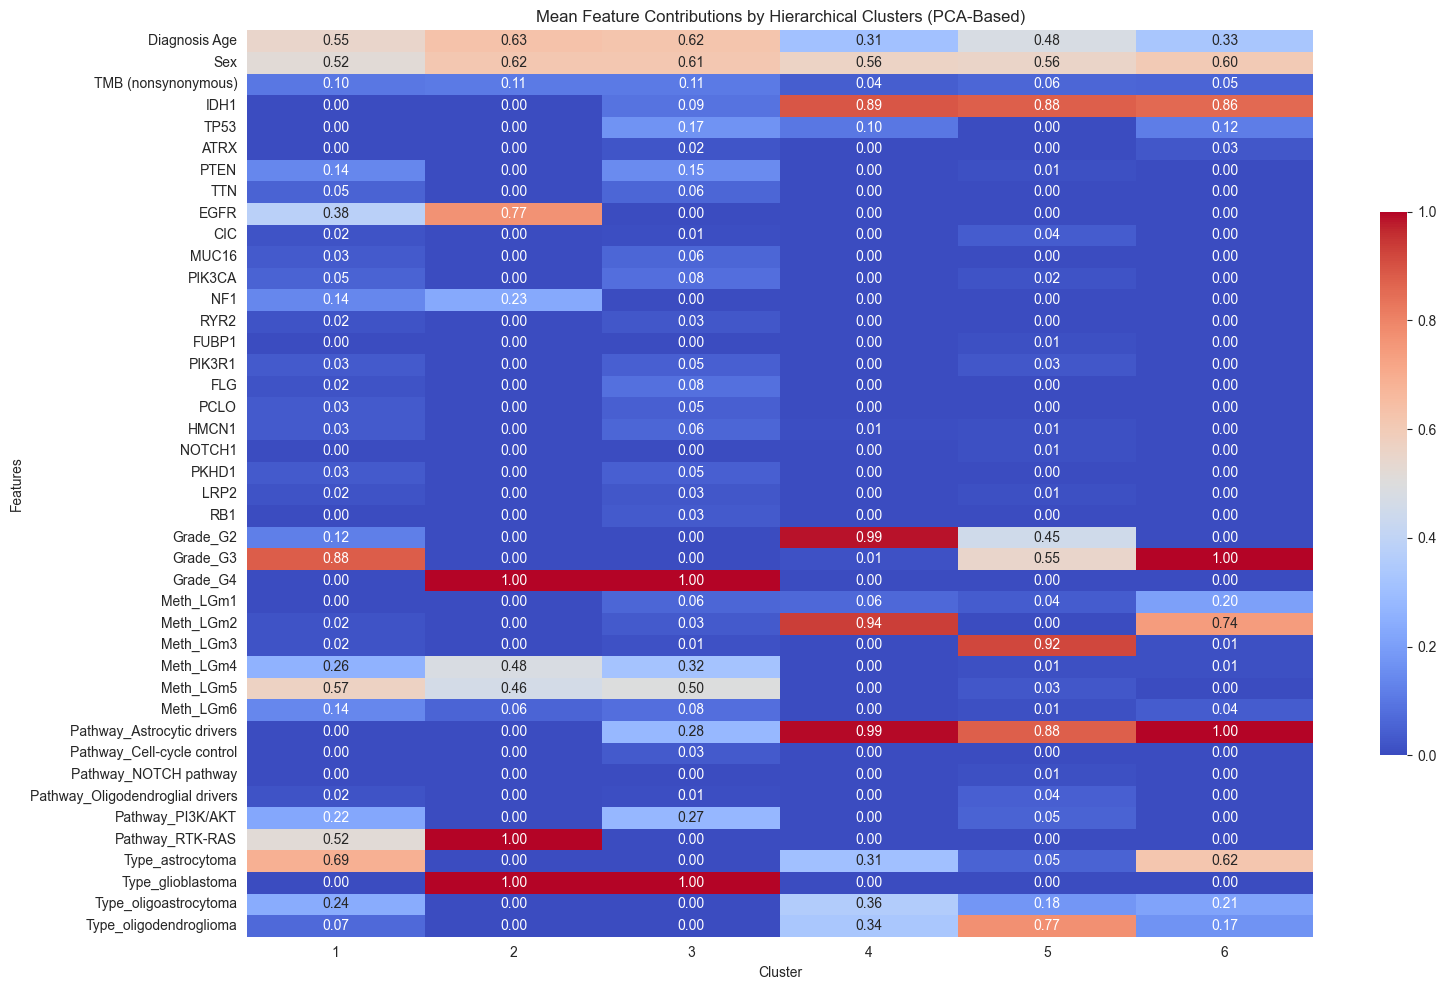

In [561]:
# — Style setup for all plots —
sns.set_style("white")
sns.despine()

# === PRE-ANALYSIS PRUNE ===
# Drop the 'Pathway_none' feature up front
clustering_df = clustering_df.drop(columns=['Pathway_none'], errors='ignore')

# Step 1: PCA → 12 components
pca = PCA(n_components=12)
pca_result = pca.fit_transform(clustering_df)
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Total Variance Explained by 12 Components: {explained_variance:.4f}")

# Step 2: Hierarchical clustering on PCA space
linked = linkage(pca_result, method='ward')

# Step 3: Dendrogram
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(False)

dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=False,
    ax=ax
)
ax.set_title("Hierarchical Clustering Dendrogram with 12 PCA Components")
ax.set_xlabel("Samples")
ax.set_ylabel("Euclidean Distance")
plt.tight_layout()
plt.show()

# Step 4: Cut into clusters
distance_cutoff = 12
clusters = fcluster(linked, distance_cutoff, criterion='distance')
clustering_df = clustering_df.copy()
clustering_df['Cluster'] = clusters

# Step 5: Reset index if needed
post_clustering_df = clustering_df.reset_index()

print("\nCluster Counts:")
print(post_clustering_df['Cluster'].value_counts())

# Step 6: (Optional) merge back into original data as you did…

# Step 7: Renumber clusters sequentially
uniq = sorted(post_clustering_df['Cluster'].unique())
renum = {old: new for new, old in enumerate(uniq, start=1)}
clustering_df['Cluster'] = clustering_df['Cluster'].map(renum)

# === PROFILE & PRUNE ZERO-CONTRIBUTORS ===
# Step 8: Compute mean feature values per cluster
cluster_features_hier = clustering_df.groupby('Cluster').mean()

# Drop any feature that is zero in *all* clusters
nonzero = (cluster_features_hier != 0).any(axis=0)
cluster_features_hier = cluster_features_hier.loc[:, nonzero]

# Step 9: Heatmap
fig, ax = plt.subplots(figsize=(16, 10))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

sns.heatmap(
    cluster_features_hier.T,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    ax=ax,
    cbar_kws={'shrink': 0.6}
)
ax.set_title('Mean Feature Contributions by Hierarchical Clusters (PCA-Based)')
ax.set_xlabel('Cluster')
ax.set_ylabel('Features')
plt.tight_layout()
plt.show()


In [562]:
# Step 1: Transpose cluster_features to match heatmap layout (clusters as columns)
cluster_features_hierarchical_T = cluster_features_hierarchical.T

# Step 2: Identify top features for each cluster
top_features_per_cluster = {}

for cluster in cluster_features_hierarchical_T.columns:  # Clusters are now columns
    # Sort features by their contribution for the current cluster
    top_features = cluster_features_hierarchical_T[cluster].sort_values(ascending=False)
    top_features_per_cluster[cluster] = top_features.head(5)  # Top 5 features, adjust as needed

# Step 3: Print the top features for each cluster
for cluster, features in top_features_per_cluster.items():
    print(f"\nTop Features for Cluster {cluster}:")
    print(features)


Top Features for Cluster 1:
Grade_G4             1.000000
Type_glioblastoma    1.000000
Pathway_RTK-RAS      0.962963
EGFR                 0.740741
Diagnosis Age        0.633086
Name: 1, dtype: float64

Top Features for Cluster 2:
Type_glioblastoma    1.000000
Grade_G4             1.000000
Pathway_none         0.939394
Diagnosis Age        0.670101
Sex                  0.590909
Name: 2, dtype: float64

Top Features for Cluster 3:
Grade_G3            0.946429
Type_astrocytoma    0.696429
Meth_LGm5           0.589286
Diagnosis Age       0.560952
Sex                 0.500000
Name: 3, dtype: float64

Top Features for Cluster 4:
Grade_G4                      1.000000
Type_glioblastoma             1.000000
Sex                           0.635294
Diagnosis Age                 0.586353
Pathway_Astrocytic drivers    0.505882
Name: 4, dtype: float64

Top Features for Cluster 5:
Type_oligodendroglioma        0.972603
Grade_G3                      0.876712
Pathway_Astrocytic drivers    0.794521
ID

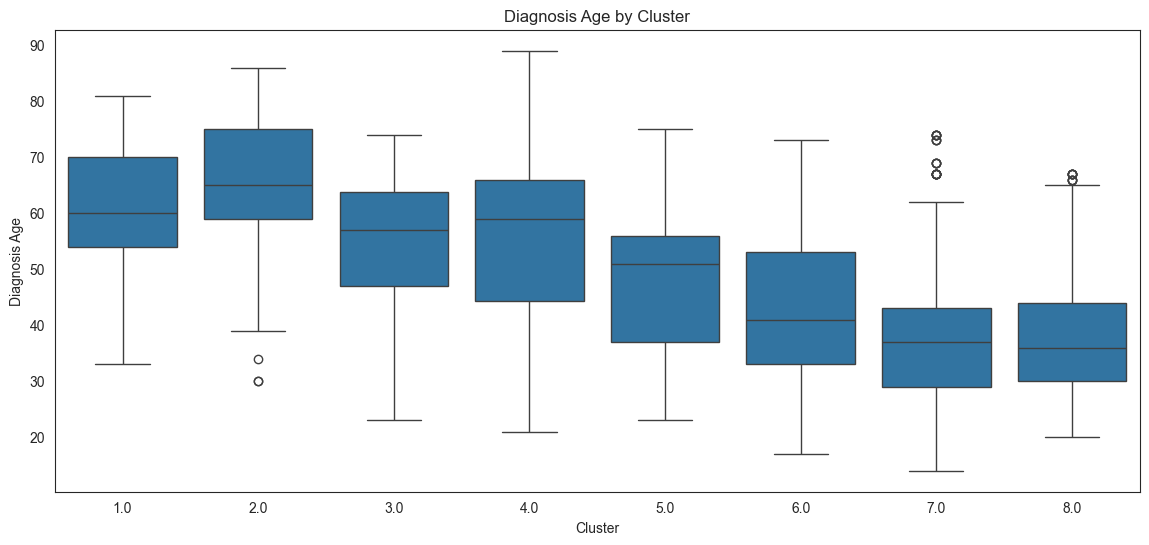

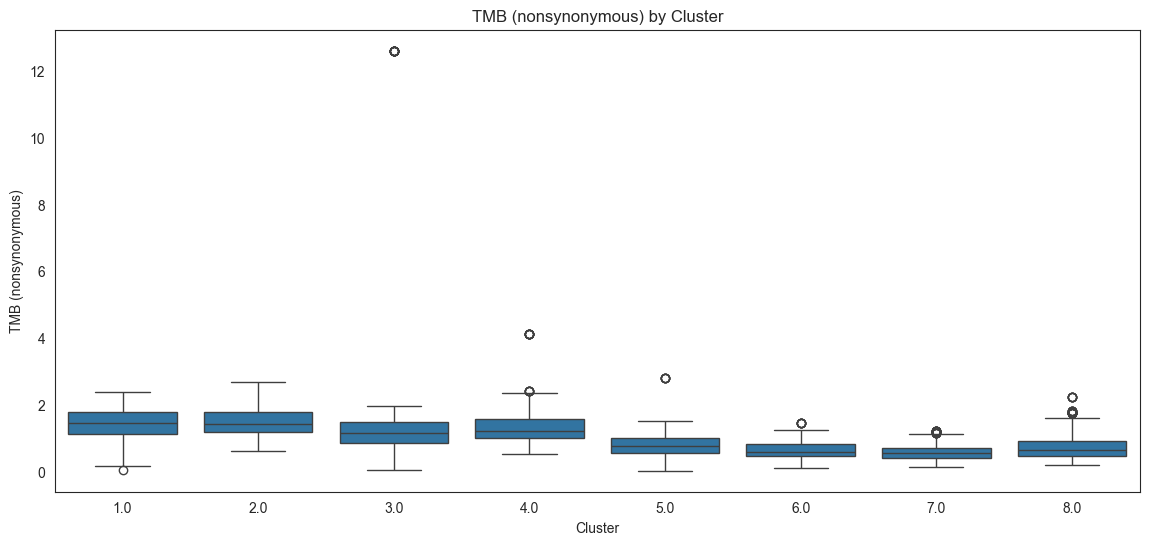

In [563]:

# Box plot for Diagnosis Age and TMB (nonsynonymous)
plt.figure(figsize=(14, 6))
sns.boxplot(data=merged_before_norm_df_with_clusters, x='Cluster', y='Diagnosis Age')
plt.title('Diagnosis Age by Cluster')
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(data=merged_before_norm_df_with_clusters, x='Cluster', y='TMB (nonsynonymous)')
plt.title('TMB (nonsynonymous) by Cluster')
plt.show()


#### **Non-hierarchical clustering after UMAP**

/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


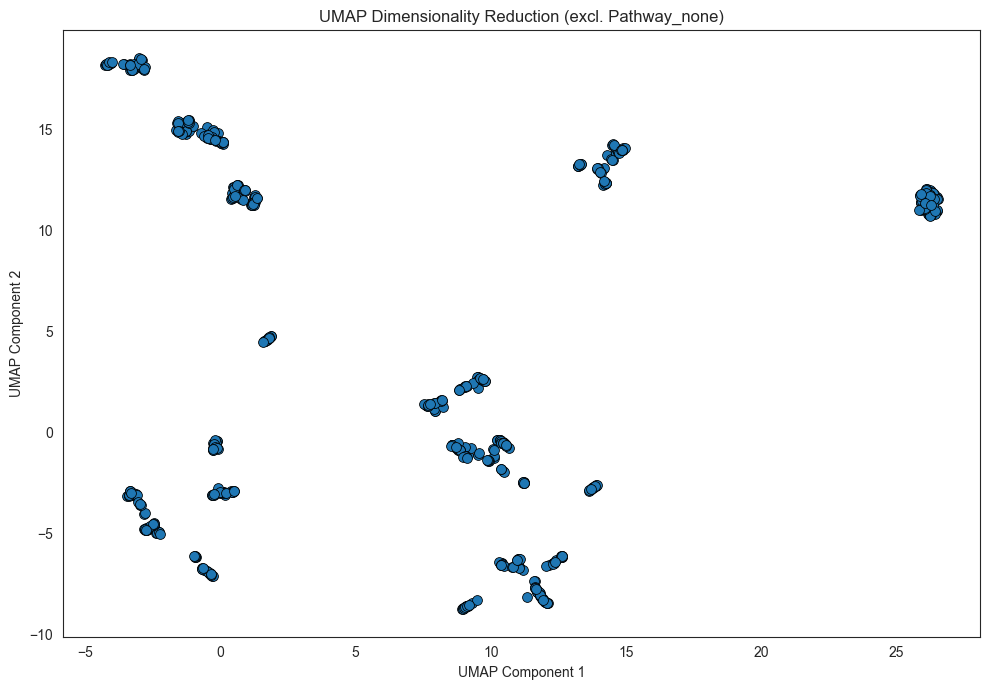

In [ ]:
# 0) Drop the unwanted feature up front
df_umap = clustering_df.drop(columns=['Pathway_none'], errors='ignore')

# 1) UMAP dimensionality reduction on the pruned DataFrame
reducer = umap.UMAP(
    n_neighbors=20,
    min_dist=0.1,
    metric='euclidean',
    random_state=42
)
umap_data = reducer.fit_transform(df_umap)

# 2) Plot UMAP result
plt.figure(figsize=(10, 7))
sns.scatterplot(x=umap_data[:, 0], y=umap_data[:, 1], s=50, edgecolor='k')
plt.title('UMAP Dimensionality Reduction (excl. Pathway_none)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.tight_layout()
plt.show()



In [570]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=0.2, min_samples=5).fit(umap_data)
dbscan_labels = dbscan.labels_ + 1  # Increment labels to start from 1
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan.labels_ else 0)

# Calculate DBSCAN metrics (if there are >1 clusters)
if n_clusters_dbscan > 1:
    dbscan_silhouette = silhouette_score(umap_data, dbscan_labels)
    dbscan_davies_bouldin = davies_bouldin_score(umap_data, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_davies_bouldin = None

# Print DBSCAN results
print(f"DBSCAN - Number of Clusters: {n_clusters_dbscan}")
print(f"DBSCAN - Silhouette Score: {dbscan_silhouette}, Davies-Bouldin Index: {dbscan_davies_bouldin}")

DBSCAN - Number of Clusters: 45
DBSCAN - Silhouette Score: 0.60366290807724, Davies-Bouldin Index: 1.5266057491382032


In [571]:
# Test Clusters (6–16) for K-Means and GMM
cluster_range = range(6, 17)  # 6 to 16 clusters
results = []

for n_clusters in cluster_range:
    print(f"\nTesting {n_clusters} clusters:")

    # K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(umap_data)
    kmeans_labels = kmeans.labels_ + 1  # Increment labels to start from 1
    kmeans_silhouette = silhouette_score(umap_data, kmeans_labels)
    kmeans_davies_bouldin = davies_bouldin_score(umap_data, kmeans_labels)
    print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_davies_bouldin:.4f}")

    # GMM
    gmm = GaussianMixture(n_components=n_clusters, random_state=42).fit(umap_data)
    gmm_labels = gmm.predict(umap_data) + 1  # Increment labels to start from 1
    gmm_silhouette = silhouette_score(umap_data, gmm_labels)
    gmm_davies_bouldin = davies_bouldin_score(umap_data, gmm_labels)
    print(f"GMM - Silhouette Score: {gmm_silhouette:.4f}, Davies-Bouldin Index: {gmm_davies_bouldin:.4f}")

    # Store results
    results.append({
        "Clusters": n_clusters,
        "K-Means Silhouette": kmeans_silhouette,
        "K-Means Davies-Bouldin": kmeans_davies_bouldin,
        "GMM Silhouette": gmm_silhouette,
        "GMM Davies-Bouldin": gmm_davies_bouldin,
    })

# Create Results DataFrame
results_df = pd.DataFrame(results)

# Automatically Select Best Number of Clusters
# Based on Silhouette Score
best_kmeans_silhouette = results_df.loc[results_df["K-Means Silhouette"].idxmax(), "Clusters"]
best_gmm_silhouette = results_df.loc[results_df["GMM Silhouette"].idxmax(), "Clusters"]

# Based on Davies-Bouldin Index (lower is better)
best_kmeans_davies_bouldin = results_df.loc[results_df["K-Means Davies-Bouldin"].idxmin(), "Clusters"]
best_gmm_davies_bouldin = results_df.loc[results_df["GMM Davies-Bouldin"].idxmin(), "Clusters"]

# Print the best cluster numbers
print(f"\nBest K-Means Clusters by Silhouette Score: {best_kmeans_silhouette} clusters")
print(f"Best GMM Clusters by Silhouette Score: {best_gmm_silhouette} clusters")
print(f"Best K-Means Clusters by Davies-Bouldin Index: {best_kmeans_davies_bouldin} clusters")
print(f"Best GMM Clusters by Davies-Bouldin Index: {best_gmm_davies_bouldin} clusters")


Testing 6 clusters:
K-Means - Silhouette Score: 0.6811, Davies-Bouldin Index: 0.4913
GMM - Silhouette Score: 0.6811, Davies-Bouldin Index: 0.4913

Testing 7 clusters:
K-Means - Silhouette Score: 0.6902, Davies-Bouldin Index: 0.4073
GMM - Silhouette Score: 0.6892, Davies-Bouldin Index: 0.3982

Testing 8 clusters:
K-Means - Silhouette Score: 0.6442, Davies-Bouldin Index: 0.5699
GMM - Silhouette Score: 0.6428, Davies-Bouldin Index: 0.5716

Testing 9 clusters:
K-Means - Silhouette Score: 0.6959, Davies-Bouldin Index: 0.4771
GMM - Silhouette Score: 0.6959, Davies-Bouldin Index: 0.4771

Testing 10 clusters:
K-Means - Silhouette Score: 0.7275, Davies-Bouldin Index: 0.3599
GMM - Silhouette Score: 0.7275, Davies-Bouldin Index: 0.3599

Testing 11 clusters:
K-Means - Silhouette Score: 0.7090, Davies-Bouldin Index: 0.4321
GMM - Silhouette Score: 0.7090, Davies-Bouldin Index: 0.4321

Testing 12 clusters:
K-Means - Silhouette Score: 0.7250, Davies-Bouldin Index: 0.4163
GMM - Silhouette Score: 0.725

DBI < 1: Indicates very good clustering. DBI around 1–1.5: Suggests acceptable clustering quality. DBI > 2: Indicates poor clustering (clusters overlap significantly or are not compact).

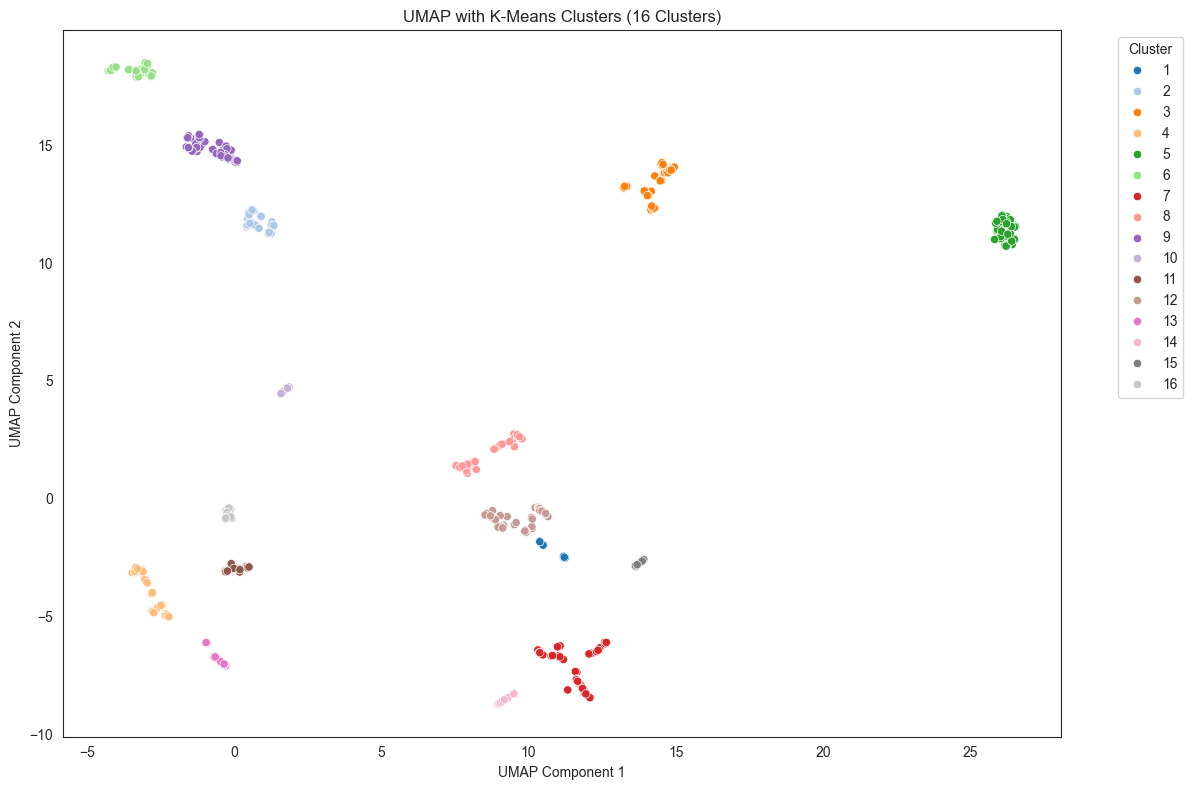

In [572]:
# Define the number of clusters
n_clusters = 16

# K-Means Clustering for 14 Clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(umap_data)
kmeans_labels = kmeans.labels_ + 1  # Increment labels to start from 1

# Plot UMAP with K-Means Clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=umap_data[:, 0],
    y=umap_data[:, 1],
    hue=kmeans_labels,
    palette=sns.color_palette("tab20", n_clusters),  # Use tab20 for distinct colors
    legend="full"
)
plt.title(f"UMAP with K-Means Clusters ({n_clusters} Clusters)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(
    title="Cluster",
    bbox_to_anchor=(1.05, 1),  # Place legend to the right of the plot
    loc="upper left"
)
plt.tight_layout()
plt.show()


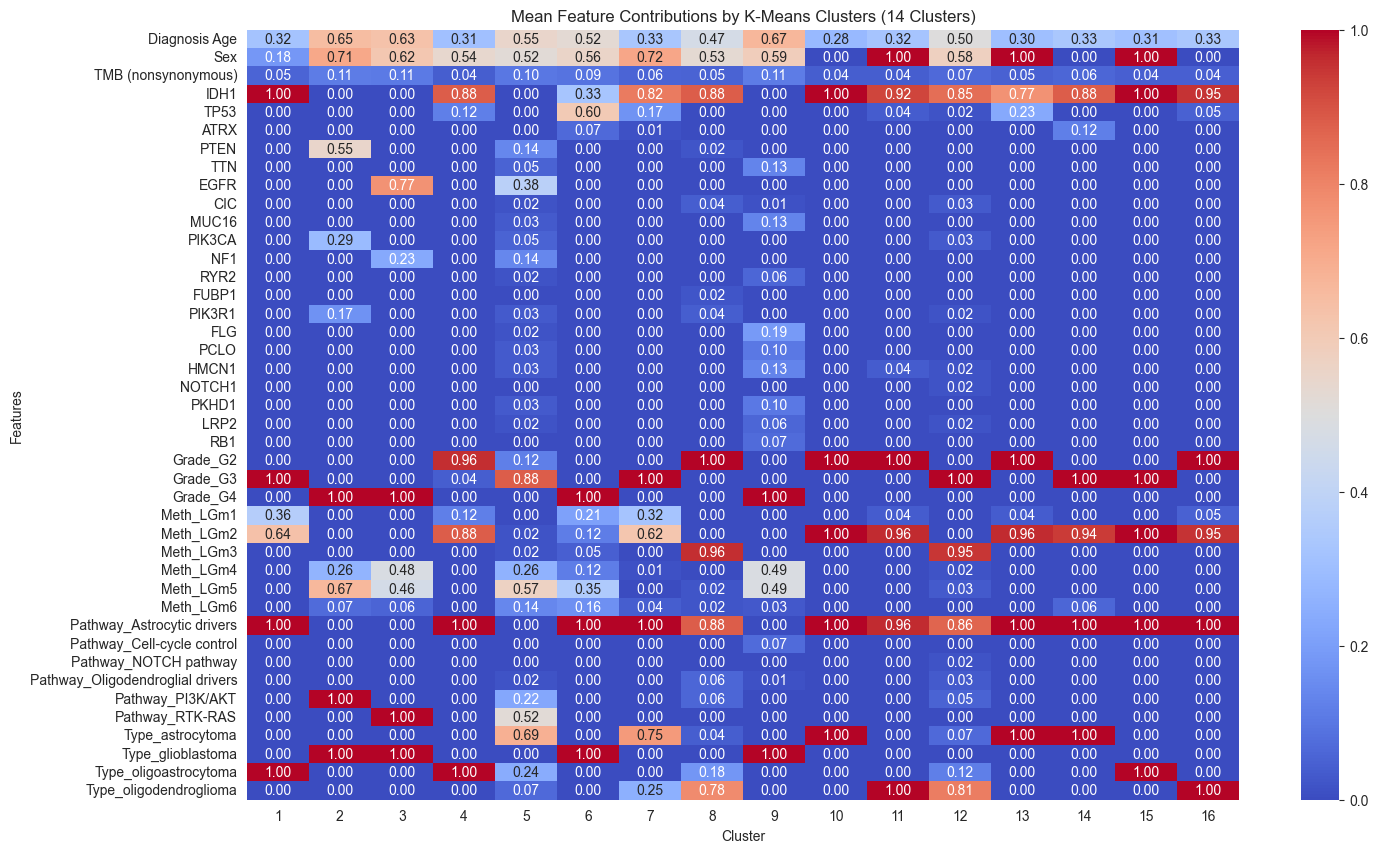

In [573]:
# Step 1: Add cluster labels to the original DataFrame
clustering_df['Cluster'] = kmeans_labels  # Ensure labels are from K-Means

# Step 2: Calculate mean feature values for each cluster
cluster_features = clustering_df.groupby('Cluster').mean()

# Step 3: Plot heatmap of feature contributions
plt.figure(figsize=(16, 10))
sns.heatmap(cluster_features.T, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Mean Feature Contributions by K-Means Clusters (14 Clusters)')
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.show()

In [468]:
# Step 1: Count the number of patients in each cluster
patients_per_cluster = clustering_df['Cluster'].value_counts().sort_index()

# Step 2: Print the number of patients per cluster
print("Number of Patients Per Cluster:")
print(patients_per_cluster)


Number of Patients Per Cluster:
Cluster
1     37
2     28
3     56
4     25
5     52
6     74
7     43
8     68
9     36
10    17
11    42
12    30
13    19
14    20
15    54
16    28
Name: count, dtype: int64


In [469]:
# Step 1: Transpose cluster_features to match heatmap layout (clusters as columns)
cluster_features_T = cluster_features.T

# Step 2: Identify top features for each cluster
top_features_per_cluster = {}

for cluster in cluster_features_T.columns:  # Clusters are now columns
    # Sort features by their contribution for the current cluster
    top_features = cluster_features_T[cluster].sort_values(ascending=False)
    top_features_per_cluster[cluster] = top_features.head(5)  # Top 5 features, adjust as needed

# Step 3: Print the top features for each cluster
for cluster, features in top_features_per_cluster.items():
    print(f"\nTop Features for Cluster {cluster}:")
    print(features)



Top Features for Cluster 1:
Pathway_Astrocytic drivers    1.000000
Type_oligoastrocytoma         1.000000
Grade_G3                      1.000000
IDH1                          0.945946
Sex                           0.702703
Name: 1, dtype: float64

Top Features for Cluster 2:
Type_oligodendroglioma        1.000000
Grade_G3                      1.000000
Pathway_Astrocytic drivers    0.892857
IDH1                          0.857143
Meth_LGm3                     0.678571
Name: 2, dtype: float64

Top Features for Cluster 3:
Grade_G3            0.946429
Type_astrocytoma    0.696429
Meth_LGm5           0.589286
Diagnosis Age       0.560952
Sex                 0.500000
Name: 3, dtype: float64

Top Features for Cluster 4:
Type_oligodendroglioma        1.00
Sex                           1.00
Meth_LGm2                     1.00
Grade_G2                      1.00
Pathway_Astrocytic drivers    0.96
Name: 4, dtype: float64

Top Features for Cluster 5:
Grade_G4             1.000000
Type_glioblastoma  

## **Prediction**

In [471]:
#Resetting index to bring column Patient ID back
clustering_df=clustering_df.reset_index()

# Create the 'prediction' DataFrame based on clustering_df by dropping the 'Cluster' column
prediction = clustering_df.drop(columns=['Cluster']).copy()

# Filter clinical_data to include only the 688 Patient IDs present in clustering_df
filtered_clinical_data = clinical_data[clinical_data['Patient ID'].isin(prediction['Patient ID'])]

# Merge 'Overall Survival Status' directly from clinical_data into prediction based on 'Patient ID'
prediction = prediction.merge(
    filtered_clinical_data[['Patient ID', 'Overall Survival (Months)','Overall Survival Status']],
    on='Patient ID',
    how='left'
)

# Confirm the merge by checking unique values and any missing entries in 'Overall Survival Status'
print("Unique values in 'Overall Survival Status' in prediction:", prediction['Overall Survival Status'].unique())
print("Number of missing values in 'Overall Survival Status':", prediction['Overall Survival Status'].isna().sum())

# Display the final DataFrame to confirm the structure
prediction

Unique values in 'Overall Survival Status' in prediction: ['1:DECEASED' '0:LIVING' nan]
Number of missing values in 'Overall Survival Status': 1


,index,Patient ID,Diagnosis Age,Sex,TMB (nonsynonymous),IDH1,TP53,ATRX,PTEN,TTN,...,Pathway_Oligodendroglial drivers,Pathway_PI3K/AKT,Pathway_RTK-RAS,Pathway_none,Type_astrocytoma,Type_glioblastoma,Type_oligoastrocytoma,Type_oligodendroglioma,Overall Survival (Months),Overall Survival Status
0,0,TCGA-02-0003,0.480000,1,0.106101,0,0,0,0,0,...,0,0,1,0,0,1,0,0,4.7,1:DECEASED
1,1,TCGA-02-0033,0.533333,1,0.053050,0,0,0,0,0,...,0,0,1,0,0,1,0,0,2.8,1:DECEASED
2,2,TCGA-02-0047,0.853333,1,0.119363,0,0,0,0,0,...,0,1,0,0,0,1,0,0,14.7,1:DECEASED
3,3,TCGA-02-0055,0.640000,0,0.108753,0,0,0,1,0,...,0,1,0,0,0,1,0,0,2.5,1:DECEASED
4,4,TCGA-02-2470,0.573333,1,0.111406,0,0,0,1,0,...,0,1,0,0,0,1,0,0,12.9,1:DECEASED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,624,TCGA-VW-A7QS,0.280000,0,0.071618,1,0,0,0,0,...,0,0,0,0,0,0,0,1,23.2,0:LIVING
625,625,TCGA-VW-A8FI,0.693333,1,0.095491,0,0,0,0,0,...,0,0,0,1,1,0,0,0,8.0,1:DECEASED
626,626,TCGA-W9-A837,0.440000,1,0.045093,1,0,0,0,0,...,0,0,0,0,0,0,0,1,45.0,0:LIVING
627,627,TCGA-WH-A86K,0.680000,1,0.071618,1,0,0,0,0,...,0,0,0,0,1,0,0,0,5.3,0:LIVING


In [472]:
# Map 'Overall Survival Status' to 0 for 'LIVING' and 1 for 'DECEASED'
prediction['Overall Survival Status'] = prediction['Overall Survival Status'].map({'0:LIVING': 0, '1:DECEASED': 1})

# Verify the transformation and check for any remaining NaN values
print("Unique values in 'Overall Survival Status' after transformation:", prediction['Overall Survival Status'].unique())
print("Number of missing values in 'Overall Survival Status' after transformation:", prediction['Overall Survival Status'].isna().sum())

#Drop columns with NaN
prediction = prediction.dropna()

# Convert 'Overall Survival Status' to integer type to remove decimals
prediction['Overall Survival Status'] = prediction['Overall Survival Status'].astype('Int64')

# Display the final DataFrame to confirm the transformation
prediction

Unique values in 'Overall Survival Status' after transformation: [ 1.  0. nan]
Number of missing values in 'Overall Survival Status' after transformation: 1


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/476421946.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Overall Survival Status'] = prediction['Overall Survival Status'].astype('Int64')


,index,Patient ID,Diagnosis Age,Sex,TMB (nonsynonymous),IDH1,TP53,ATRX,PTEN,TTN,...,Pathway_Oligodendroglial drivers,Pathway_PI3K/AKT,Pathway_RTK-RAS,Pathway_none,Type_astrocytoma,Type_glioblastoma,Type_oligoastrocytoma,Type_oligodendroglioma,Overall Survival (Months),Overall Survival Status
0,0,TCGA-02-0003,0.480000,1,0.106101,0,0,0,0,0,...,0,0,1,0,0,1,0,0,4.7,1
1,1,TCGA-02-0033,0.533333,1,0.053050,0,0,0,0,0,...,0,0,1,0,0,1,0,0,2.8,1
2,2,TCGA-02-0047,0.853333,1,0.119363,0,0,0,0,0,...,0,1,0,0,0,1,0,0,14.7,1
3,3,TCGA-02-0055,0.640000,0,0.108753,0,0,0,1,0,...,0,1,0,0,0,1,0,0,2.5,1
4,4,TCGA-02-2470,0.573333,1,0.111406,0,0,0,1,0,...,0,1,0,0,0,1,0,0,12.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,624,TCGA-VW-A7QS,0.280000,0,0.071618,1,0,0,0,0,...,0,0,0,0,0,0,0,1,23.2,0
625,625,TCGA-VW-A8FI,0.693333,1,0.095491,0,0,0,0,0,...,0,0,0,1,1,0,0,0,8.0,1
626,626,TCGA-W9-A837,0.440000,1,0.045093,1,0,0,0,0,...,0,0,0,0,0,0,0,1,45.0,0
627,627,TCGA-WH-A86K,0.680000,1,0.071618,1,0,0,0,0,...,0,0,0,0,1,0,0,0,5.3,0


In [473]:
# Save the cleaned DataFrame
prediction.to_csv('prediction20.csv', index=False)

## **Diagnosis**

In [485]:
# Assuming 'prediction' is your DataFrame
# Drop the specified columns
diagnosis = prediction.drop(columns=['Overall Survival (Months)', 'Overall Survival Status',
                                     'Type_astrocytoma', 'Type_glioblastoma', 'index',
                                     'Type_oligoastrocytoma', 'Type_oligodendroglioma'])

# Merge 'Grade_G2', 'Grade_G3', and 'Grade_G4' into one column 'Glioblastoma'
# Encode 'Glioblastoma' as 1 for 'Grade_G4' and 0 for 'Grade_G2' and 'Grade_G3'
diagnosis['Glioblastoma'] = diagnosis[['Grade_G2', 'Grade_G3', 'Grade_G4']].apply(
    lambda x: 1 if x['Grade_G4'] == 1 else 0, axis=1
)

# Drop original grade columns after merging
diagnosis = diagnosis.drop(columns=['Grade_G2', 'Grade_G3', 'Grade_G4'])

# Display the transformed DataFrame
diagnosis.head()

,Patient ID,Diagnosis Age,Sex,TMB (nonsynonymous),IDH1,TP53,ATRX,PTEN,TTN,EGFR,...,Meth_LGm5,Meth_LGm6,Pathway_Astrocytic drivers,Pathway_Cell-cycle control,Pathway_NOTCH pathway,Pathway_Oligodendroglial drivers,Pathway_PI3K/AKT,Pathway_RTK-RAS,Pathway_none,Glioblastoma
0,TCGA-02-0003,0.480000,1,0.106101,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,1
1,TCGA-02-0033,0.533333,1,0.053050,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
2,TCGA-02-0047,0.853333,1,0.119363,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
3,TCGA-02-0055,0.640000,0,0.108753,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,1
4,TCGA-02-2470,0.573333,1,0.111406,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,1


In [574]:
# Define features (X) and target variable (y) while retaining Patient ID
X = diagnosis.drop(columns=['Glioblastoma'])
y = diagnosis['Glioblastoma']

# Step 1: Calculate Sample Weights
sample_weights = compute_sample_weight('balanced', y)

# Step 2: Apply each feature selection method

# 2a. Calculate Weight of Evidence (WoE) for each feature
def calculate_woe(feature, target):
    feature_data = pd.crosstab(feature, target, normalize='columns')
    woe = np.log((feature_data[1] + 1e-5) / (feature_data[0] + 1e-5))
    return abs(woe.sum())

woe_importance = [calculate_woe(X[feature], y) for feature in X.columns.drop('Patient ID')]
woe_threshold = 0.01  # Adjust as needed
woe_selected = [woe >= woe_threshold for woe in woe_importance]

# 2b. RFE with Logistic Regression using sample weights
rfe_lr = RFE(estimator=LogisticRegression(max_iter=1000, class_weight='balanced'))
rfe_lr.fit(X.drop(columns=['Patient ID']), y, sample_weight=sample_weights)

# 2c. Random Forest for feature importance using sample weights
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X.drop(columns=['Patient ID']), y, sample_weight=sample_weights)
rf_importances = rf.feature_importances_
rf_selected = rf_importances > 0.01  # Adjust threshold as needed

# 2d. LASSO for feature selection using sample weights
lasso = Lasso(alpha=0.001)  # Adjust alpha as needed
lasso.fit(X.drop(columns=['Patient ID']), y, sample_weight=sample_weights)
lasso_importances = lasso.coef_
lasso_selected = lasso_importances != 0

# Step 3: Combine selections with voting (at least three methods)
selected_features = pd.DataFrame({
    'Feature': X.columns.drop('Patient ID'),
    'WoE_Importance': woe_selected,
    'RFE_LR': rfe_lr.support_,
    'RF_Importance': rf_selected,
    'LASSO_Importance': lasso_selected
})

# Voting rule: Retain features selected by at least three methods
selected_features['Selected'] = (
    selected_features[['WoE_Importance', 'RFE_LR', 'RF_Importance', 'LASSO_Importance']].sum(axis=1) >= 3
)

# Final list of selected features, including Patient ID for tracking
final_selected_features = ['Patient ID'] + selected_features[selected_features['Selected']]['Feature'].tolist()

# Print the final list and count
print("Final selected features:", final_selected_features)
print(f"Number of selected features: {len(final_selected_features) - 1}")  # Exclude 'Patient ID'

Final selected features: ['Patient ID', 'Diagnosis Age', 'Sex', 'TMB (nonsynonymous)', 'IDH1', 'TP53', 'PIK3CA', 'PIK3R1', 'FLG', 'LRP2', 'Meth_LGm1', 'Meth_LGm2', 'Meth_LGm3', 'Meth_LGm4', 'Meth_LGm5', 'Meth_LGm6', 'Pathway_Astrocytic drivers', 'Pathway_RTK-RAS']
Number of selected features: 17


In [480]:
# Define the features (X) and target (y) using the `diagnosis` DataFrame
X = diagnosis[final_selected_features].drop(columns=['Patient ID'])
y = diagnosis['Glioblastoma']

# Step 1: Calculate Sample Weights
sample_weights = compute_sample_weight('balanced', y)

# Initialize models
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
svm = SVC(probability=True, class_weight='balanced', random_state=42)
knn = KNeighborsClassifier()
ada = AdaBoostClassifier(algorithm='SAMME', random_state=42)

# Combine models using a voting ensemble
voting_clf = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('rf', rf),
    ('svm', svm),
    ('knn', knn),
    ('ada', ada)
], voting='soft')

# Cross-validation setup
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Evaluate each model separately and print metrics
models = {
    'Logistic Regression': logreg,
    'Random Forest': rf,
    'SVM': svm,
    'K-Nearest Neighbors': knn,
    'AdaBoost': ada,
    'Voting Ensemble': voting_clf
}

for name, model in models.items():
    # Cross-validation scores for accuracy
    cv_scores = cross_val_score(model, X, y, cv=cv)
    print(f"{name} Mean cross-validation accuracy: {cv_scores.mean():.4f}")
    print(f"{name} Standard deviation of accuracy: {cv_scores.std():.4f}\n")

# Evaluate the voting ensemble on the combined holdout set
y_pred_combined = cross_val_predict(voting_clf, X, y, cv=cv, method='predict')
y_proba_combined = cross_val_predict(voting_clf, X, y, cv=cv, method='predict_proba')[:, 1]  # For AUC-ROC

# Print class distribution in the combined holdout set
print("Class distribution in the combined holdout set:")
print(y.value_counts())

# Classification report
print("\nClassification Report for Combined Holdout Set:")
print(classification_report(y, y_pred_combined))

# Confusion matrix
conf_matrix = confusion_matrix(y, y_pred_combined)
print("Confusion Matrix for Combined Holdout Set:")
print(conf_matrix)

# AUC-ROC Score
roc_auc = roc_auc_score(y, y_proba_combined)
print(f"\nAUC-ROC Score for Combined Holdout Set: {roc_auc:.4f}")

# F1-Score
f1 = f1_score(y, y_pred_combined)
print(f"F1-Score for Combined Holdout Set: {f1:.4f}")

# Accuracy for the combined holdout set
accuracy = accuracy_score(y, y_pred_combined)
print(f"Accuracy for Combined Holdout Set: {accuracy:.4f}")

Logistic Regression Mean cross-validation accuracy: 0.9761
Logistic Regression Standard deviation of accuracy: 0.0162

Random Forest Mean cross-validation accuracy: 0.9936
Random Forest Standard deviation of accuracy: 0.0106

SVM Mean cross-validation accuracy: 0.9714
SVM Standard deviation of accuracy: 0.0198

K-Nearest Neighbors Mean cross-validation accuracy: 0.9952
K-Nearest Neighbors Standard deviation of accuracy: 0.0102



/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6

AdaBoost Mean cross-validation accuracy: 0.9952
AdaBoost Standard deviation of accuracy: 0.0073



/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6

Voting Ensemble Mean cross-validation accuracy: 0.9936
Voting Ensemble Standard deviation of accuracy: 0.0106



/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6

Class distribution in the combined holdout set:
Glioblastoma
0    424
1    204
Name: count, dtype: int64

Classification Report for Combined Holdout Set:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       424
           1       1.00      0.99      0.99       204

    accuracy                           0.99       628
   macro avg       0.99      0.99      0.99       628
weighted avg       0.99      0.99      0.99       628

Confusion Matrix for Combined Holdout Set:
[[423   1]
 [  3 201]]

AUC-ROC Score for Combined Holdout Set: 0.9975
F1-Score for Combined Holdout Set: 0.9901
Accuracy for Combined Holdout Set: 0.9936


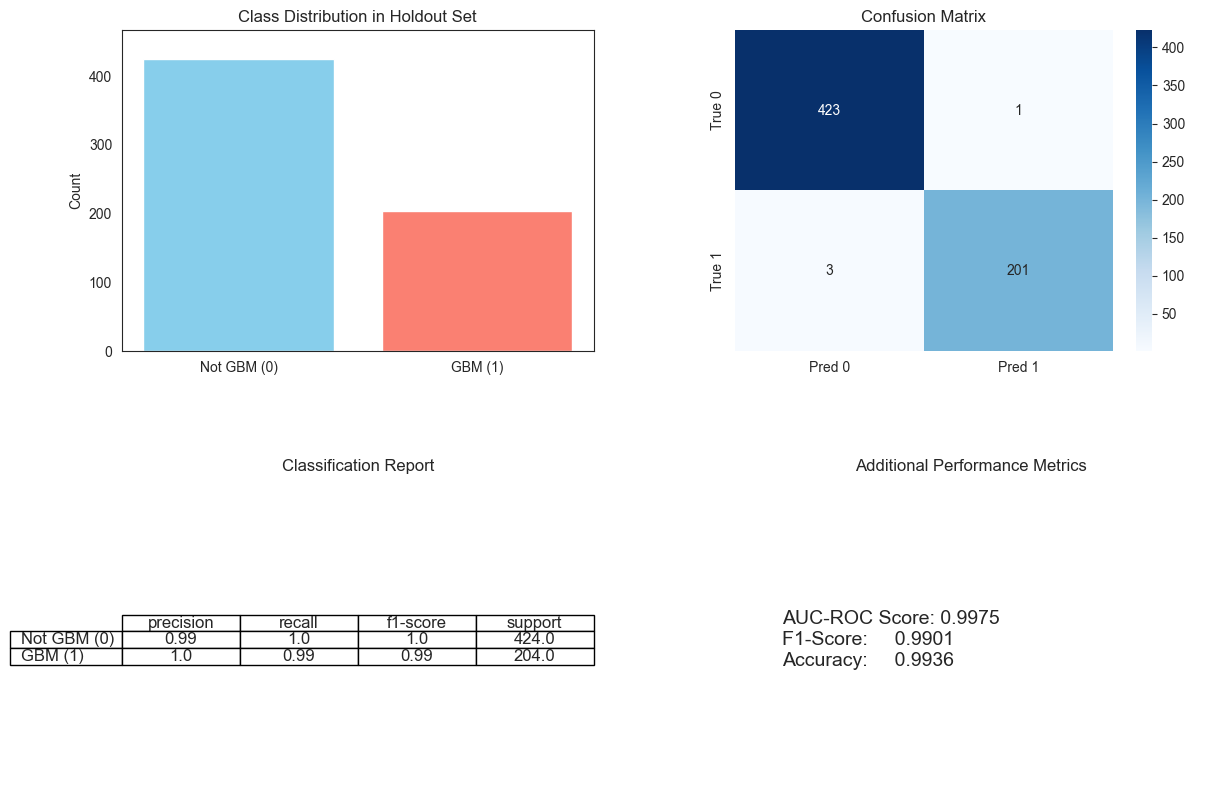

In [ ]:
# Data provided
class_counts = {'Not GBM (0)': 424, 'GBM (1)': 204}
conf_matrix = np.array([[423, 1], [3, 201]])
report_data = {
    'precision': [0.99, 1.00],
    'recall':    [1.00, 0.99],
    'f1-score':  [1.00, 0.99],
    'support':   [424,   204]
}
report_df = pd.DataFrame(report_data, index=['Not GBM (0)', 'GBM (1)'])
metrics_text = (
    "AUC-ROC Score: 0.9975\n"
    "F1-Score:     0.9901\n"
    "Accuracy:     0.9936"
)

# Create figure and axes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# 1) Class distribution bar plot
axes[0, 0].bar(class_counts.keys(), class_counts.values(), color=['skyblue', 'salmon'])
axes[0, 0].set_title('Class Distribution in Holdout Set')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_ylim(0, max(class_counts.values()) * 1.1)

# 2) Confusion matrix heatmap
sns.heatmap(
    conf_matrix,
    annot=True, fmt='d', cmap='Blues',
    xticklabels=['Pred 0', 'Pred 1'],
    yticklabels=['True 0', 'True 1'],
    ax=axes[0, 1]
)
axes[0, 1].set_title('Confusion Matrix')

# 3) Classification report table
axes[1, 0].axis('off')
table = axes[1, 0].table(
    cellText=report_df.round(2).values,
    rowLabels=report_df.index,
    colLabels=report_df.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(12)
axes[1, 0].set_title('Classification Report')

# 4) Performance metrics text
axes[1, 1].axis('off')
axes[1, 1].text(0.1, 0.5, metrics_text, fontsize=14, va='center')
axes[1, 1].set_title('Additional Performance Metrics')

plt.show()


Feature importance for the model

In [307]:
# Define feature names
feature_names = X.columns

# Function to display feature importances for models that support it
def display_feature_importance(model, model_name):
    if hasattr(model, 'coef_'):  # For models with coefficients (e.g., Logistic Regression)
        importance = np.abs(model.coef_[0])  # Get absolute values for feature importance
        feature_importance = pd.Series(importance, index=feature_names).sort_values(ascending=False)
        print(f"\nFeature Importances for {model_name} (Logistic Regression):")
        print(feature_importance)

    elif hasattr(model, 'feature_importances_'):  # For models with feature_importances_ attribute (e.g., RF, AdaBoost)
        importance = model.feature_importances_
        feature_importance = pd.Series(importance, index=feature_names).sort_values(ascending=False)
        print(f"\nFeature Importances for {model_name}:")
        print(feature_importance)

    else:
        print(f"\nFeature importance not available for {model_name}.")

# Initialize models with their trained versions for feature extraction
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42).fit(X, y)
rf = RandomForestClassifier(class_weight='balanced', random_state=42).fit(X, y)
ada = AdaBoostClassifier(algorithm='SAMME', random_state=42).fit(X, y)

# Display feature importances
display_feature_importance(logreg, 'Logistic Regression')
display_feature_importance(rf, 'Random Forest')
display_feature_importance(ada, 'AdaBoost')

# Note: SVM and K-Nearest Neighbors do not provide built-in feature importances.


Feature Importances for Logistic Regression (Logistic Regression):
Meth_LGm4                           1.378784
Meth_LGm2                           1.353616
Meth_LGm3                           1.067235
Meth_LGm5                           1.048552
Diagnosis Age                       1.043664
PIK3CA                              0.752801
IDH1                                0.649697
Sex                                 0.627906
PIK3R1                              0.495186
Pathway_RTK-RAS                     0.341047
Pathway_Astrocytic drivers          0.286820
Meth_LGm6                           0.266927
Meth_LGm1                           0.261593
FLG                                 0.235449
Pathway_Oligodendroglial drivers    0.233613
TMB (nonsynonymous)                 0.187673
TP53                                0.159472
index                               0.025453
dtype: float64

Feature Importances for Random Forest:
index                               0.549746
IDH1                  

/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


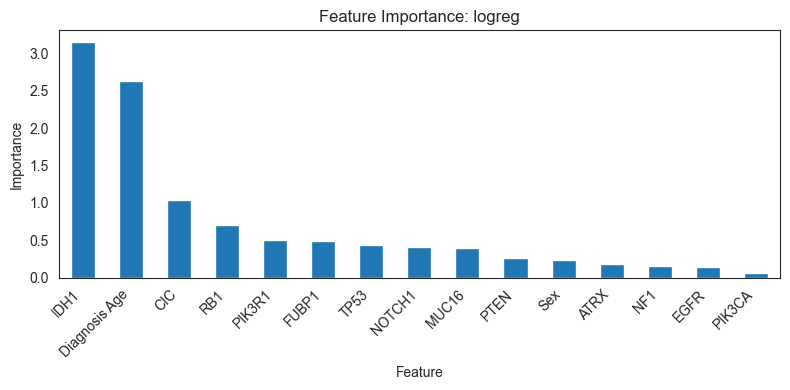

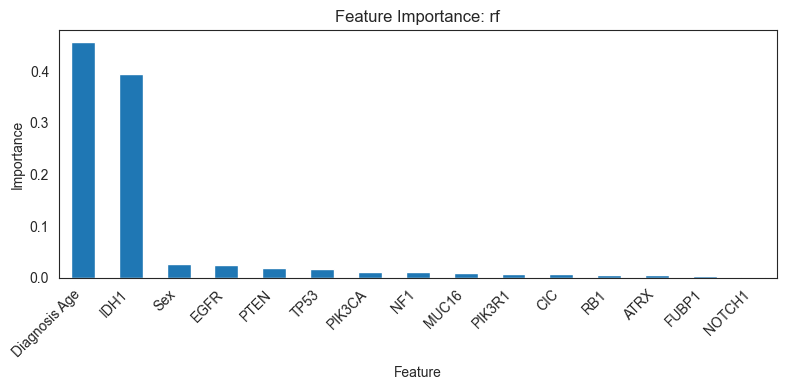

svm: no importances available
knn: no importances available


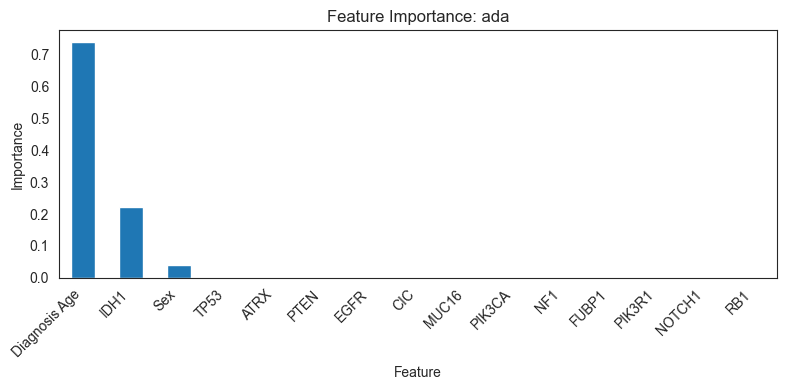

In [609]:
# --- Plot feature importance for each sub-model in your fitted voting_clf --- 
for name, est in voting_clf.named_estimators_.items():
    # Retrieve importances
    if hasattr(est, 'feature_importances_'):
        imp = est.feature_importances_
    elif hasattr(est, 'coef_'):
        imp = np.abs(est.coef_[0])
    else:
        print(f"{name}: no importances available")
        continue

    # Build a sorted Series
    fi = pd.Series(imp, index=shared).sort_values(ascending=False)

    # Plot
    plt.figure(figsize=(8, 4))
    fi.plot(kind='bar')
    plt.title(f'Feature Importance: {name}')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


#### **Validation with another published dataset**

/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


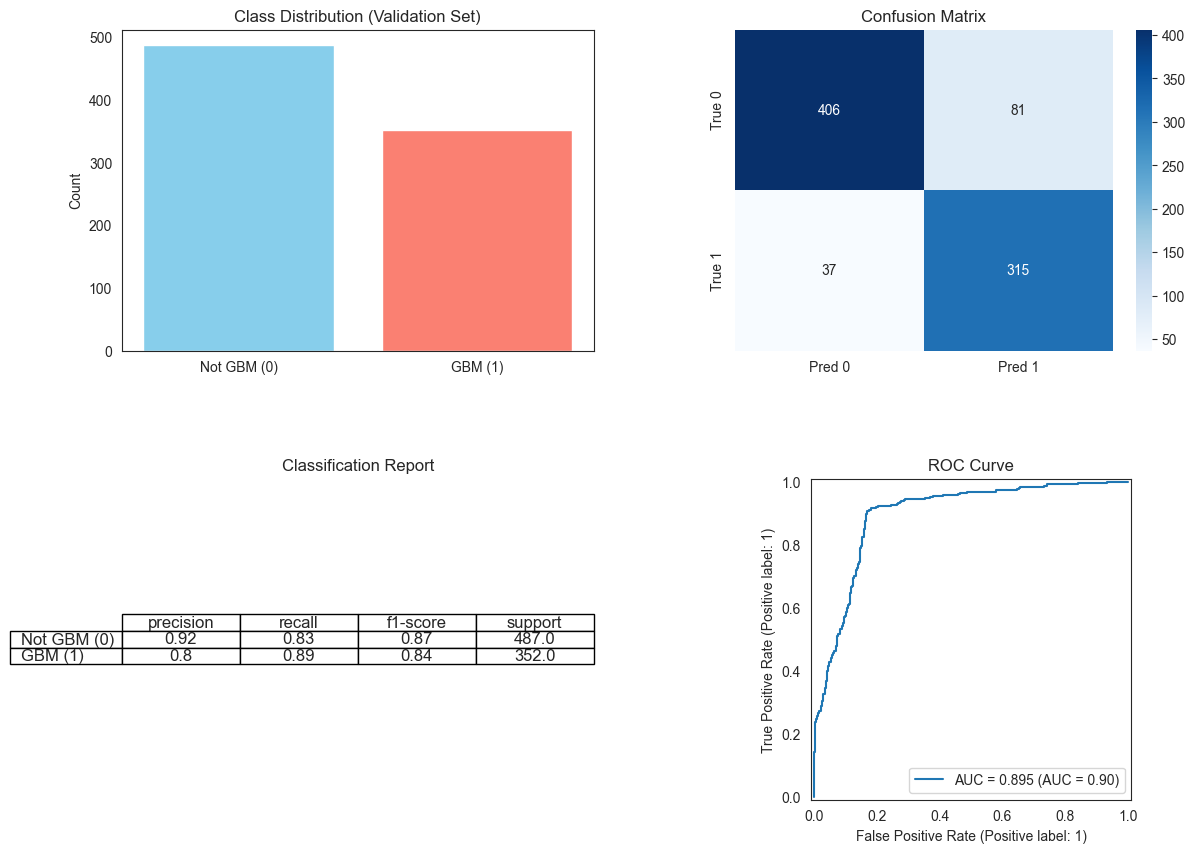

In [608]:
# assume voting_clf is already defined and trained structure (estimators list) as before

# --- 1) Load & prepare TCGA validation set ---
tcga = pd.read_csv('TCGA_InfoWithGrade.csv')
tcga = tcga.drop(columns=['index'], errors='ignore')
tcga = tcga.rename(columns={
    'Gender': 'Sex',
    'Age_at_diagnosis': 'Diagnosis Age',
    'Grade': 'Glioblastoma'
})
scaler = MinMaxScaler()
tcga['Diagnosis Age'] = scaler.fit_transform(tcga[['Diagnosis Age']])

# --- 2) Prepare training data from diagnosis DataFrame ---
X = diagnosis.drop(columns=['index', 'Patient ID', 'Glioblastoma'], errors='ignore')
y = diagnosis['Glioblastoma']

# --- 3) Find shared features & split ---
shared = [c for c in X.columns if c in tcga.columns]
X_train, X_val = X[shared], tcga[shared]
y_train, y_val = y, tcga['Glioblastoma']

# --- 4) Train ensemble and predict on TCGA ---
voting_clf.fit(X_train, y_train)
y_pred  = voting_clf.predict(X_val)
y_proba = voting_clf.predict_proba(X_val)[:, 1]

# --- 5) Compute metrics ---
cm   = confusion_matrix(y_val, y_pred)
prec = precision_score(y_val, y_pred, zero_division=0)
rec  = recall_score(y_val, y_pred, zero_division=0)
f1   = f1_score(y_val, y_pred, zero_division=0)
acc  = accuracy_score(y_val, y_pred)
auc  = roc_auc_score(y_val, y_proba)

# --- 6) Build classification report DataFrame ---
report_dict = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
report_df = (
    pd.DataFrame(report_dict)
      .T
      .loc[['0','1'], ['precision','recall','f1-score','support']]
)
report_df.index = ['Not GBM (0)','GBM (1)']

# --- 7) Class distribution counts ---
class_counts = y_val.value_counts().sort_index()  # index 0 then 1

# --- 8) Composite 2×2 plot ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Top-left: Class distribution
axes[0,0].bar(
    ['Not GBM (0)','GBM (1)'],
    [class_counts.get(0,0), class_counts.get(1,0)],
    color=['skyblue','salmon']
)
axes[0,0].set_title('Class Distribution (Validation Set)')
axes[0,0].set_ylabel('Count')

# Top-right: Confusion matrix
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Pred 0','Pred 1'],
    yticklabels=['True 0','True 1'],
    ax=axes[0,1]
)
axes[0,1].set_title('Confusion Matrix')

# Bottom-left: Classification report table
axes[1,0].axis('off')
tbl = axes[1,0].table(
    cellText=report_df.round(2).values,
    rowLabels=report_df.index,
    colLabels=report_df.columns,
    cellLoc='center',
    loc='center'
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
axes[1,0].set_title('Classification Report')

# Bottom-right: ROC curve with AUC annotation
RocCurveDisplay.from_predictions(
    y_val, y_proba,
    name=f'AUC = {auc:.3f}',
    ax=axes[1,1]
)
axes[1,1].set_title('ROC Curve')
axes[1,1].legend(loc='lower right')

plt.show()


# Using the same model for the survival prediction

In [586]:
prediction.columns

Index(['index', 'Patient ID', 'Diagnosis Age', 'Sex', 'TMB (nonsynonymous)',
       'IDH1', 'TP53', 'ATRX', 'PTEN', 'TTN', 'EGFR', 'CIC', 'MUC16', 'PIK3CA',
       'NF1', 'RYR2', 'FUBP1', 'PIK3R1', 'FLG', 'PCLO', 'HMCN1', 'NOTCH1',
       'PKHD1', 'LRP2', 'RB1', 'Grade_G2', 'Grade_G3', 'Grade_G4', 'Meth_LGm1',
       'Meth_LGm2', 'Meth_LGm3', 'Meth_LGm4', 'Meth_LGm5', 'Meth_LGm6',
       'Pathway_Astrocytic drivers', 'Pathway_Cell-cycle control',
       'Pathway_NOTCH pathway', 'Pathway_Oligodendroglial drivers',
       'Pathway_PI3K/AKT', 'Pathway_RTK-RAS', 'Pathway_none',
       'Type_astrocytoma', 'Type_glioblastoma', 'Type_oligoastrocytoma',
       'Type_oligodendroglioma', 'Overall Survival (Months)',
       'Overall Survival Status'],
      dtype='object')

Diagnosis age is the main feature even for diagnostics, so for survival it will be as well . Let's drop this column to explore other features

In [587]:
# Create a new DataFrame with 'Diagnosis Age' removed
prediction_no_age = prediction.drop(columns=['Diagnosis Age', 'Overall Survival (Months)', 'index'])

# Verify the new DataFrame
print("Columns in prediction_no_age DataFrame:", prediction_no_age.columns)
print("Unique values in Overall Survival Status:", prediction_no_age['Overall Survival Status'].unique())

Columns in prediction_no_age DataFrame: Index(['Patient ID', 'Sex', 'TMB (nonsynonymous)', 'IDH1', 'TP53', 'ATRX',
       'PTEN', 'TTN', 'EGFR', 'CIC', 'MUC16', 'PIK3CA', 'NF1', 'RYR2', 'FUBP1',
       'PIK3R1', 'FLG', 'PCLO', 'HMCN1', 'NOTCH1', 'PKHD1', 'LRP2', 'RB1',
       'Grade_G2', 'Grade_G3', 'Grade_G4', 'Meth_LGm1', 'Meth_LGm2',
       'Meth_LGm3', 'Meth_LGm4', 'Meth_LGm5', 'Meth_LGm6',
       'Pathway_Astrocytic drivers', 'Pathway_Cell-cycle control',
       'Pathway_NOTCH pathway', 'Pathway_Oligodendroglial drivers',
       'Pathway_PI3K/AKT', 'Pathway_RTK-RAS', 'Pathway_none',
       'Type_astrocytoma', 'Type_glioblastoma', 'Type_oligoastrocytoma',
       'Type_oligodendroglioma', 'Overall Survival Status'],
      dtype='object')
Unique values in Overall Survival Status: <IntegerArray>
[1, 0]
Length: 2, dtype: Int64


In [588]:
# Calculate sample weights for the modified DataFrame
sample_weights = compute_sample_weight('balanced', prediction_no_age['Overall Survival Status'])
# Define features (X) and target variable (y) while retaining Patient ID
X = prediction_no_age.drop(columns=['Overall Survival Status'])
y = prediction_no_age['Overall Survival Status']

# Step 1: Calculate Sample Weights
sample_weights = compute_sample_weight('balanced', y)

# Step 2: Apply each feature selection method

# 2a. Calculate Weight of Evidence (WoE) for each feature
def calculate_woe(feature, target):
    feature_data = pd.crosstab(feature, target, normalize='columns')
    woe = np.log((feature_data[1] + 1e-5) / (feature_data[0] + 1e-5))
    return abs(woe.sum())

woe_importance = [calculate_woe(X[feature], y) for feature in X.columns.drop('Patient ID')]
woe_threshold = 0.1  # Adjust as needed
woe_selected = [woe >= woe_threshold for woe in woe_importance]

# 2b. RFE with Logistic Regression using sample weights
rfe_lr = RFE(estimator=LogisticRegression(max_iter=1000, class_weight='balanced'))
rfe_lr.fit(X.drop(columns=['Patient ID']), y, sample_weight=sample_weights)

# 2c. Random Forest for feature importance using sample weights
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X.drop(columns=['Patient ID']), y, sample_weight=sample_weights)
rf_importances = rf.feature_importances_
rf_selected = rf_importances > 0.01  # Adjust threshold as needed

# 2d. LASSO for feature selection using sample weights
lasso = Lasso(alpha=0.01)  # Adjust alpha as needed
lasso.fit(X.drop(columns=['Patient ID']), y, sample_weight=sample_weights)
lasso_importances = lasso.coef_
lasso_selected = lasso_importances != 0

# Step 3: Combine selections with voting (at least three methods)
selected_features = pd.DataFrame({
    'Feature': X.columns.drop('Patient ID'),
    'WoE_Importance': woe_selected,
    'RFE_LR': rfe_lr.support_,
    'RF_Importance': rf_selected,
    'LASSO_Importance': lasso_selected
})

# Voting rule: Retain features selected by at least three methods
selected_features['Selected'] = (
    selected_features[['WoE_Importance', 'RFE_LR', 'RF_Importance', 'LASSO_Importance']].sum(axis=1) >= 3
)

# Final list of selected features, including Patient ID for tracking
final_selected_features = ['Patient ID'] + selected_features[selected_features['Selected']]['Feature'].tolist()

# Print the final list and count
print("Final selected features:", final_selected_features)
print(f"Number of selected features: {len(final_selected_features) - 1}")  # Exclude 'Patient ID'

Final selected features: ['Patient ID', 'TMB (nonsynonymous)', 'IDH1', 'Grade_G2', 'Grade_G4', 'Meth_LGm2', 'Meth_LGm3', 'Meth_LGm4', 'Meth_LGm5', 'Pathway_Astrocytic drivers', 'Pathway_RTK-RAS', 'Type_glioblastoma']
Number of selected features: 11


TP53 is not picked, whic is biologically awkward, so I want to add it as a feature

In [589]:
# Count the number of patients with TP53 mutations
tp53_mutations_count = prediction_no_age['TP53'].sum()
total_patients = prediction_no_age['Patient ID'].nunique()

# Display results
print(f"Number of patients with TP53 mutations: {tp53_mutations_count}")
print(f"Total number of patients: {total_patients}")
print(f"Percentage of patients with TP53 mutations: {tp53_mutations_count / total_patients * 100:.2f}%")

Number of patients with TP53 mutations: 53
Total number of patients: 628
Percentage of patients with TP53 mutations: 8.44%


In [590]:
# Compute correlation matrix for selected gene features, including TP53
gene_columns = [col for col in prediction_no_age.columns if col != 'Patient ID' and col != 'Overall Survival Status']
correlation_matrix = prediction_no_age[gene_columns].corr()

# Display correlations of TP53 with other genes
tp53_correlations = correlation_matrix['TP53'].sort_values(ascending=False)
print("TP53 Correlations with Other Genes:")
print(tp53_correlations)


TP53 Correlations with Other Genes:
TP53                                1.000000
Pathway_Astrocytic drivers          0.233972
Meth_LGm6                           0.156450
Type_glioblastoma                   0.107437
Grade_G4                            0.107437
Meth_LGm1                           0.093331
Sex                                 0.048717
TMB (nonsynonymous)                 0.027648
Meth_LGm5                           0.022404
Type_astrocytoma                    0.007657
FUBP1                              -0.012125
NOTCH1                             -0.012125
Pathway_NOTCH pathway              -0.012125
Meth_LGm2                          -0.019807
RYR2                               -0.027199
Pathway_Cell-cycle control         -0.027199
RB1                                -0.027199
Meth_LGm4                          -0.027338
LRP2                               -0.029818
ATRX                               -0.029818
CIC                                -0.029818
Pathway_Oligodendro

In [591]:
# Define the genes of interest
genes_of_interest = ['ATRX', 'TP53', 'IDH1']

# Calculate the mutation count and percentage for each gene
mutation_counts = prediction_no_age[genes_of_interest].sum()
total_patients = prediction_no_age['Patient ID'].nunique()

# Create a DataFrame with the results
mutation_summary = pd.DataFrame({
    'Gene': genes_of_interest,
    'Mutation Count': mutation_counts.values,
    'Mutation Percentage': (mutation_counts / total_patients * 100).values
})

# Display the results
print("Mutation Summary for ATRX, TP53, and IDH1:")
print(mutation_summary)

Mutation Summary for ATRX, TP53, and IDH1:
   Gene  Mutation Count  Mutation Percentage
0  ATRX               6             0.955414
1  TP53              53             8.439490
2  IDH1             335            53.343949


In [592]:
# Create a new DataFrame with only the genes of interest
gene_mutations = prediction_no_age[['ATRX', 'TP53', 'IDH1']]

# Count the number of mutations per patient in these genes
gene_mutations['Mutation Count'] = gene_mutations.sum(axis=1)

# Calculate percentages of patients with 1, 2, or 3 mutations
mutation_summary = gene_mutations['Mutation Count'].value_counts(normalize=True).sort_index() * 100

# Display results
print("Percentage of Patients with Mutations in 1, 2, or 3 Genes:")
print(mutation_summary)

Percentage of Patients with Mutations in 1, 2, or 3 Genes:
Mutation Count
0    37.261146
1    62.738854
Name: proportion, dtype: float64


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_52053/4213824011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_mutations['Mutation Count'] = gene_mutations.sum(axis=1)


Is there an overlap between IDH1, ATRX and TP53 mutations?

In [593]:
# Define conditions for each mutation combination
only_tp53 = (gene_mutations['TP53'] == 1) & (gene_mutations['ATRX'] == 0) & (gene_mutations['IDH1'] == 0)
only_atrx = (gene_mutations['ATRX'] == 1) & (gene_mutations['TP53'] == 0) & (gene_mutations['IDH1'] == 0)
only_idh1 = (gene_mutations['IDH1'] == 1) & (gene_mutations['TP53'] == 0) & (gene_mutations['ATRX'] == 0)

tp53_atrx = (gene_mutations['TP53'] == 1) & (gene_mutations['ATRX'] == 1) & (gene_mutations['IDH1'] == 0)
tp53_idh1 = (gene_mutations['TP53'] == 1) & (gene_mutations['IDH1'] == 1) & (gene_mutations['ATRX'] == 0)
atrx_idh1 = (gene_mutations['ATRX'] == 1) & (gene_mutations['IDH1'] == 1) & (gene_mutations['TP53'] == 0)

all_three = (gene_mutations['ATRX'] == 1) & (gene_mutations['TP53'] == 1) & (gene_mutations['IDH1'] == 1)

# Calculate the percentages
total_patients = len(gene_mutations)
mutation_combinations = {
    "TP53 only": only_tp53.sum() / total_patients * 100,
    "ATRX only": only_atrx.sum() / total_patients * 100,
    "IDH1 only": only_idh1.sum() / total_patients * 100,
    "TP53 + ATRX": tp53_atrx.sum() / total_patients * 100,
    "TP53 + IDH1": tp53_idh1.sum() / total_patients * 100,
    "ATRX + IDH1": atrx_idh1.sum() / total_patients * 100,
    "All three": all_three.sum() / total_patients * 100
}

# Display results
mutation_combinations_df = pd.DataFrame(list(mutation_combinations.items()), columns=['Combination', 'Percentage'])
print(mutation_combinations_df)

   Combination  Percentage
0    TP53 only    8.439490
1    ATRX only    0.955414
2    IDH1 only   53.343949
3  TP53 + ATRX    0.000000
4  TP53 + IDH1    0.000000
5  ATRX + IDH1    0.000000
6    All three    0.000000


In [594]:
# Define features (X) and target variable (y) with Patient ID for traceability
X = prediction_no_age.drop(columns=['Overall Survival Status', 'Patient ID'])
y = prediction_no_age['Overall Survival Status']

# Compute sample weights for imbalance
sample_weights = compute_sample_weight('balanced', y)

# Define models with appropriate class balancing
gb_model = GradientBoostingClassifier(random_state=42)
lr_model = LogisticRegression(penalty='l2', class_weight='balanced', max_iter=1000)
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')
ada_model = AdaBoostClassifier(algorithm='SAMME', random_state=42)

# Fit models
gb_model.fit(X, y, sample_weight=sample_weights)
lr_model.fit(X, y, sample_weight=sample_weights)
rf_model.fit(X, y, sample_weight=sample_weights)
ada_model.fit(X, y, sample_weight=sample_weights)

# Extract feature importances
gb_importances = gb_model.feature_importances_
lr_importances = np.abs(lr_model.coef_[0])
rf_importances = rf_model.feature_importances_
ada_importances = ada_model.feature_importances_

# Compile feature importances into a DataFrame for diagnostics
selected_features_df = pd.DataFrame({
    'Feature': X.columns,
    'Gradient Boosting': gb_importances,
    'Logistic Regression': lr_importances,
    'Random Forest': rf_importances,
    'AdaBoost': ada_importances
})

# Set per-model thresholds
gb_threshold = 0.01
lr_threshold = 0.03
rf_threshold = 0.03
ada_threshold = 0.01

# Diagnostic Output
print("Before Voting:")
print(selected_features_df)

# Voting rule with strict per-model thresholds
selected_features_df['Selected'] = (
    (selected_features_df['Gradient Boosting'] > gb_threshold).astype(int) +
    (selected_features_df['Logistic Regression'] > lr_threshold).astype(int) +
    (selected_features_df['Random Forest'] > rf_threshold).astype(int) +
    (selected_features_df['AdaBoost'] > ada_threshold).astype(int)
) >= 3

# Display final selected features after voting
final_selected_features = ['Patient ID'] + selected_features_df[selected_features_df['Selected']]['Feature'].tolist()

print("After Voting and Thresholds:")
print(selected_features_df[selected_features_df['Selected']])  # For verification

# Ensure TP53 is included in final selected features if not automatically selected
if 'TP53' not in final_selected_features:
    final_selected_features.append('TP53')

# Display the final list and count
print("Final selected features:", final_selected_features)
print(f"Number of selected features: {len(final_selected_features) - 1}")  # Exclude 'Patient ID'


Before Voting:
                             Feature  Gradient Boosting  Logistic Regression  \
0                                Sex           0.012877             0.014051   
1                TMB (nonsynonymous)           0.294883             0.759572   
2                               IDH1           0.286679             0.180904   
3                               TP53           0.004724             0.037195   
4                               ATRX           0.003683             0.286385   
5                               PTEN           0.004662             0.150592   
6                                TTN           0.019314             0.562977   
7                               EGFR           0.001931             0.199681   
8                                CIC           0.005328             0.106701   
9                              MUC16           0.001249             0.218068   
10                            PIK3CA           0.006613             0.843604   
11                       

/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


In [596]:
# 1) Define X, y
X = prediction_no_age[final_selected_features].drop(columns=['Patient ID'])
y = prediction_no_age['Overall Survival Status']

# 2) Full-sample weights
full_sw = compute_sample_weight('balanced', y)

# 3) Set up stratified folds
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 4) Random Forest CV with sample_weight
rf_scores = []
for train_idx, test_idx in kf.split(X, y):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
    sw_tr = full_sw[train_idx]

    rf = RandomForestClassifier(class_weight='balanced', random_state=42)
    rf.fit(X_tr, y_tr, sample_weight=sw_tr)
    rf_scores.append(rf.score(X_te, y_te))

print(f"Random Forest CV Accuracy: {np.mean(rf_scores):.4f} ± {np.std(rf_scores):.4f}")

# 5) SVM CV with sample_weight
svm_scores = []
for train_idx, test_idx in kf.split(X, y):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
    sw_tr = full_sw[train_idx]

    svm = SVC(probability=True, class_weight='balanced', random_state=42)
    svm.fit(X_tr, y_tr, sample_weight=sw_tr)
    svm_scores.append(svm.score(X_te, y_te))

print(f"SVM CV Accuracy: {np.mean(svm_scores):.4f} ± {np.std(svm_scores):.4f}")


Random Forest CV Accuracy: 0.6877 ± 0.0600
SVM CV Accuracy: 0.6547 ± 0.0744


In [597]:
# Define features (X) and target variable (y)
X = prediction_no_age[final_selected_features].drop(columns=['Patient ID'])  # Ensures selected features are used
y = prediction_no_age['Overall Survival Status']

# Initialize KNN model
knn_model = KNeighborsClassifier(n_neighbors=6)  # Adjust n_neighbors if needed

# Perform cross-validation to evaluate KNN
knn_scores = cross_val_score(knn_model, X, y, cv=10, scoring='accuracy')

# Display cross-validation results
print("KNN cross-validation scores for each fold:", knn_scores)
print("Mean cross-validation accuracy for KNN:", knn_scores.mean(), "±", knn_scores.std())

KNN cross-validation scores for each fold: [0.3968254  0.50793651 0.87301587 0.80952381 0.9047619  0.85714286
 0.68253968 0.71428571 0.69354839 0.70967742]
Mean cross-validation accuracy for KNN: 0.7149257552483358 ± 0.15354834278820978


In [598]:

# 1) Define X, y
X = prediction_no_age[final_selected_features].drop(columns=['Patient ID'])
y = prediction_no_age['Overall Survival Status']

# 2) Full-sample weights
full_sw = compute_sample_weight('balanced', y)

# 3) Set up stratified CV
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 4) AdaBoost CV
ada_scores = []
for train_idx, test_idx in kf.split(X, y):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
    sw_tr = full_sw[train_idx]

    ada = AdaBoostClassifier(algorithm='SAMME', random_state=42)
    ada.fit(X_tr, y_tr, sample_weight=sw_tr)
    ada_scores.append(ada.score(X_te, y_te))

print(f"AdaBoost CV Accuracy: {np.mean(ada_scores):.4f} ± {np.std(ada_scores):.4f}")

# 5) LogisticRegression CV
lr_scores = []
for train_idx, test_idx in kf.split(X, y):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
    sw_tr = full_sw[train_idx]

    lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
    lr.fit(X_tr, y_tr, sample_weight=sw_tr)
    lr_scores.append(lr.score(X_te, y_te))

print(f"Logistic Regression CV Accuracy: {np.mean(lr_scores):.4f} ± {np.std(lr_scores):.4f}")


/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6

AdaBoost CV Accuracy: 0.7295 ± 0.0411
Logistic Regression CV Accuracy: 0.6547 ± 0.0763


In [599]:
# Define features (X) and target variable (y)
X = prediction_no_age[final_selected_features].drop(columns=['Patient ID'])
y = prediction_no_age['Overall Survival Status']

# Initialize individual models
knn_model = KNeighborsClassifier(n_neighbors=6)
lr_model = LogisticRegression(class_weight='balanced', random_state=42)
ada_model = AdaBoostClassifier(algorithm='SAMME', random_state=42)
svm_model = SVC(probability=True, class_weight='balanced', random_state=42)
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Create the ensemble model with soft voting
ensemble_model5 = VotingClassifier(
    estimators=[
        ('knn', knn_model),
        ('logreg', lr_model),
        ('adaboost', ada_model),
        ('svm', svm_model),
        ('randomforest', rf_model)
    ],
    voting='soft'
)

# Evaluate the ensemble model using cross-validation
ensemble_scores = cross_val_score(ensemble_model5, X, y, cv=10, scoring='accuracy')

# Display cross-validation results
print("Ensemble Voting Classifier cross-validation scores for each fold:", ensemble_scores)
print("Mean cross-validation accuracy for Ensemble Voting Classifier:", ensemble_scores.mean(), "±", ensemble_scores.std())

/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6

Ensemble Voting Classifier cross-validation scores for each fold: [0.3015873  0.42857143 0.93650794 0.85714286 0.93650794 0.96825397
 0.6984127  0.71428571 0.70967742 0.77419355]
Mean cross-validation accuracy for Ensemble Voting Classifier: 0.7325140809011776 ± 0.20884575801291375


In [600]:
# 1) Define X, y as before
X = prediction_no_age[final_selected_features].drop(columns=['Patient ID'])
y = prediction_no_age['Overall Survival Status']

# 2) AdaBoost CV for F1 and ROC-AUC
ada = AdaBoostClassifier(algorithm='SAMME', random_state=42)
f1_scores_ada  = cross_val_score(ada, X, y, cv=10, scoring='f1')
roc_scores_ada = cross_val_score(ada, X, y, cv=10, scoring='roc_auc')

print("AdaBoost  F1     CV:", f1_scores_ada.mean(),  "±", f1_scores_ada.std())
print("AdaBoost  AUC-ROC CV:", roc_scores_ada.mean(), "±", roc_scores_ada.std())

# 3) LogisticRegression CV for F1 and ROC-AUC
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
f1_scores_lr  = cross_val_score(lr, X, y, cv=10, scoring='f1')
roc_scores_lr = cross_val_score(lr, X, y, cv=10, scoring='roc_auc')

print("LogisticR  F1     CV:", f1_scores_lr.mean(),  "±", f1_scores_lr.std())
print("LogisticR  AUC-ROC CV:", roc_scores_lr.mean(), "±", roc_scores_lr.std())


/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6

AdaBoost  F1     CV: 0.4731509061265662 ± 0.3237421268001968
AdaBoost  AUC-ROC CV: 0.7923792700567487 ± 0.1526102299146749
LogisticR  F1     CV: 0.6307574514246405 ± 0.23944083177112904
LogisticR  AUC-ROC CV: 0.8134216089907647 ± 0.14660474898445677


In [601]:
# Perform cross-validation predictions for 5
y_pred = cross_val_predict(ensemble_model5, X, y, cv=10, method='predict_proba')[:, 1]
y_pred_class = (y_pred >= 0.5).astype(int)  # Convert probabilities to binary class predictions

# Evaluate metrics
accuracy = accuracy_score(y, y_pred_class)
precision = precision_score(y, y_pred_class)
f1 = f1_score(y, y_pred_class)
roc_auc = roc_auc_score(y, y_pred)

# Display metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1-Score:", f1)
print("ROC-AUC Score:", roc_auc)
print("\nClassification Report:\n", classification_report(y, y_pred_class))

/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6

Accuracy: 0.732484076433121
Precision: 0.5622119815668203
F1-Score: 0.5922330097087378
ROC-AUC Score: 0.7423757920293718

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.78      0.80       433
         1.0       0.56      0.63      0.59       195

    accuracy                           0.73       628
   macro avg       0.69      0.70      0.70       628
weighted avg       0.74      0.73      0.74       628



The holdout set is a subset of the data that is excluded from training and used exclusively for final evaluation. It serves as an unseen test dataset to measure how well the model generalizes to new data.


In [602]:
# Initialize stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_count = 1
combined_val_X = pd.DataFrame()
combined_val_y = pd.Series()

for train_index, test_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    # Train the ensemble model on the training folds
    ensemble_model5.fit(X_train, y_train)

    # Combine the last few folds for a more balanced validation set
    if fold_count >= 9:  # Combine folds 9 and 10
        combined_val_X = pd.concat([combined_val_X, X_val])
        combined_val_y = pd.concat([combined_val_y, y_val])

    fold_count += 1

# Check class distribution in the combined holdout set
print("Class distribution in the combined holdout set:")
print(combined_val_y.value_counts())

# Predict on the combined holdout set
y_pred_combined = ensemble_model5.predict(combined_val_X)
y_pred_proba_combined = ensemble_model5.predict_proba(combined_val_X)[:, 1]

# Evaluate the model on the combined holdout set
print("\nClassification Report for Combined Holdout Set:")
print(classification_report(combined_val_y, y_pred_combined))
print(f"AUC-ROC Score for Combined Holdout Set: {roc_auc_score(combined_val_y, y_pred_proba_combined):.4f}")
print(f"F1-Score for Combined Holdout Set: {f1_score(combined_val_y, y_pred_combined):.4f}")

/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6

Class distribution in the combined holdout set:
0    86
1    38
Name: count, dtype: Int64

Classification Report for Combined Holdout Set:
              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87        86
         1.0       0.72      0.61      0.66        38

    accuracy                           0.81       124
   macro avg       0.78      0.75      0.76       124
weighted avg       0.80      0.81      0.80       124

AUC-ROC Score for Combined Holdout Set: 0.8537
F1-Score for Combined Holdout Set: 0.6571


# Feature extraction

Random Forest Feature Importances:
               Feature  Importance
0  TMB (nonsynonymous)    0.630860
1                 IDH1    0.096866
5             Grade_G4    0.066654
8    Type_glioblastoma    0.062204
6            Meth_LGm2    0.043574
4             Grade_G2    0.032720
7      Pathway_RTK-RAS    0.021569
9                 TP53    0.017632
2                  TTN    0.014098
3               PIK3R1    0.013822


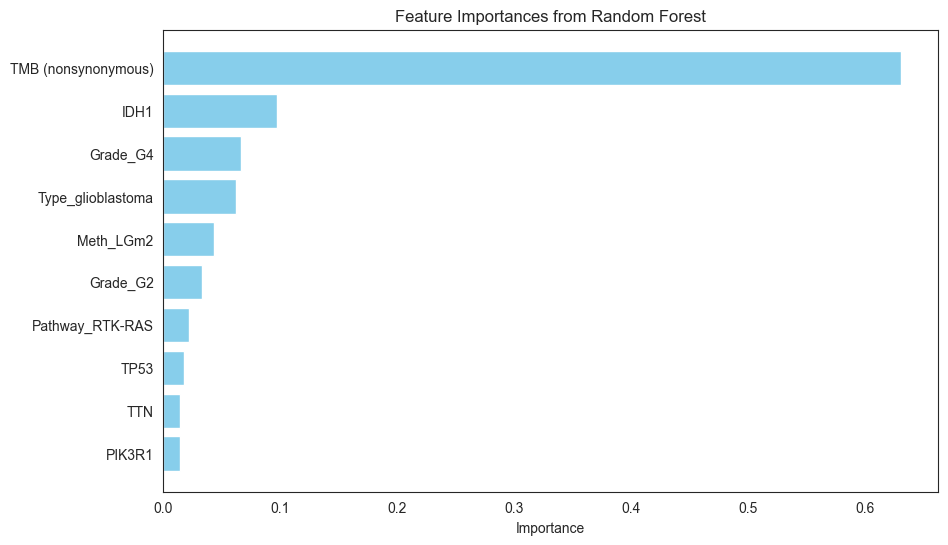

In [603]:
# Access models directly from the ensemble
rf_model = ensemble_model5.named_estimators_['randomforest']
lr_model = ensemble_model5.named_estimators_['logreg']
ada_model = ensemble_model5.named_estimators_['adaboost']
svm_model = ensemble_model5.named_estimators_['svm']
knn_model = ensemble_model5.named_estimators_['knn']

# Extract feature importances from the Random Forest model in the ensemble
rf_model = ensemble_model5.named_estimators_['randomforest']
rf_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importances:")
print(rf_importances)

# Plot feature importances for Random Forest
plt.figure(figsize=(10, 6))
plt.barh(rf_importances['Feature'], rf_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

Logistic Regression Coefficients:
               Feature  Coefficient
0  TMB (nonsynonymous)     1.097287
5             Grade_G4     0.472978
8    Type_glioblastoma     0.472978
7      Pathway_RTK-RAS     0.409545
6            Meth_LGm2    -0.330997
9                 TP53    -0.403315
4             Grade_G2    -0.536534
2                  TTN    -0.840836
1                 IDH1    -0.931033
3               PIK3R1    -1.193144


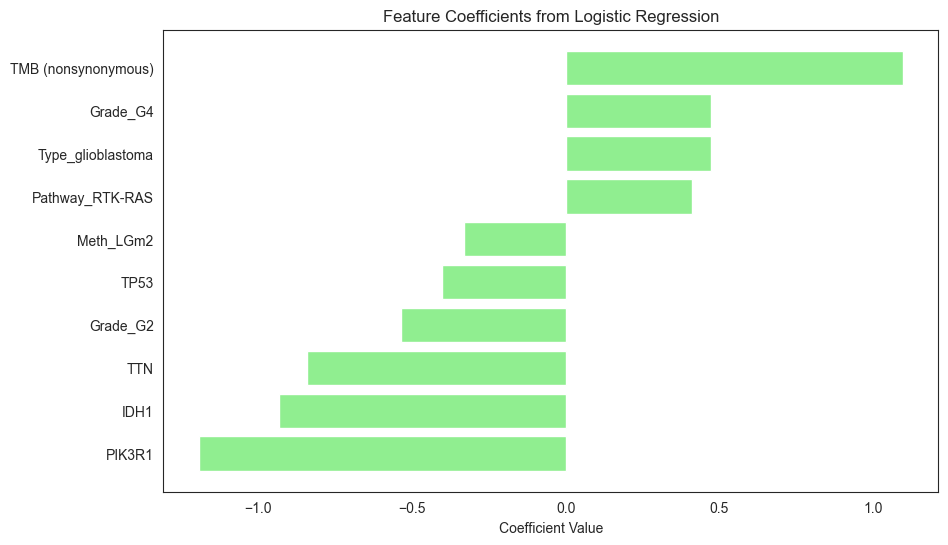

In [604]:
# Extract feature coefficients from Logistic Regression
lr_model = ensemble_model5.named_estimators_['logreg']
lr_importances = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("Logistic Regression Coefficients:")
print(lr_importances)

# Plot coefficients for Logistic Regression
plt.figure(figsize=(10, 6))
plt.barh(lr_importances['Feature'], lr_importances['Coefficient'], color='lightgreen')
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients from Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

AdaBoost Feature Importances:
               Feature  Importance
0  TMB (nonsynonymous)    0.428273
5             Grade_G4    0.240814
3               PIK3R1    0.153661
7      Pathway_RTK-RAS    0.068422
2                  TTN    0.040367
1                 IDH1    0.029119
8    Type_glioblastoma    0.023791
4             Grade_G2    0.015553
6            Meth_LGm2    0.000000
9                 TP53    0.000000


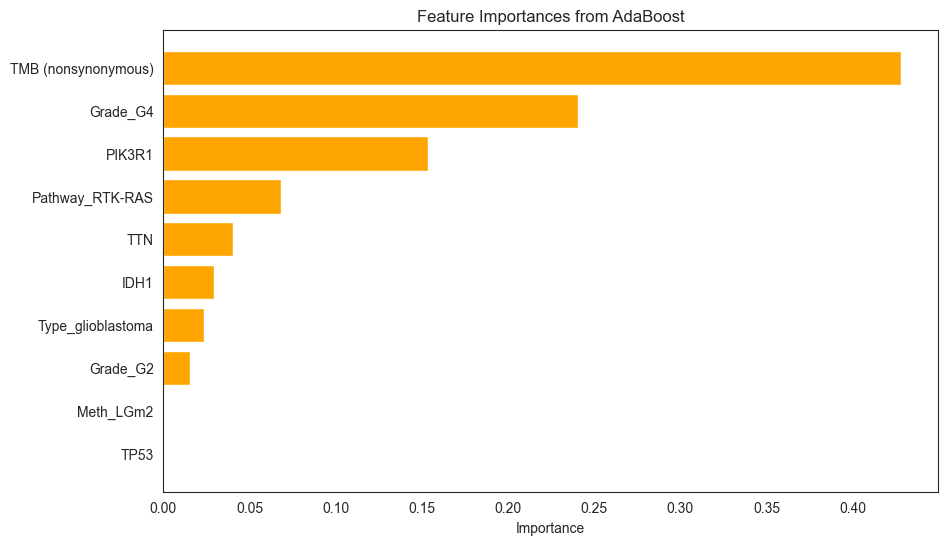

In [605]:
# Extract feature importances from AdaBoost
ada_model = ensemble_model5.named_estimators_['adaboost']
ada_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': ada_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("AdaBoost Feature Importances:")
print(ada_importances)

# Plot feature importances for AdaBoost
plt.figure(figsize=(10, 6))
plt.barh(ada_importances['Feature'], ada_importances['Importance'], color='orange')
plt.xlabel('Importance')
plt.title('Feature Importances from AdaBoost')
plt.gca().invert_yaxis()
plt.show()

KNN Permutation Importances:
               Feature  Importance
1                 IDH1    0.039331
0  TMB (nonsynonymous)    0.033280
9                 TP53    0.009713
2                  TTN    0.009554
7      Pathway_RTK-RAS    0.008917
3               PIK3R1    0.005732
5             Grade_G4    0.005255
8    Type_glioblastoma    0.005255
6            Meth_LGm2    0.003503
4             Grade_G2   -0.000637


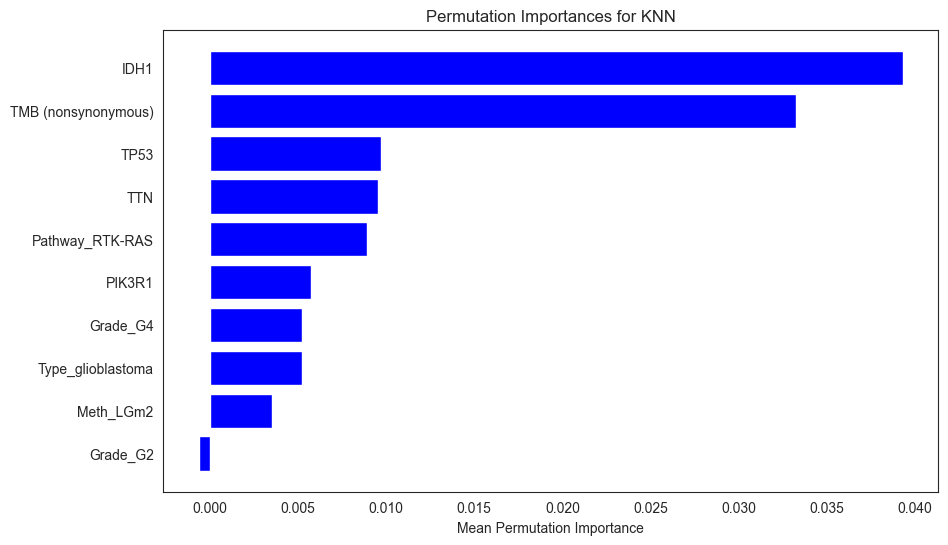

In [606]:
# Calculate permutation importances for KNN
knn_model = ensemble_model5.named_estimators_['knn']
knn_perm_importance = permutation_importance(knn_model, X, y, n_repeats=10, random_state=42)

knn_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': knn_perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print("KNN Permutation Importances:")
print(knn_importances)

plt.figure(figsize=(10, 6))
plt.barh(knn_importances['Feature'], knn_importances['Importance'], color='blue')
plt.xlabel('Mean Permutation Importance')
plt.title('Permutation Importances for KNN')
plt.gca().invert_yaxis()
plt.show()

SVC Permutation Importances:
               Feature  Importance
1                 IDH1    0.069904
4             Grade_G2    0.015605
3               PIK3R1    0.010032
2                  TTN    0.007006
6            Meth_LGm2    0.003981
0  TMB (nonsynonymous)    0.000000
7      Pathway_RTK-RAS    0.000000
9                 TP53   -0.000478
5             Grade_G4   -0.000637
8    Type_glioblastoma   -0.000637


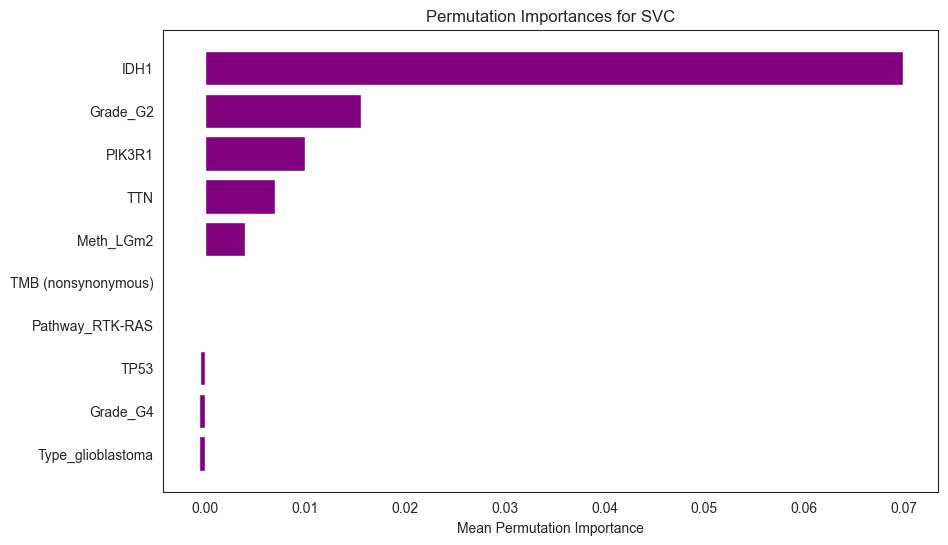

In [607]:
# Calculate permutation importances for SVC
svc_model = ensemble_model5.named_estimators_['svm']
svc_perm_importance = permutation_importance(svc_model, X, y, n_repeats=10, random_state=42)

svc_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': svc_perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print("SVC Permutation Importances:")
print(svc_importances)

plt.figure(figsize=(10, 6))
plt.barh(svc_importances['Feature'], svc_importances['Importance'], color='purple')
plt.xlabel('Mean Permutation Importance')
plt.title('Permutation Importances for SVC')
plt.gca().invert_yaxis()
plt.show()

# Survival prediction based on molecular profile

### Random Survival Forest in sksurv
Usage:
RSF predicts survival probabilities or cumulative hazard functions over time. The library supports metrics like Concordance Index (C- Index) to evaluate model performance.

Key Methods:

fit(X, y): Fits the RSF model.

predict(X): Predicts survival times for new samples.

predict_survival_function(X): Predicts the survival function for each sample.

predict_cumulative_hazard_function(X): Predicts the cumulative hazard function for each sample.

Handles non-linear relationships and high-dimensional data effectively.
Robust to missing data.
Directly models survival probabilities.

The Concordance Index (C-Index) is a metric commonly used to evaluate survival models, including Random Survival Forest (RSF). It measures how well the predicted survival times or risks align with the actual observed survival outcomes.

How C-Index Works:

It compares pairs of individuals to check if the model correctly ranks their survival risks or times.

For two individuals 𝑖  and 𝑗:

If
𝑖 has a shorter observed survival time (𝑇𝑖<𝑇𝑗) and 𝑖 experiences the event earlier, the model should predict a higher risk for 𝑖 (or a shorter survival time).
The pair is concordant if this ranking is correct.
The pair is discordant if the model's prediction contradicts the observed outcome.

Formula:
**C-Index =
Number of Concordant Pairs/Total Number of Comparable Pairs**

Concordant Pair: Predicted survival aligns with the observed survival.

Comparable Pair: Pairs where at least one individual experienced the event.

Good vs. Poor Models:

C-Index Value	Interpretation

0.90–1.00	Excellent predictive ability

0.80–0.89	Good predictive ability

0.70–0.79	Acceptable predictive ability

0.50–0.69	Poor predictive ability (needs improvement)

< 0.50	Model is performing worse than random guessing (likely an implementation error).

Concordance Index on Test Set: 0.8262


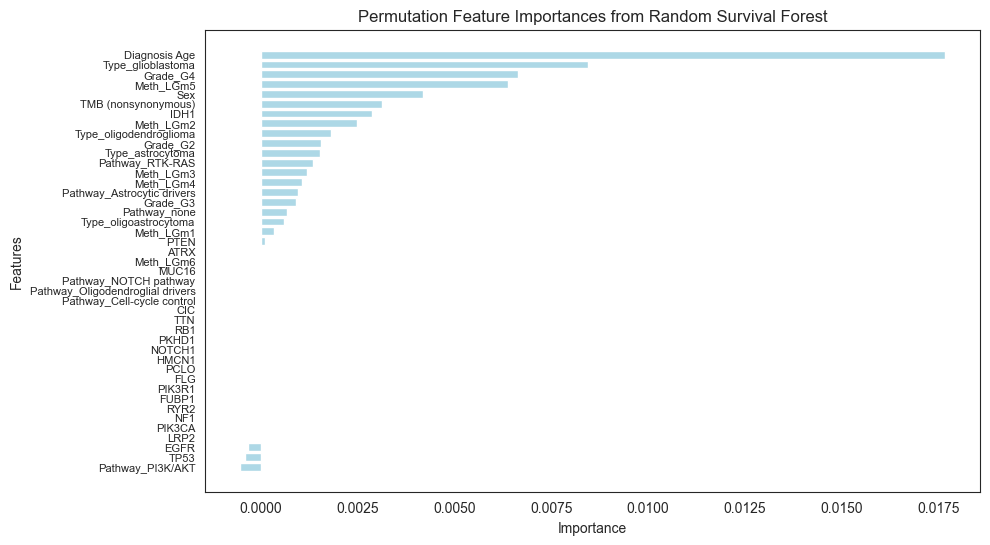

In [496]:
# Prepare the dataset
data = prediction.copy()

# Create feature matrix (X) and target variable (y)
X = data.drop(columns=['Patient ID', 'Overall Survival (Months)', 'Overall Survival Status', 'index'])
y = Surv.from_dataframe("Overall Survival Status", "Overall Survival (Months)", data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the feature matrix
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Random Survival Forest
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15, random_state=42)
rsf.fit(X_train_scaled, y_train)

# Validate the model using the test set
c_index = concordance_index_censored(y_test['Overall Survival Status'], y_test['Overall Survival (Months)'], rsf.predict(X_test_scaled))
print(f"Concordance Index on Test Set: {c_index[0]:.4f}")

# Calculate permutation importance on the test set
perm_importance = permutation_importance(rsf, X_test_scaled, y_test, n_repeats=30, random_state=42, n_jobs=-1)

# Extract feature importances and plot them
feature_importances = perm_importance.importances_mean
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightblue')
plt.gca().invert_yaxis()  # Show the most important features at the top
plt.title('Permutation Feature Importances from Random Survival Forest')
plt.xlabel('Importance')
plt.ylabel('Features', fontsize=10)
plt.tick_params(axis='y', labelsize=8)
plt.show()

In [491]:
# Identify features with negative or zero permutation importance
features_to_remove = importance_df[importance_df['Importance'] <= 0]['Feature'].tolist()

# Print features removed
print("Features removed due to negative or zero importance:")
print(features_to_remove)

# Create a list of features that are retained
features_retained = [feature for feature in X.columns if feature not in features_to_remove]
print("\nFeatures retained:")
print(features_retained)

# Drop removed features from the dataset
X_reduced = X[features_retained]

# Split the reduced dataset into training and testing sets
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

# Normalize the feature matrix
X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

# Train the Random Survival Forest on the reduced feature set
rsf_reduced = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15, random_state=42)
rsf_reduced.fit(X_train_reduced_scaled, y_train)

# Validate the model on the reduced test set
c_index_reduced = concordance_index_censored(
    y_test['Overall Survival Status'], y_test['Overall Survival (Months)'], rsf_reduced.predict(X_test_reduced_scaled)
)
print(f"\nConcordance Index on Reduced Test Set: {c_index_reduced[0]:.4f}")


Features removed due to negative or zero importance:
['ATRX', 'Meth_LGm6', 'MUC16', 'Pathway_NOTCH pathway', 'Pathway_Oligodendroglial drivers', 'Pathway_Cell-cycle control', 'CIC', 'TTN', 'RB1', 'PKHD1', 'NOTCH1', 'HMCN1', 'PCLO', 'FLG', 'PIK3R1', 'FUBP1', 'RYR2', 'NF1', 'PIK3CA', 'LRP2', 'EGFR', 'TP53', 'Pathway_PI3K/AKT']

Features retained:
['Diagnosis Age', 'Sex', 'TMB (nonsynonymous)', 'IDH1', 'PTEN', 'Grade_G2', 'Grade_G3', 'Grade_G4', 'Meth_LGm1', 'Meth_LGm2', 'Meth_LGm3', 'Meth_LGm4', 'Meth_LGm5', 'Pathway_Astrocytic drivers', 'Pathway_RTK-RAS', 'Pathway_none', 'Type_astrocytoma', 'Type_glioblastoma', 'Type_oligoastrocytoma', 'Type_oligodendroglioma']

Concordance Index on Reduced Test Set: 0.8261


## **Conclusions**

Incorporating molecular markers (particularly IDH status, telomere‐maintenance, and p53 pathway alteration) substantially refines glioma classification beyond histology alone, yielding clinically and biologically coherent subtypes with distinct prognoses. Unsupervised clustering reveals further subtypes stratified by driver pathways and methylation profiles, raising the possibility of tailoring therapies to these finer molecular niches. A conservative voting‐based feature selection and ensemble classifier achieves great performance on the development data but experiences performance decay on independent validation, highlighting the need for additional data, cross‐study harmonization, and potentially simpler models to ensure real‐world generalizability. Random survival forests leveraging the same core features demonstrate good concordance in predicting patient outcomes, supporting their role in prognostic modeling and risk stratification.

To close the generalization gap, the model should be trained on larger, multi‐institutional cohorts, ideally with prospective validation, and benchmarked against clinical risk scores. Integration of additional data modalities (e.g. imaging, transcriptomics), dynamic monitoring (e.g. serial liquid biopsy), and exploration of treatment‐response phenotypes will further advance precision medicine in glioma care.

In summary, this project confirms that molecular profiling is indispensable for modern glioma diagnosis and prognosis, and that thoughtful feature selection combined with ensemble learning can yield powerful predictive tools, provided they are rigorously validated and continuously refined with broader, real‐world data.
